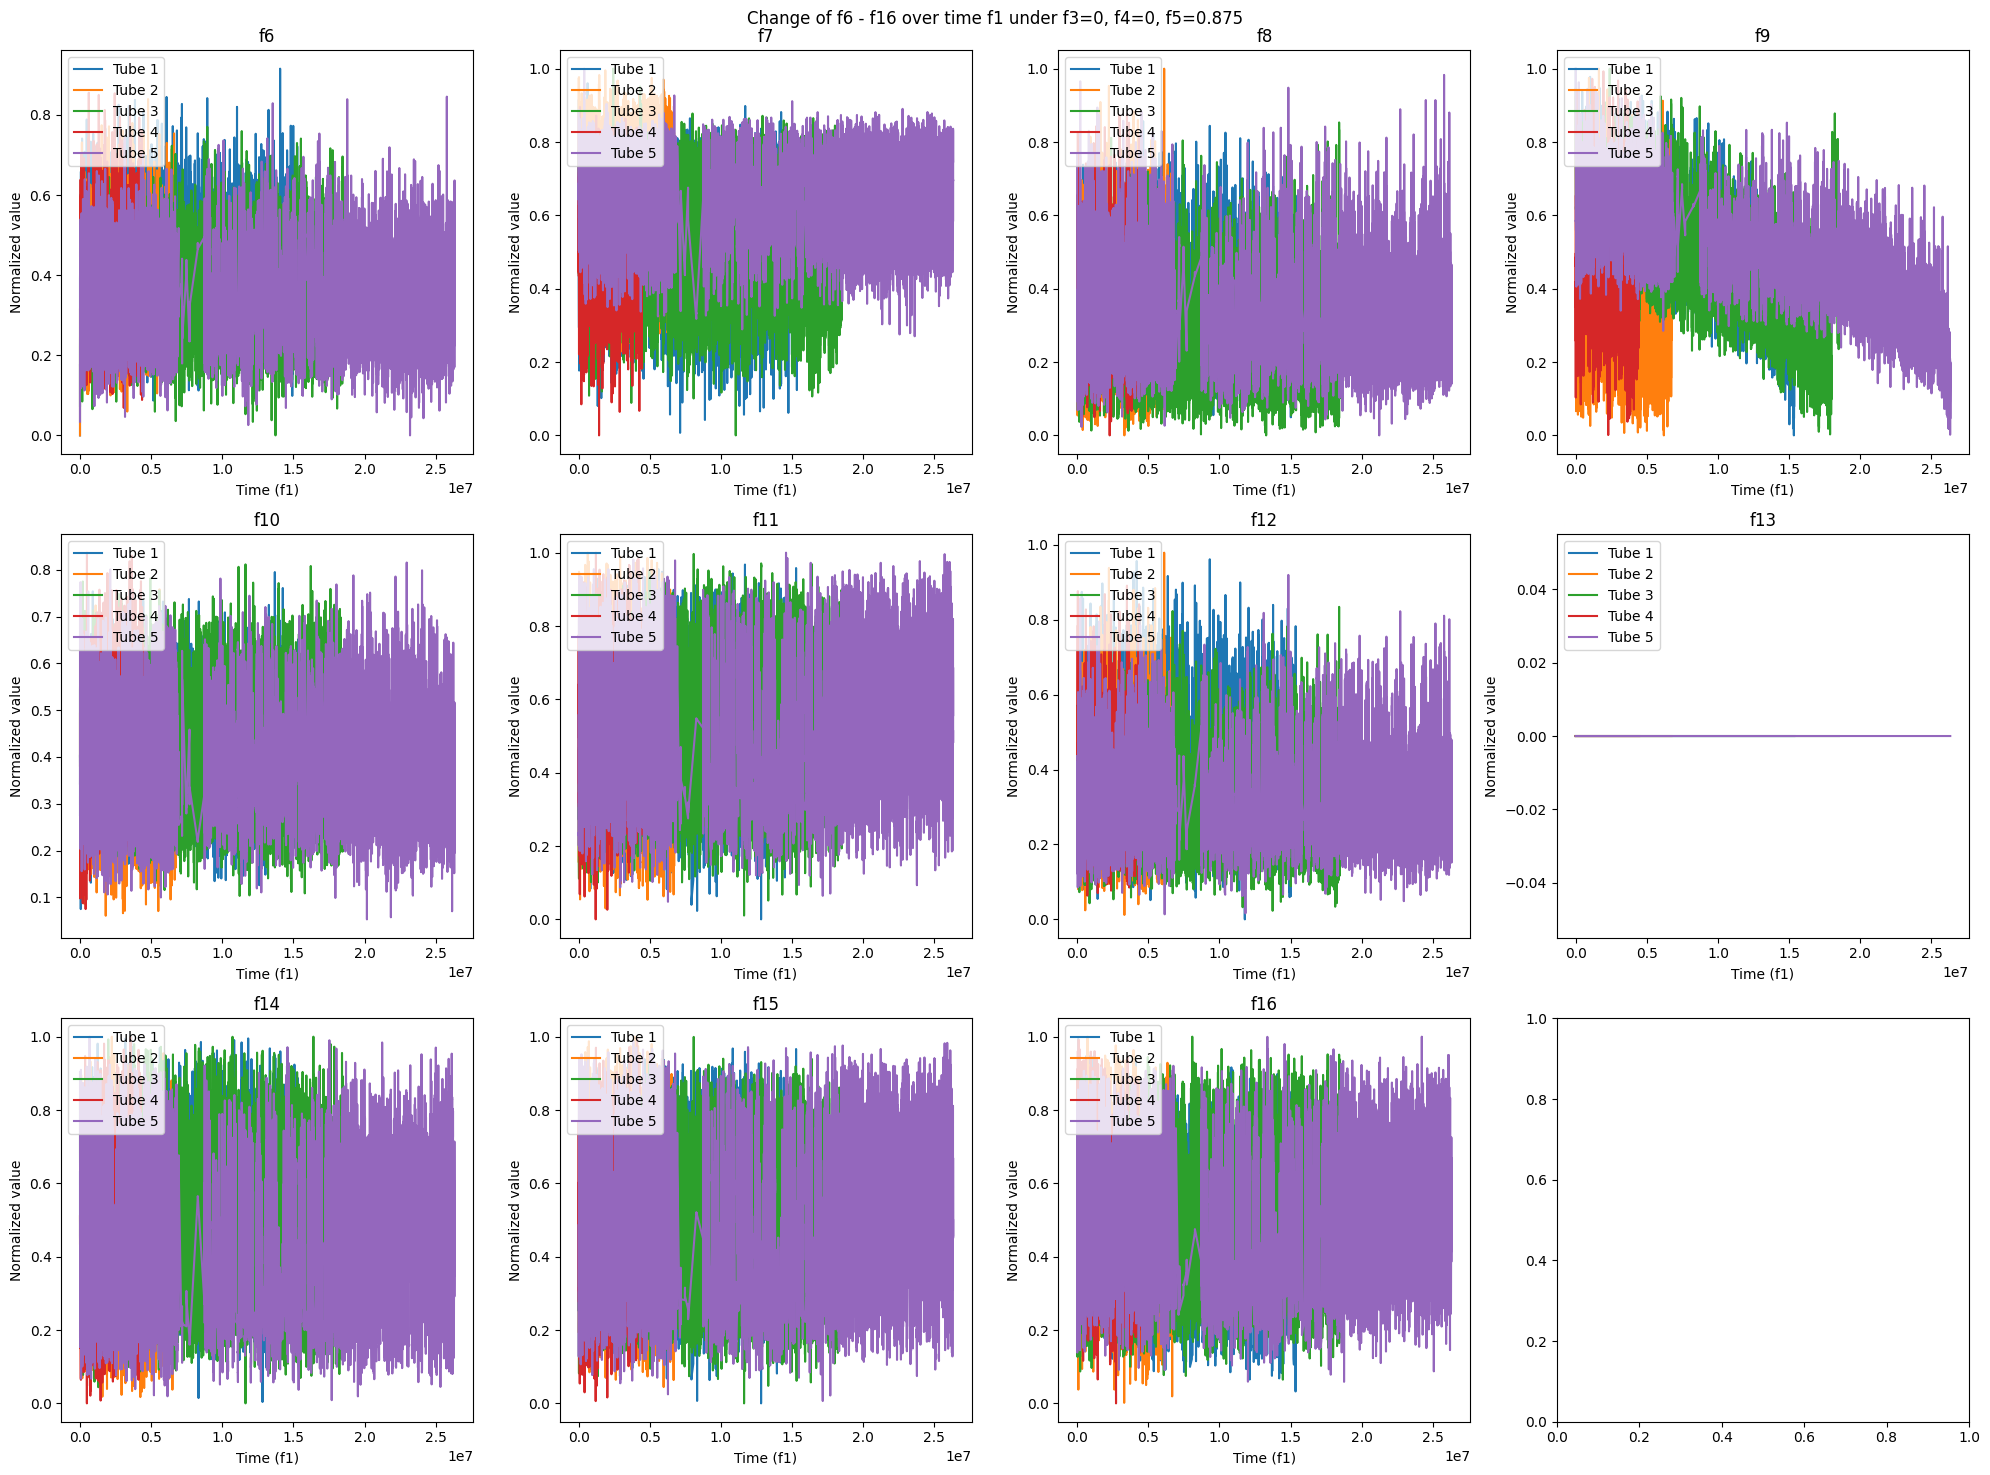

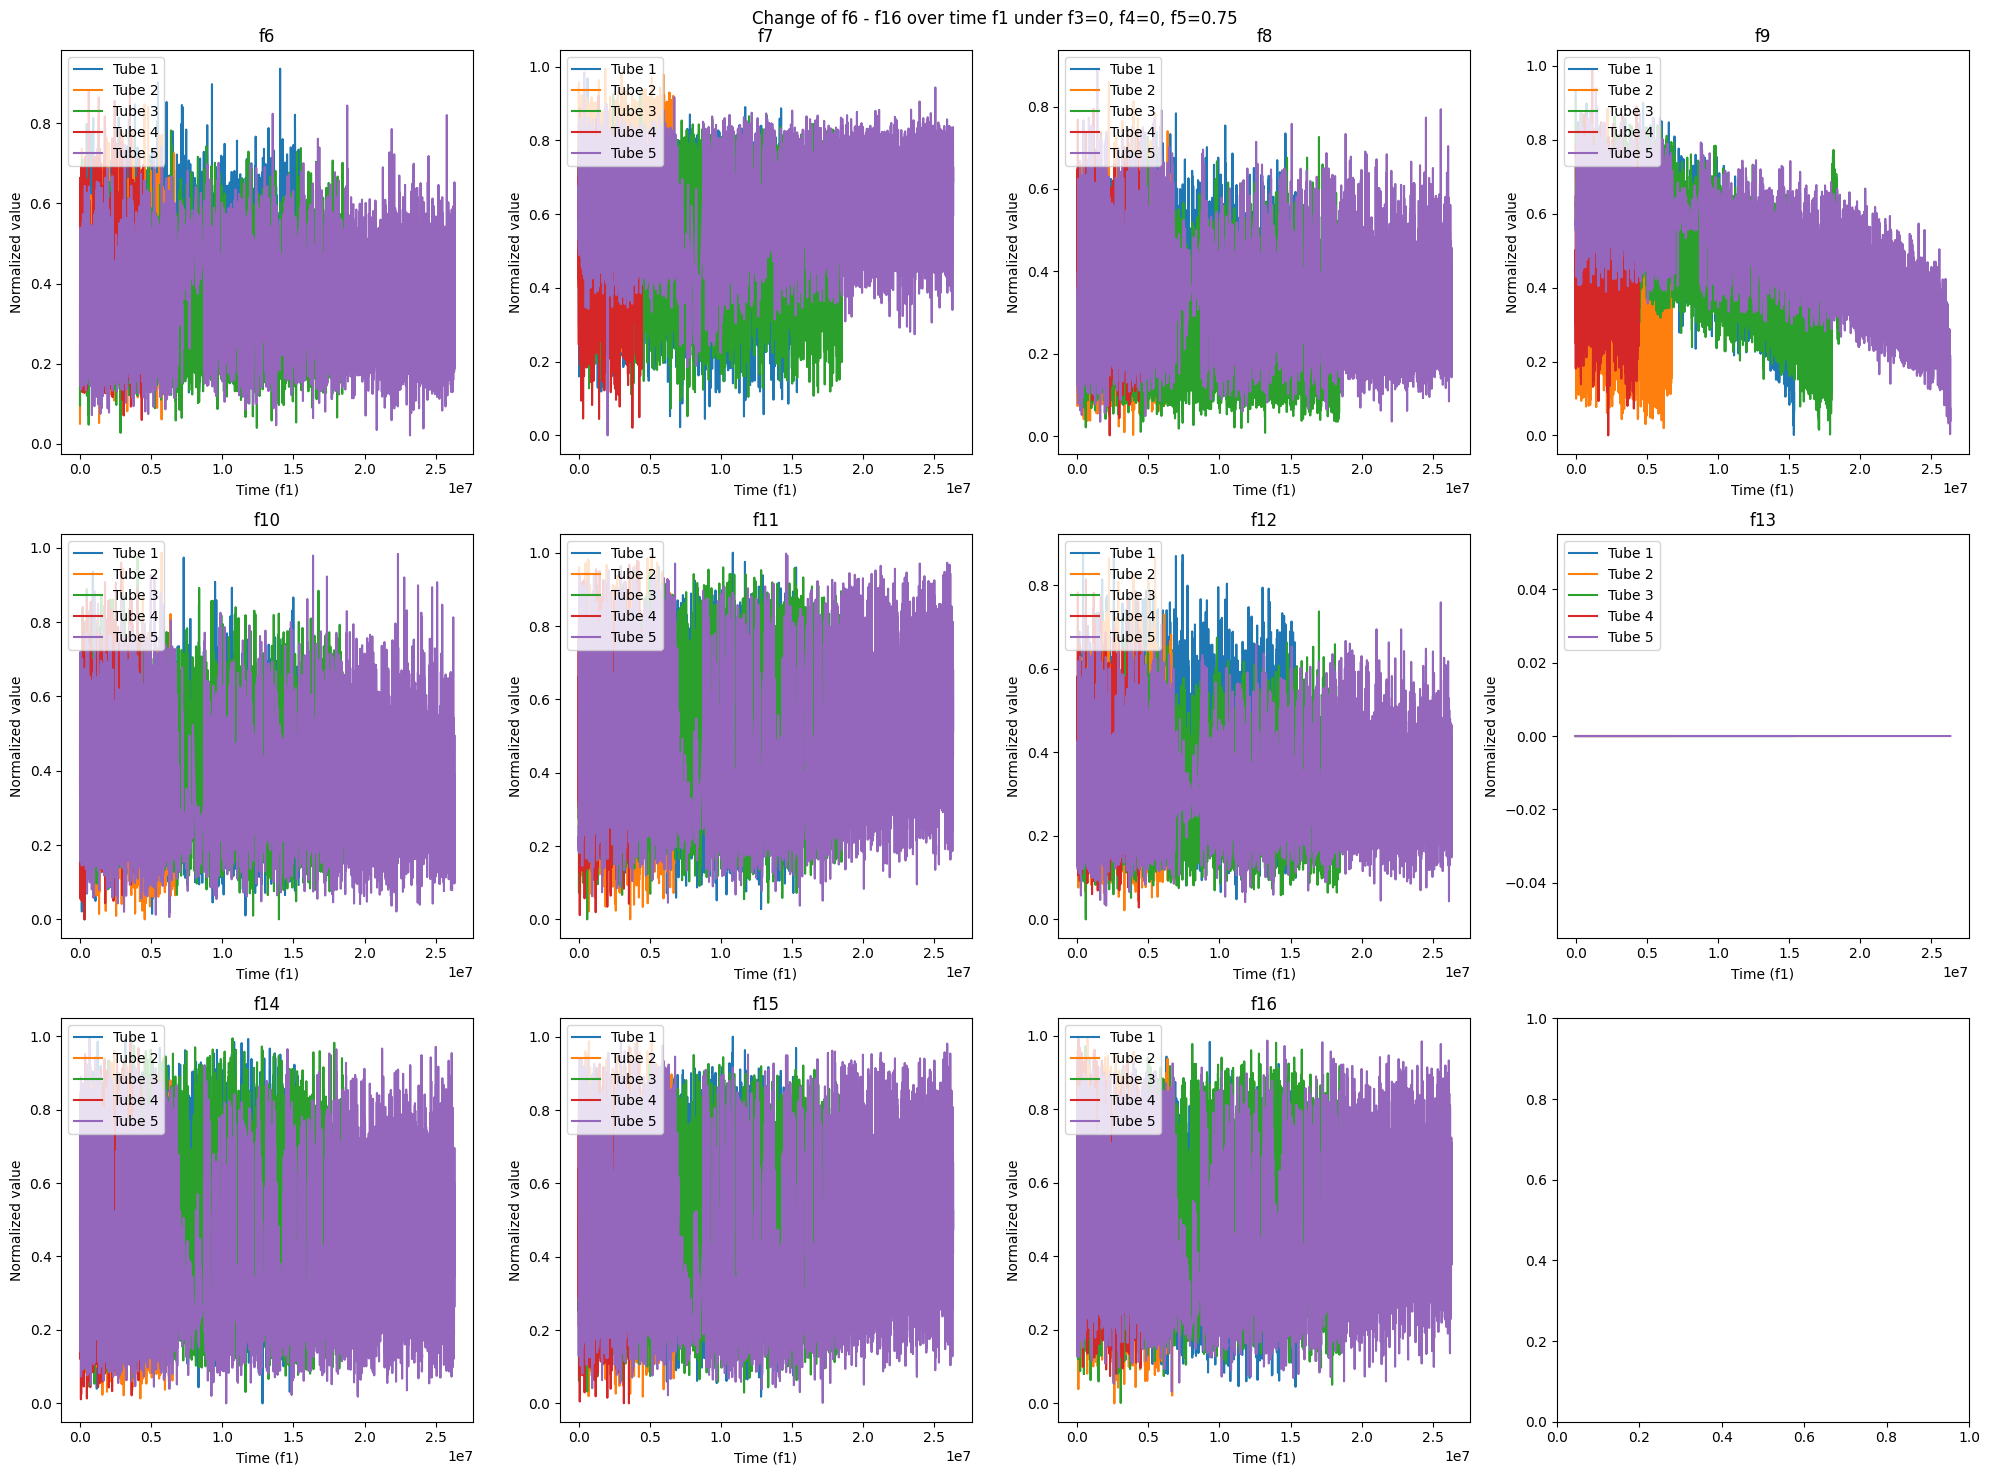

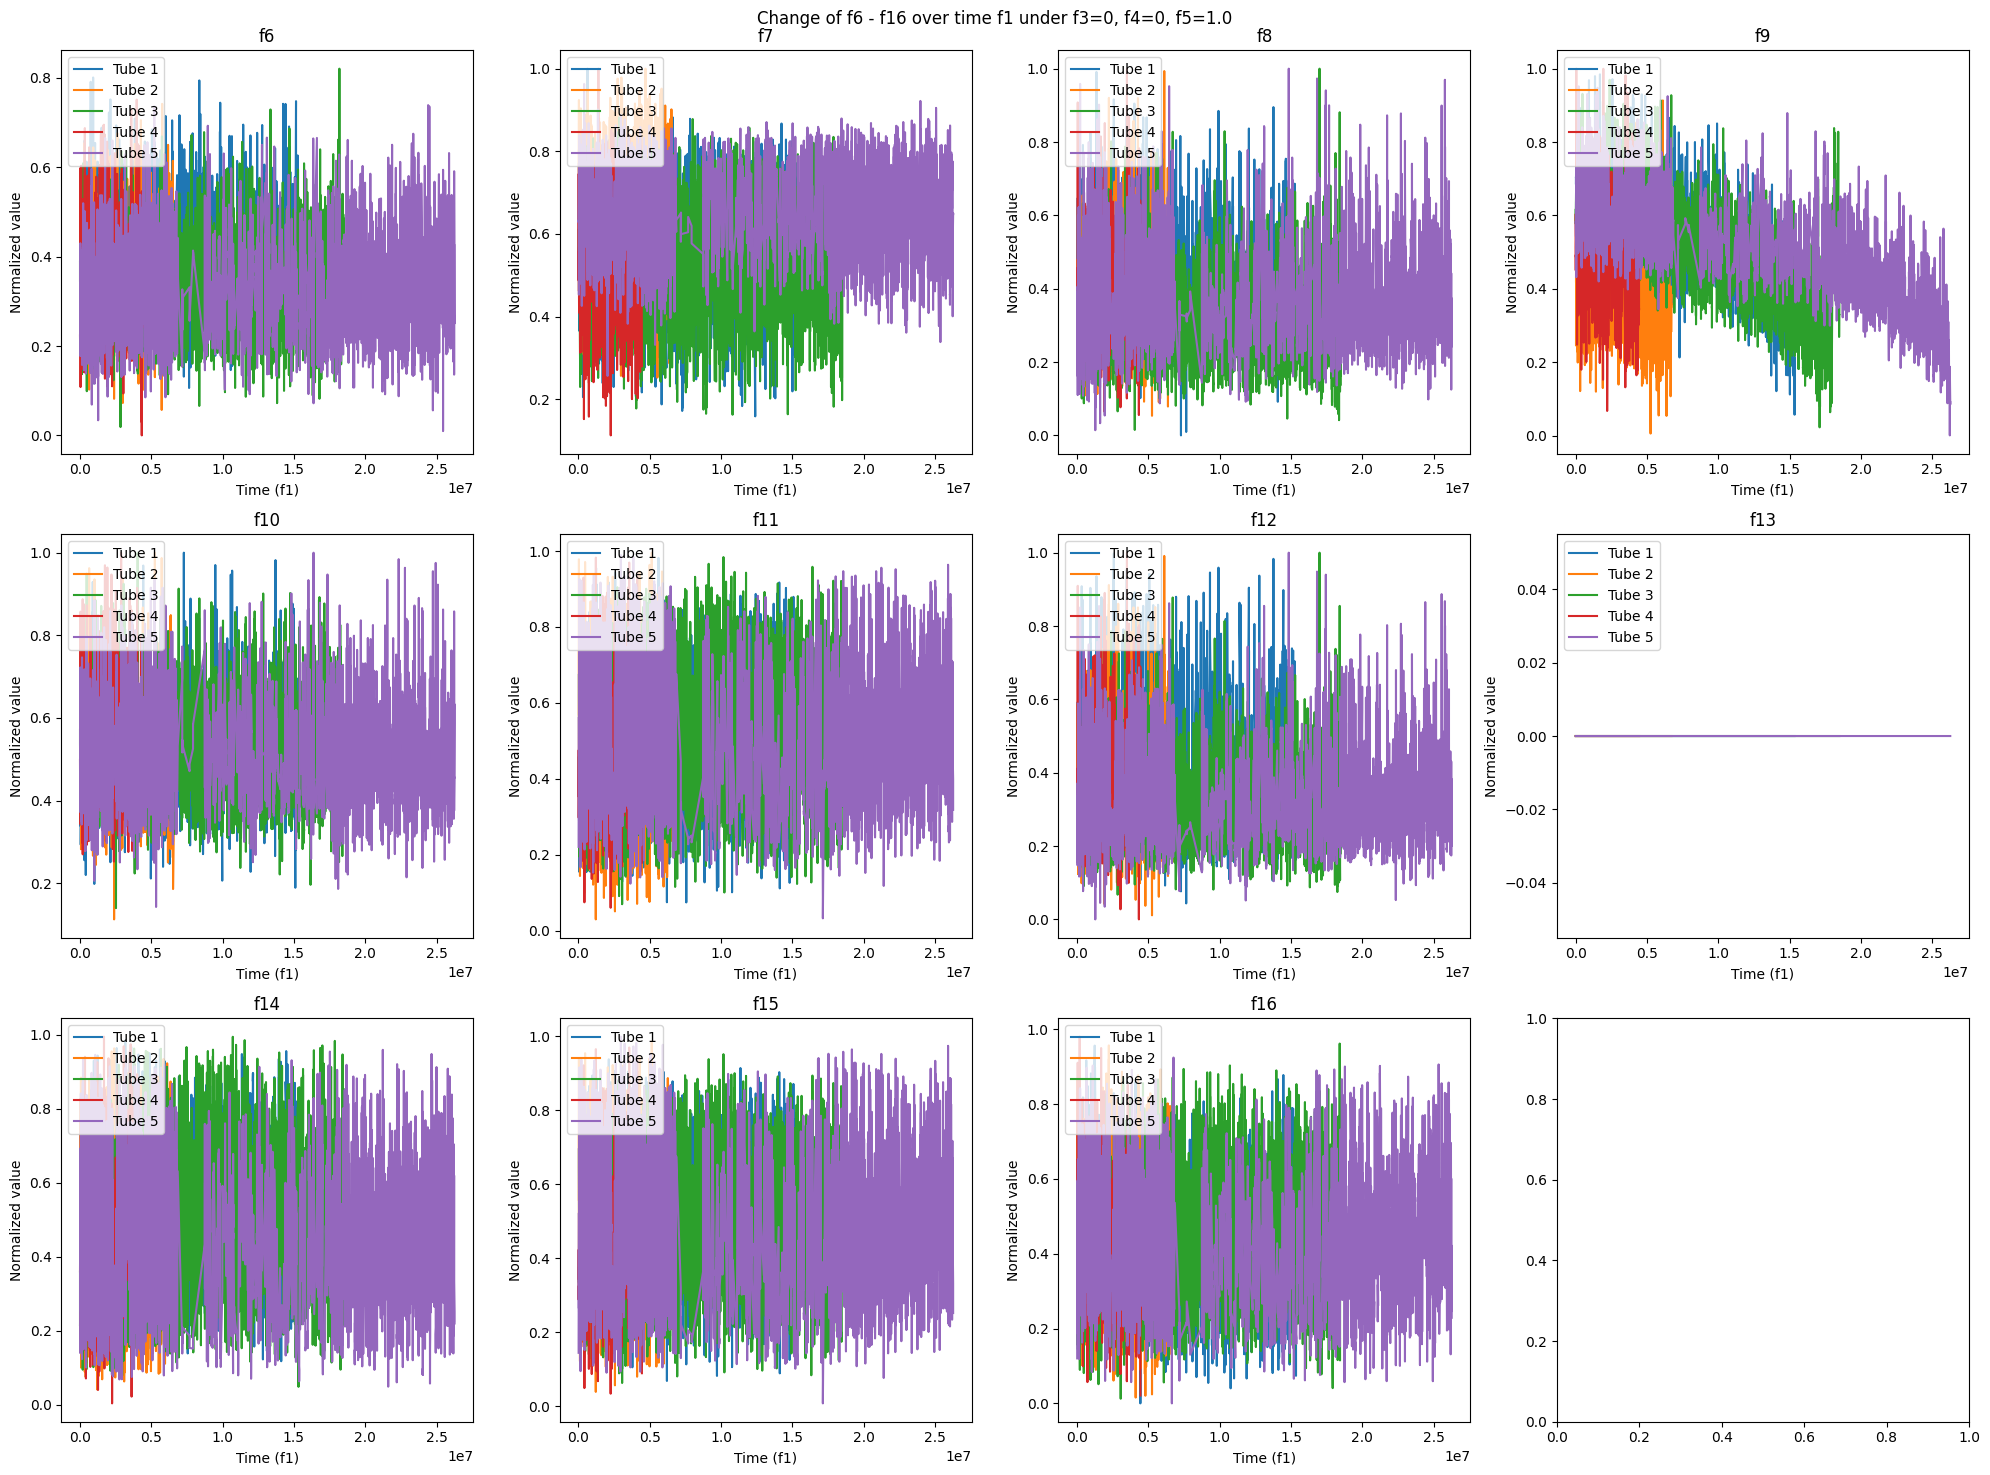

C:\Users\VictorArno\AppData\Local\Temp\ipykernel_6140\3398465544.py:123: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left')


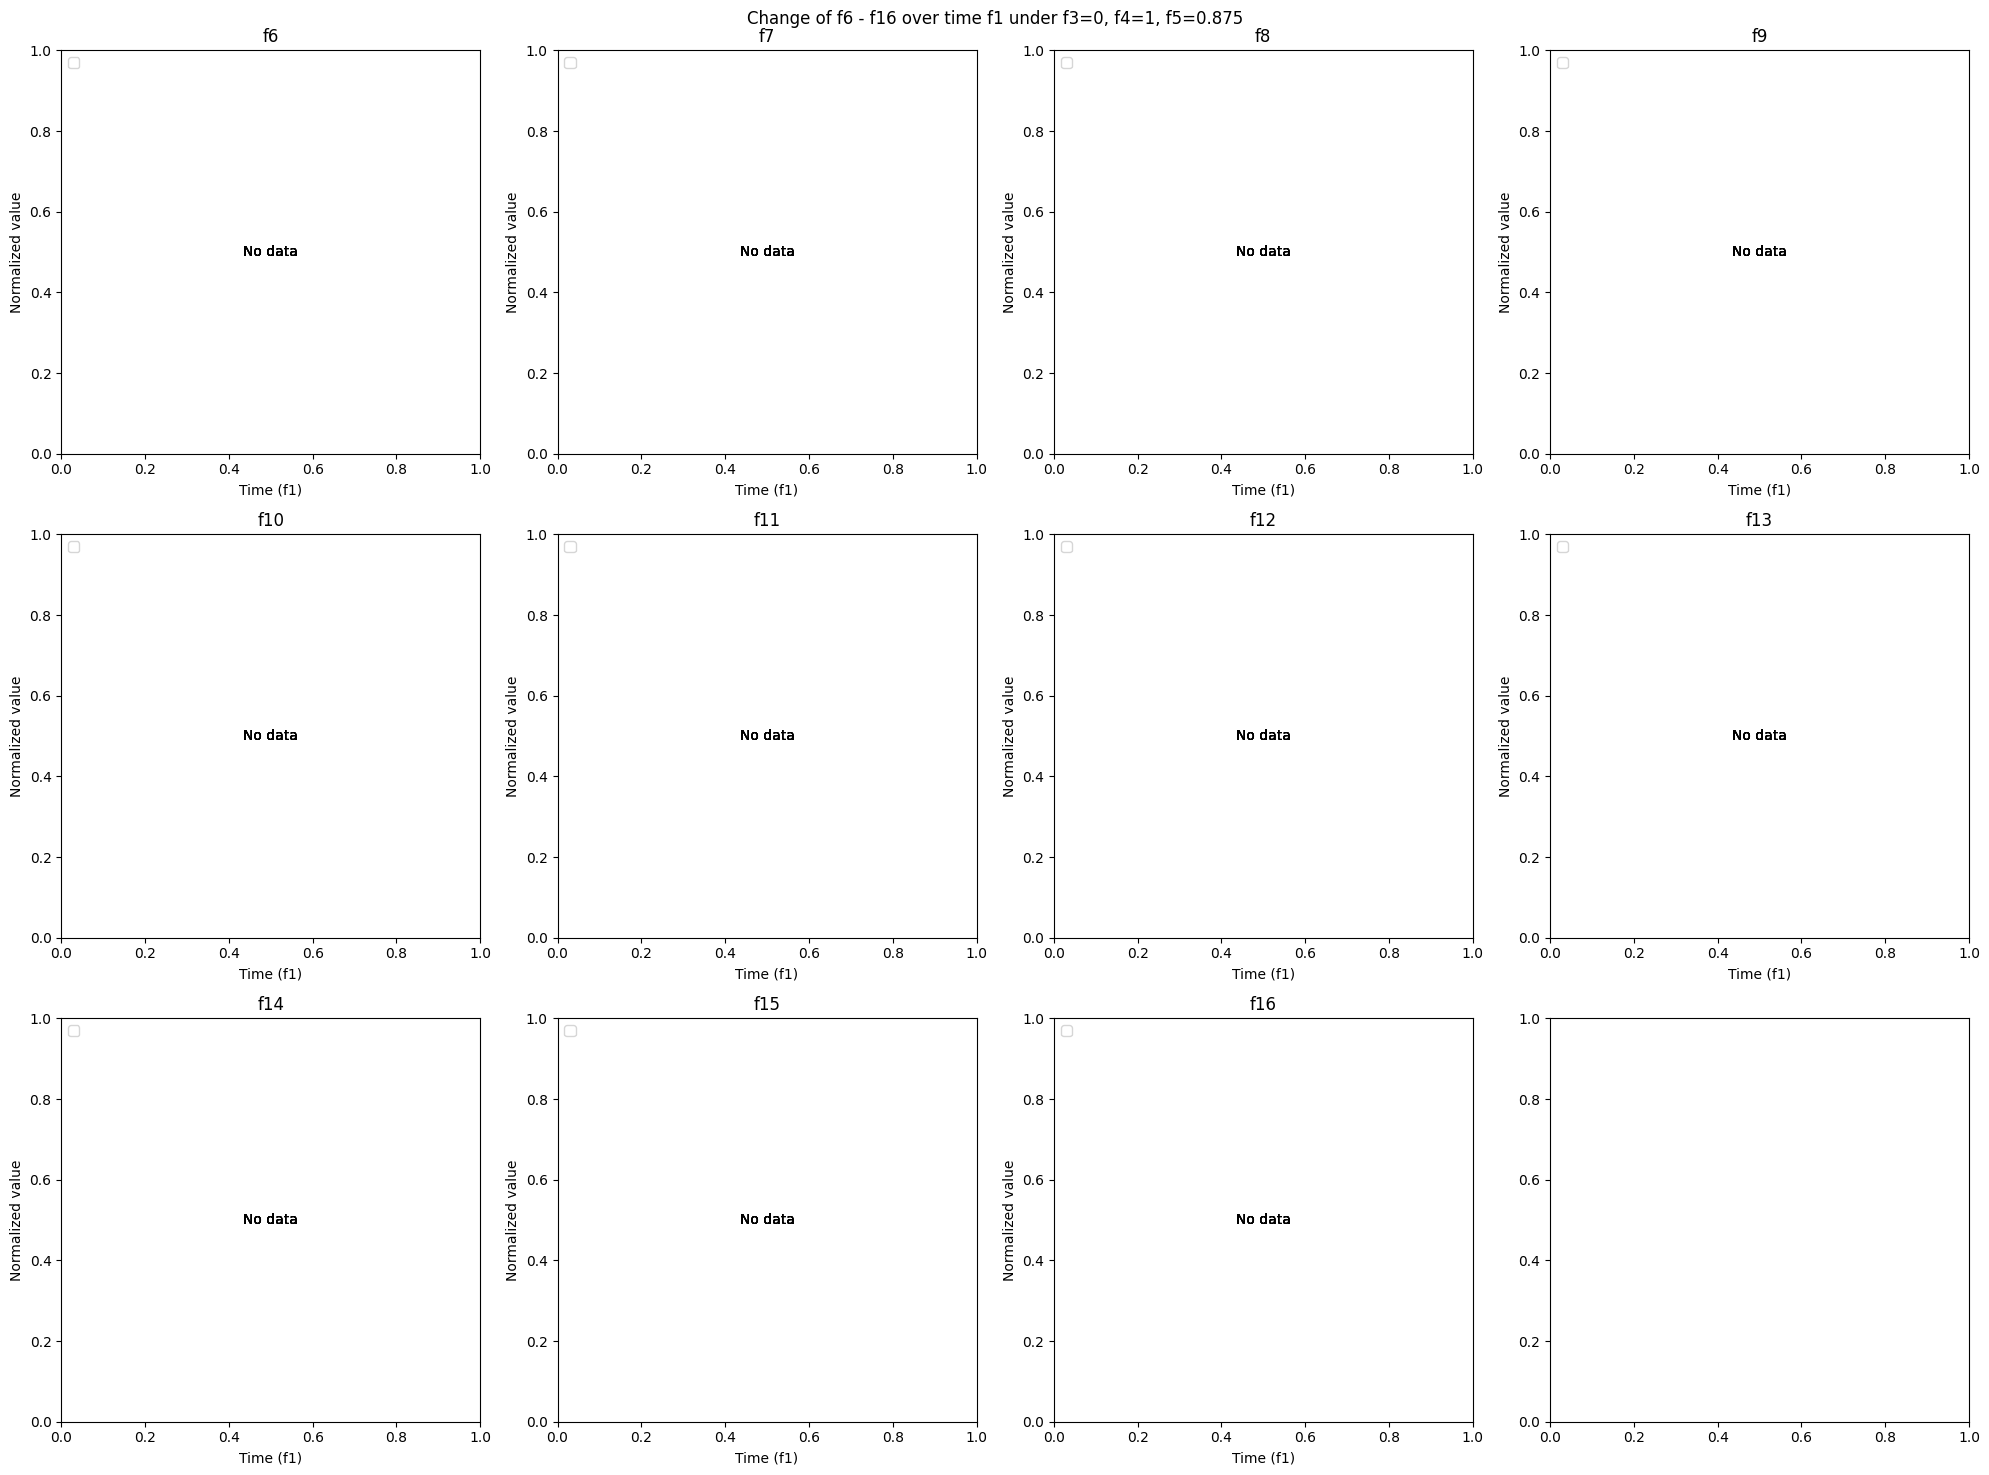

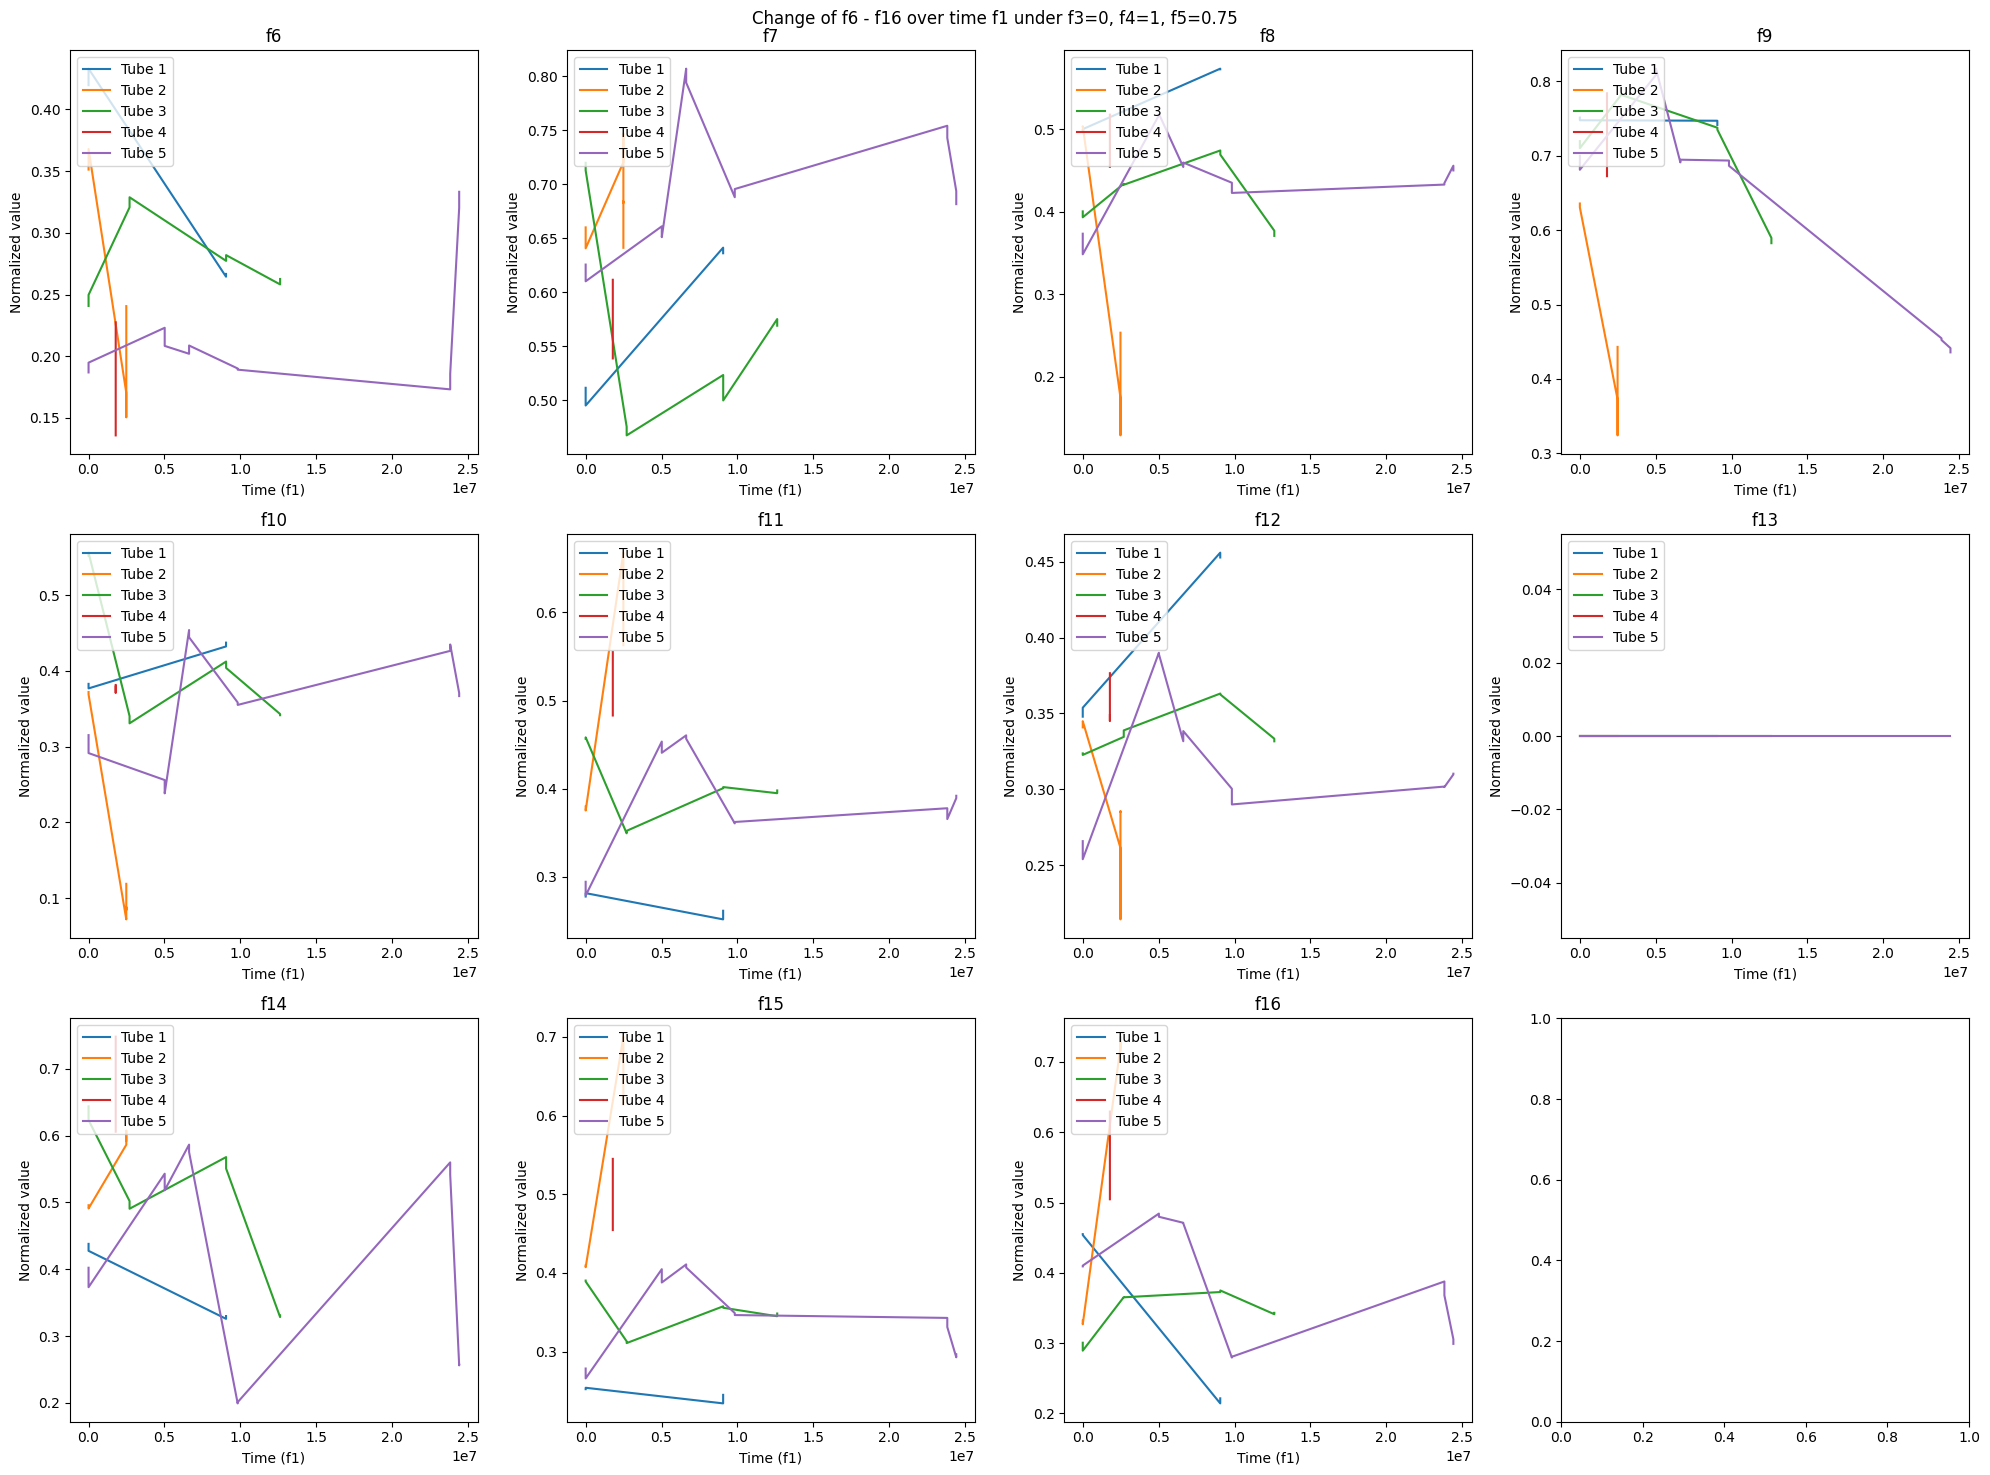

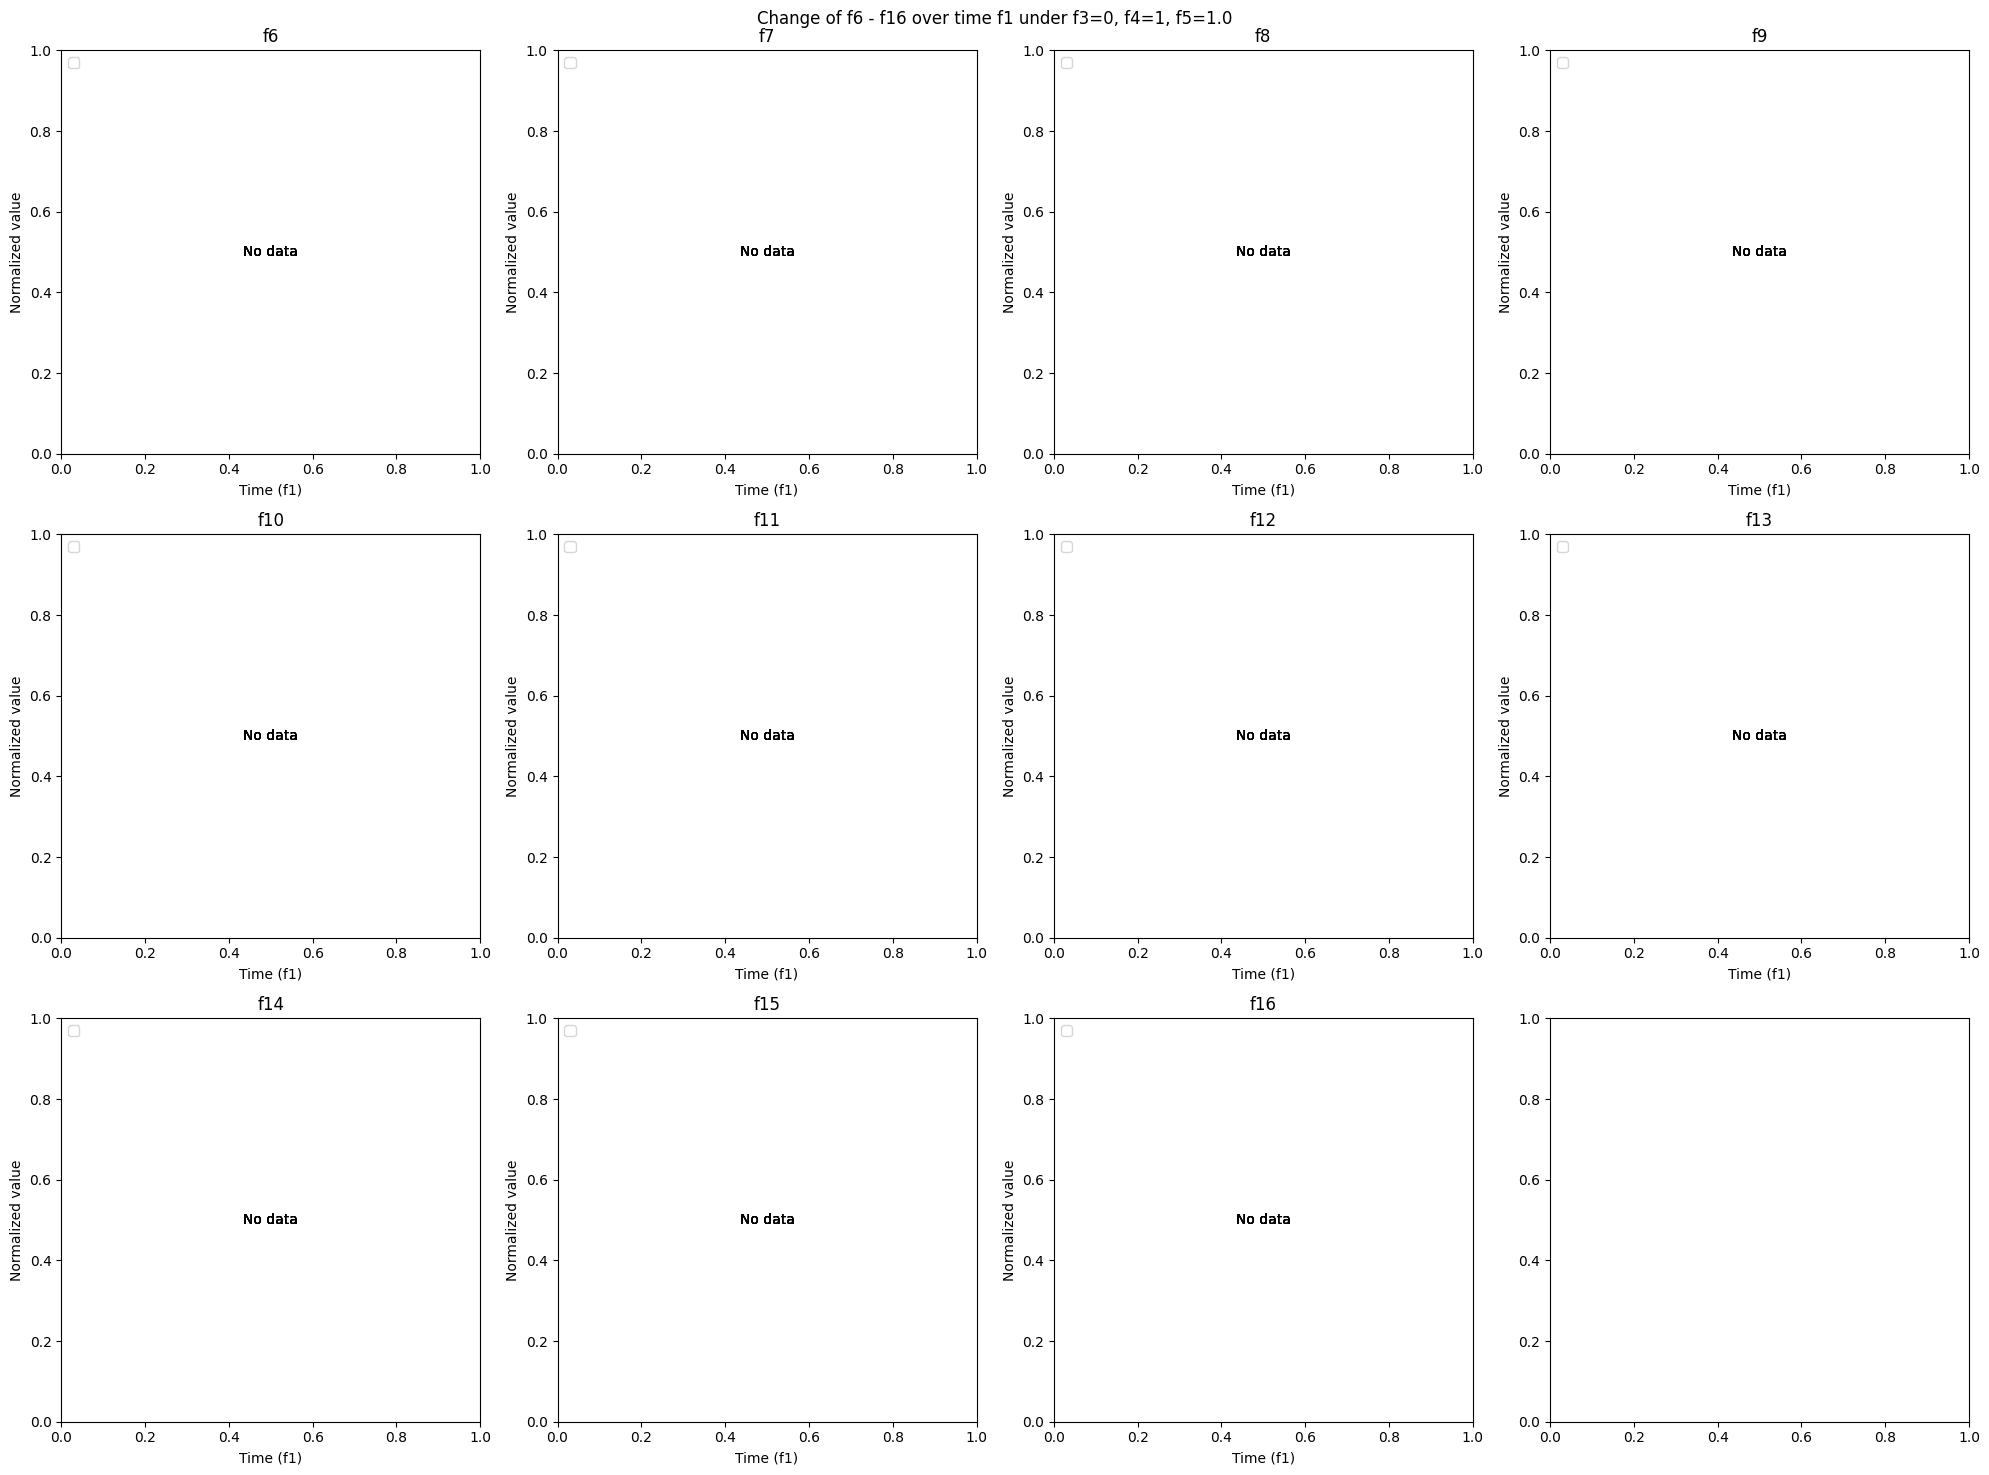

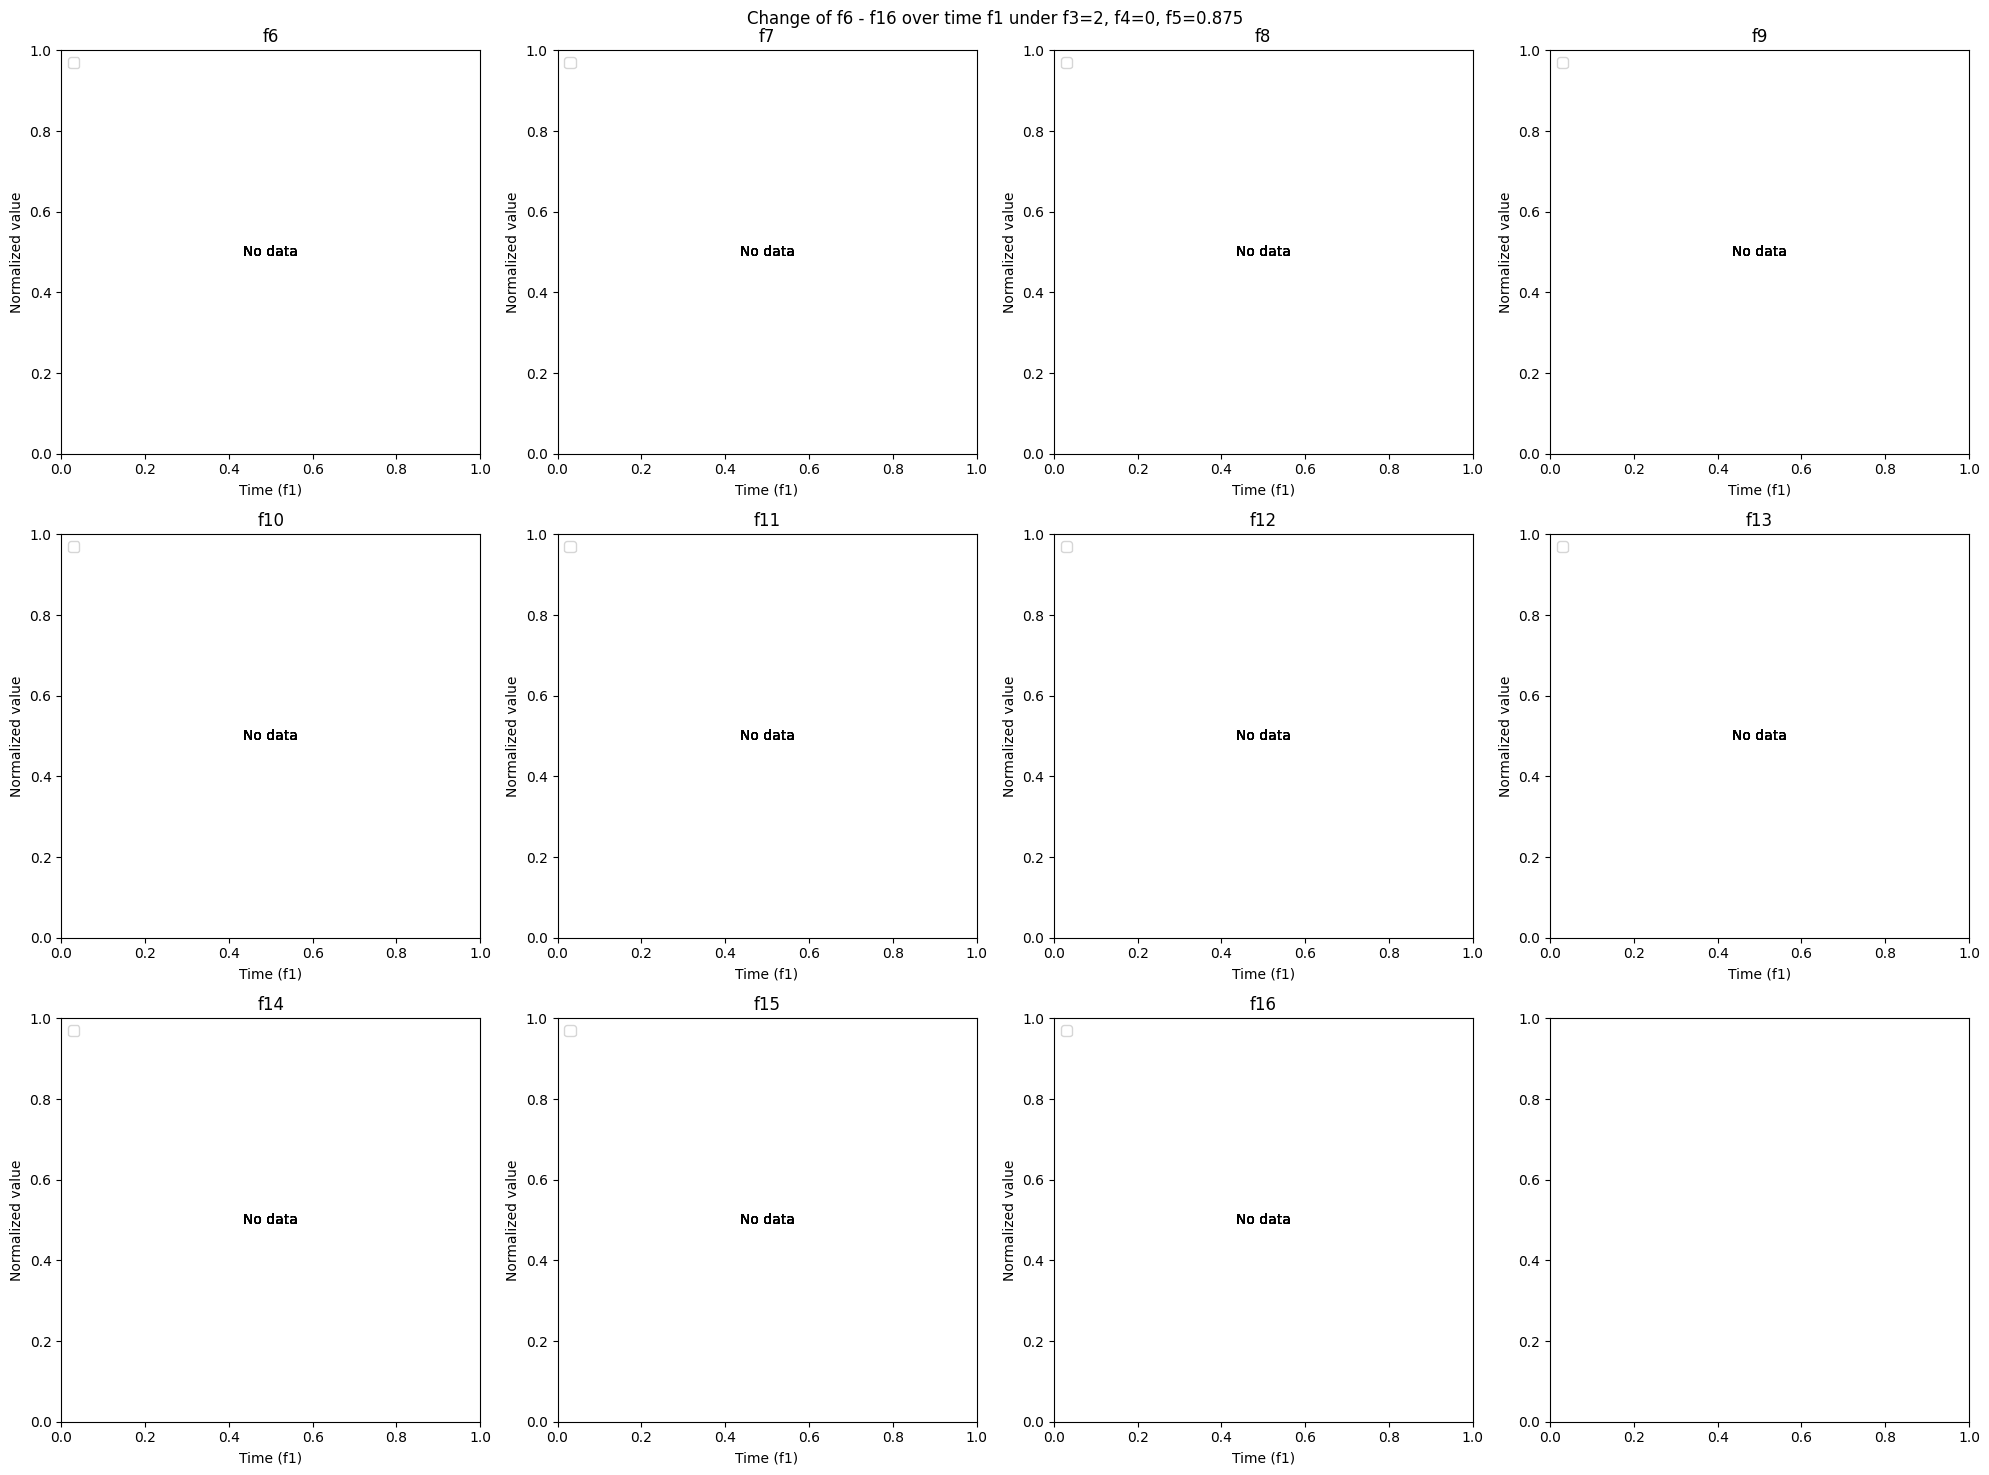

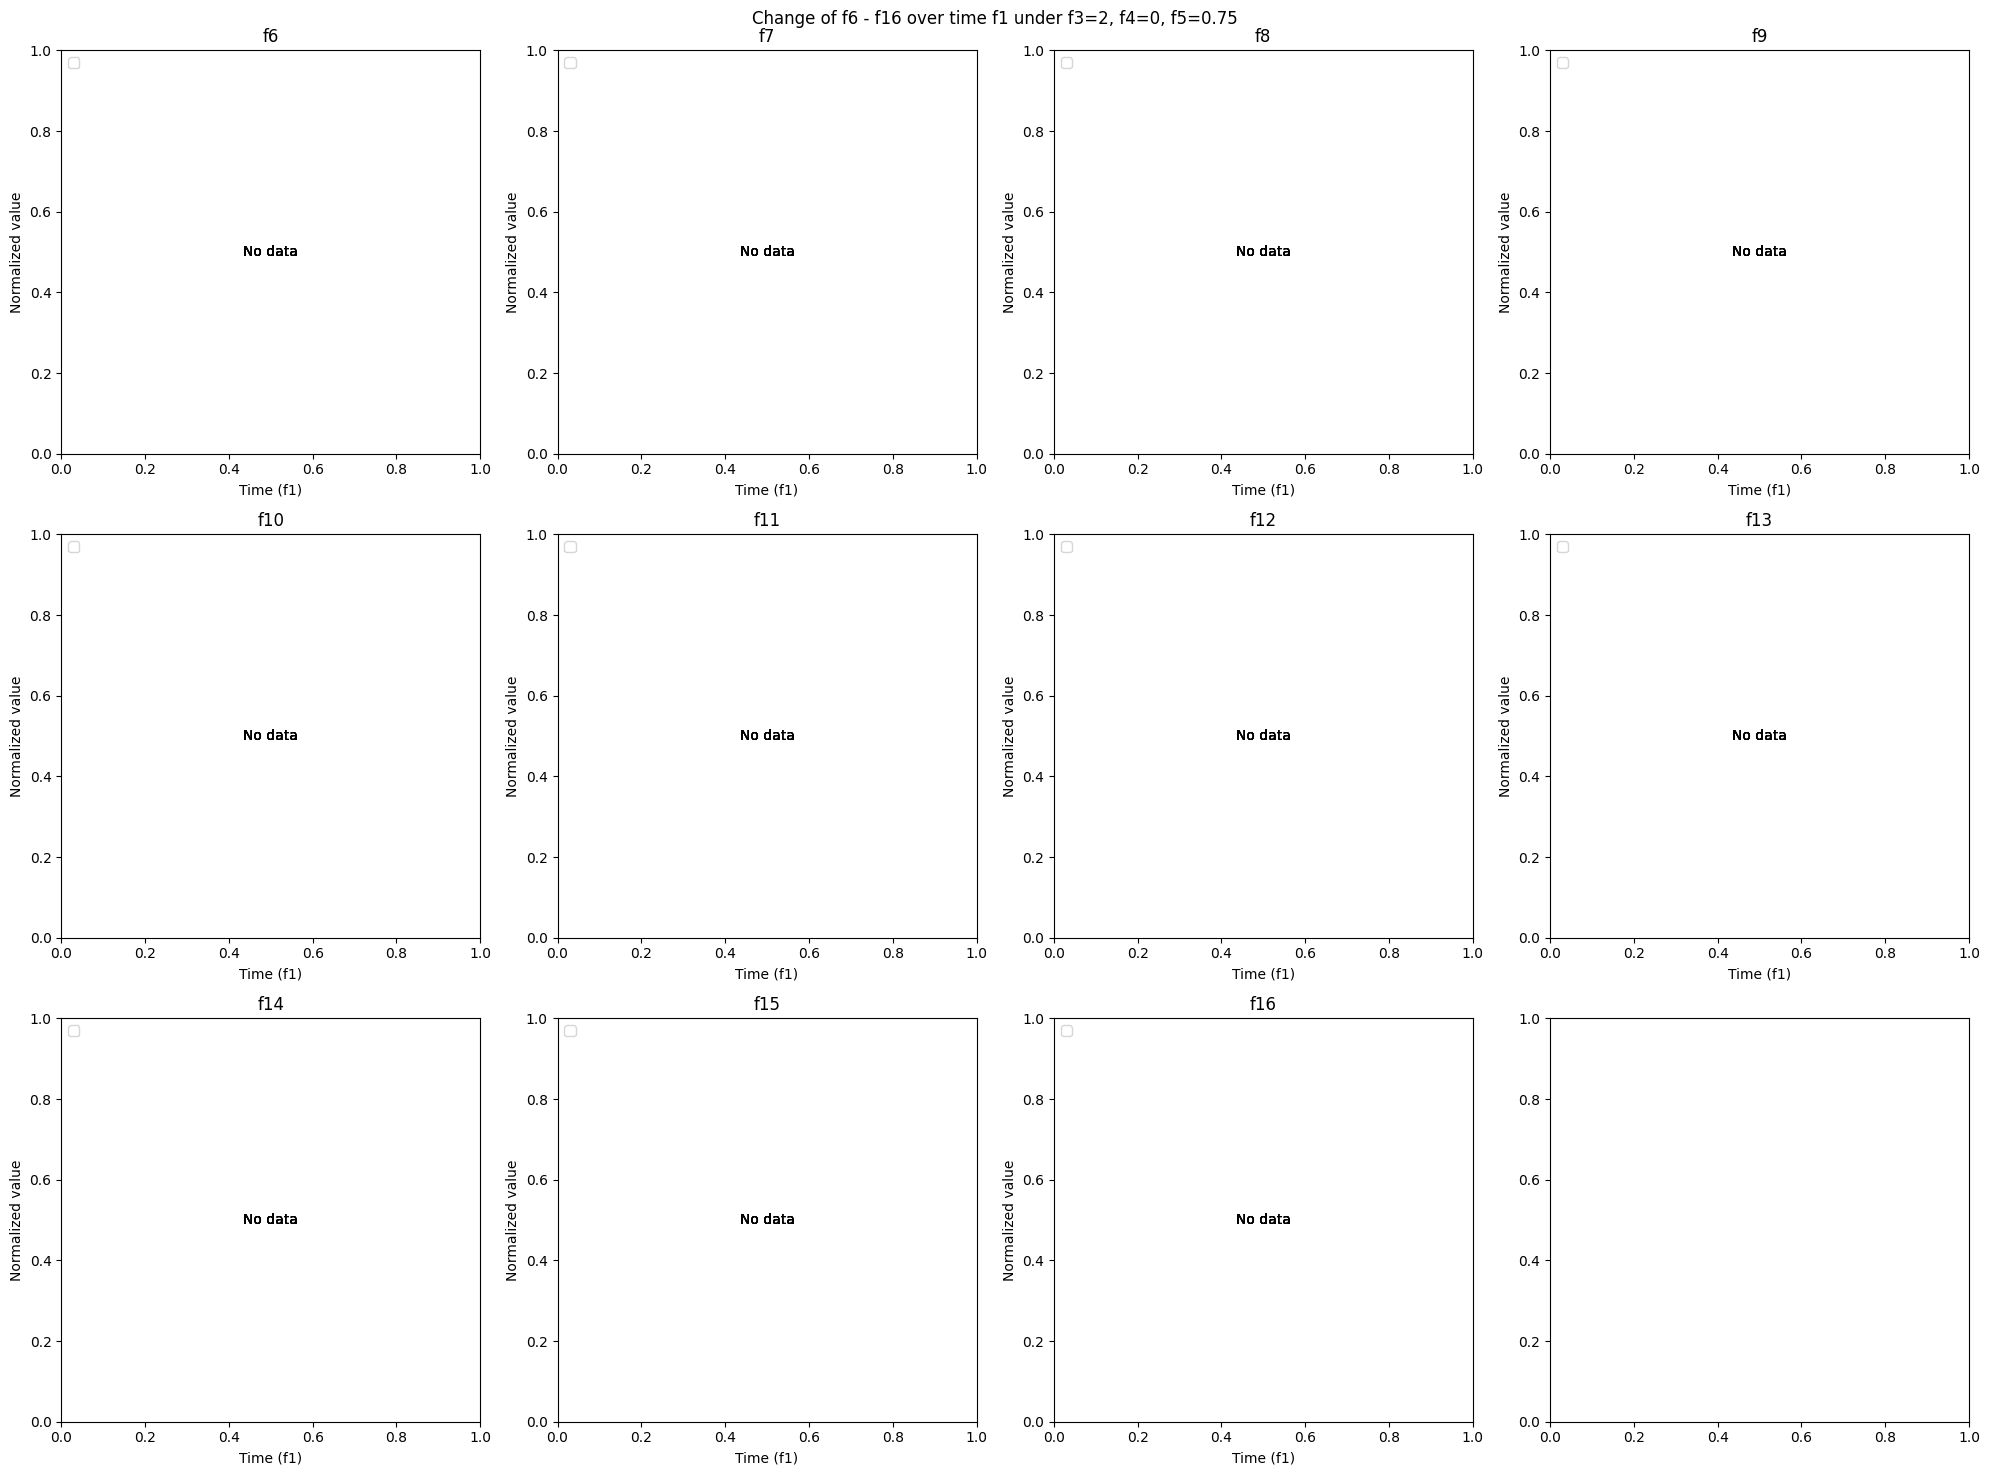

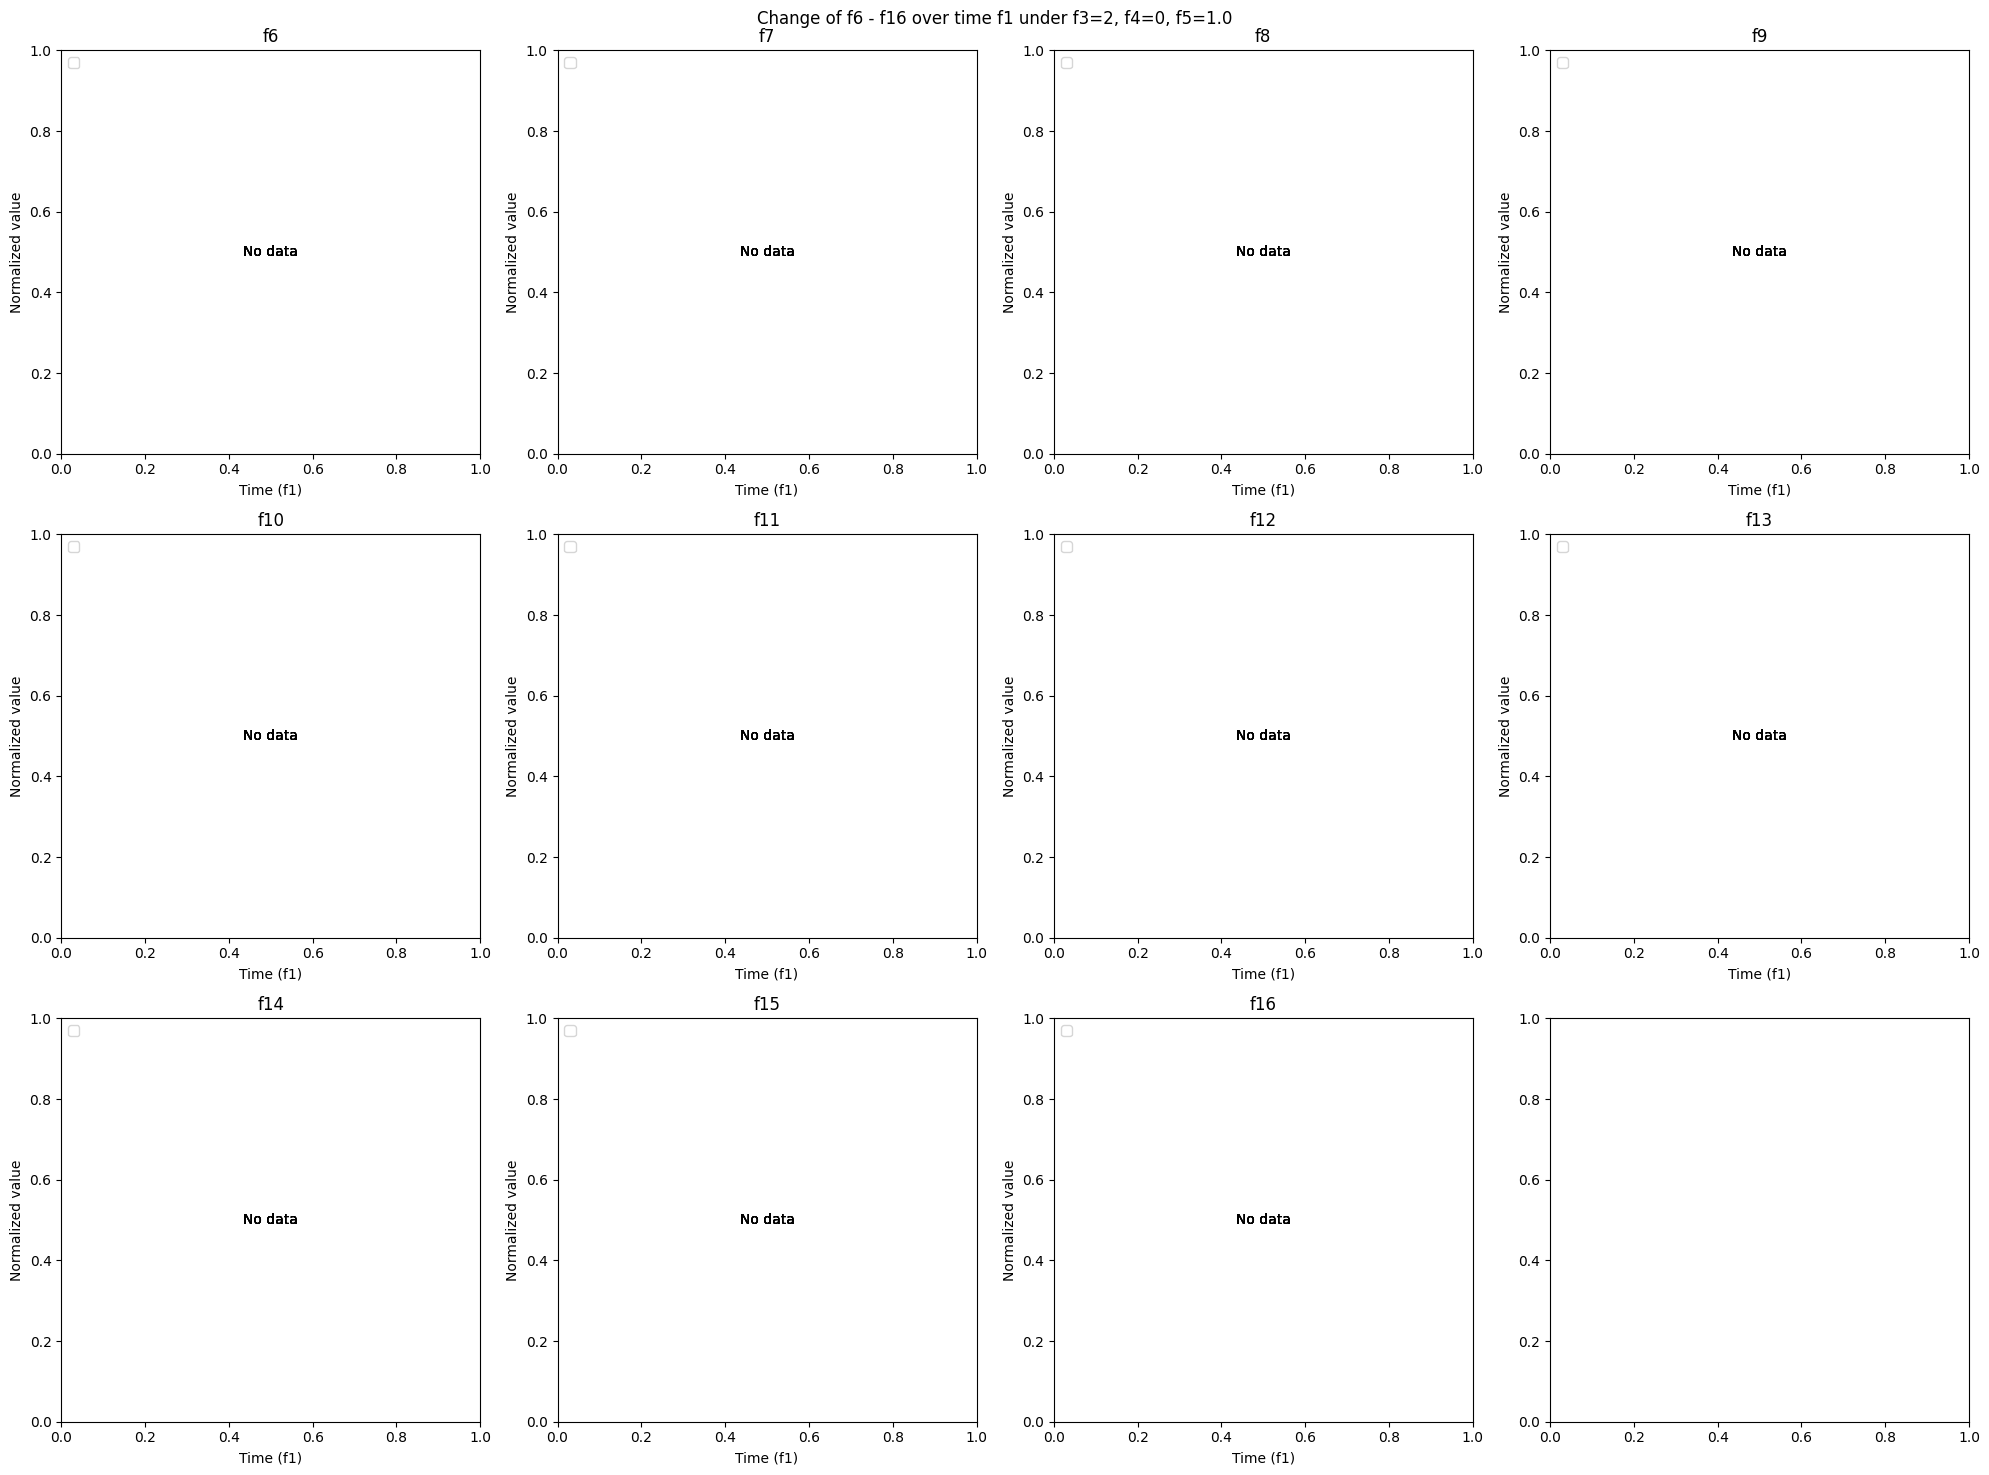

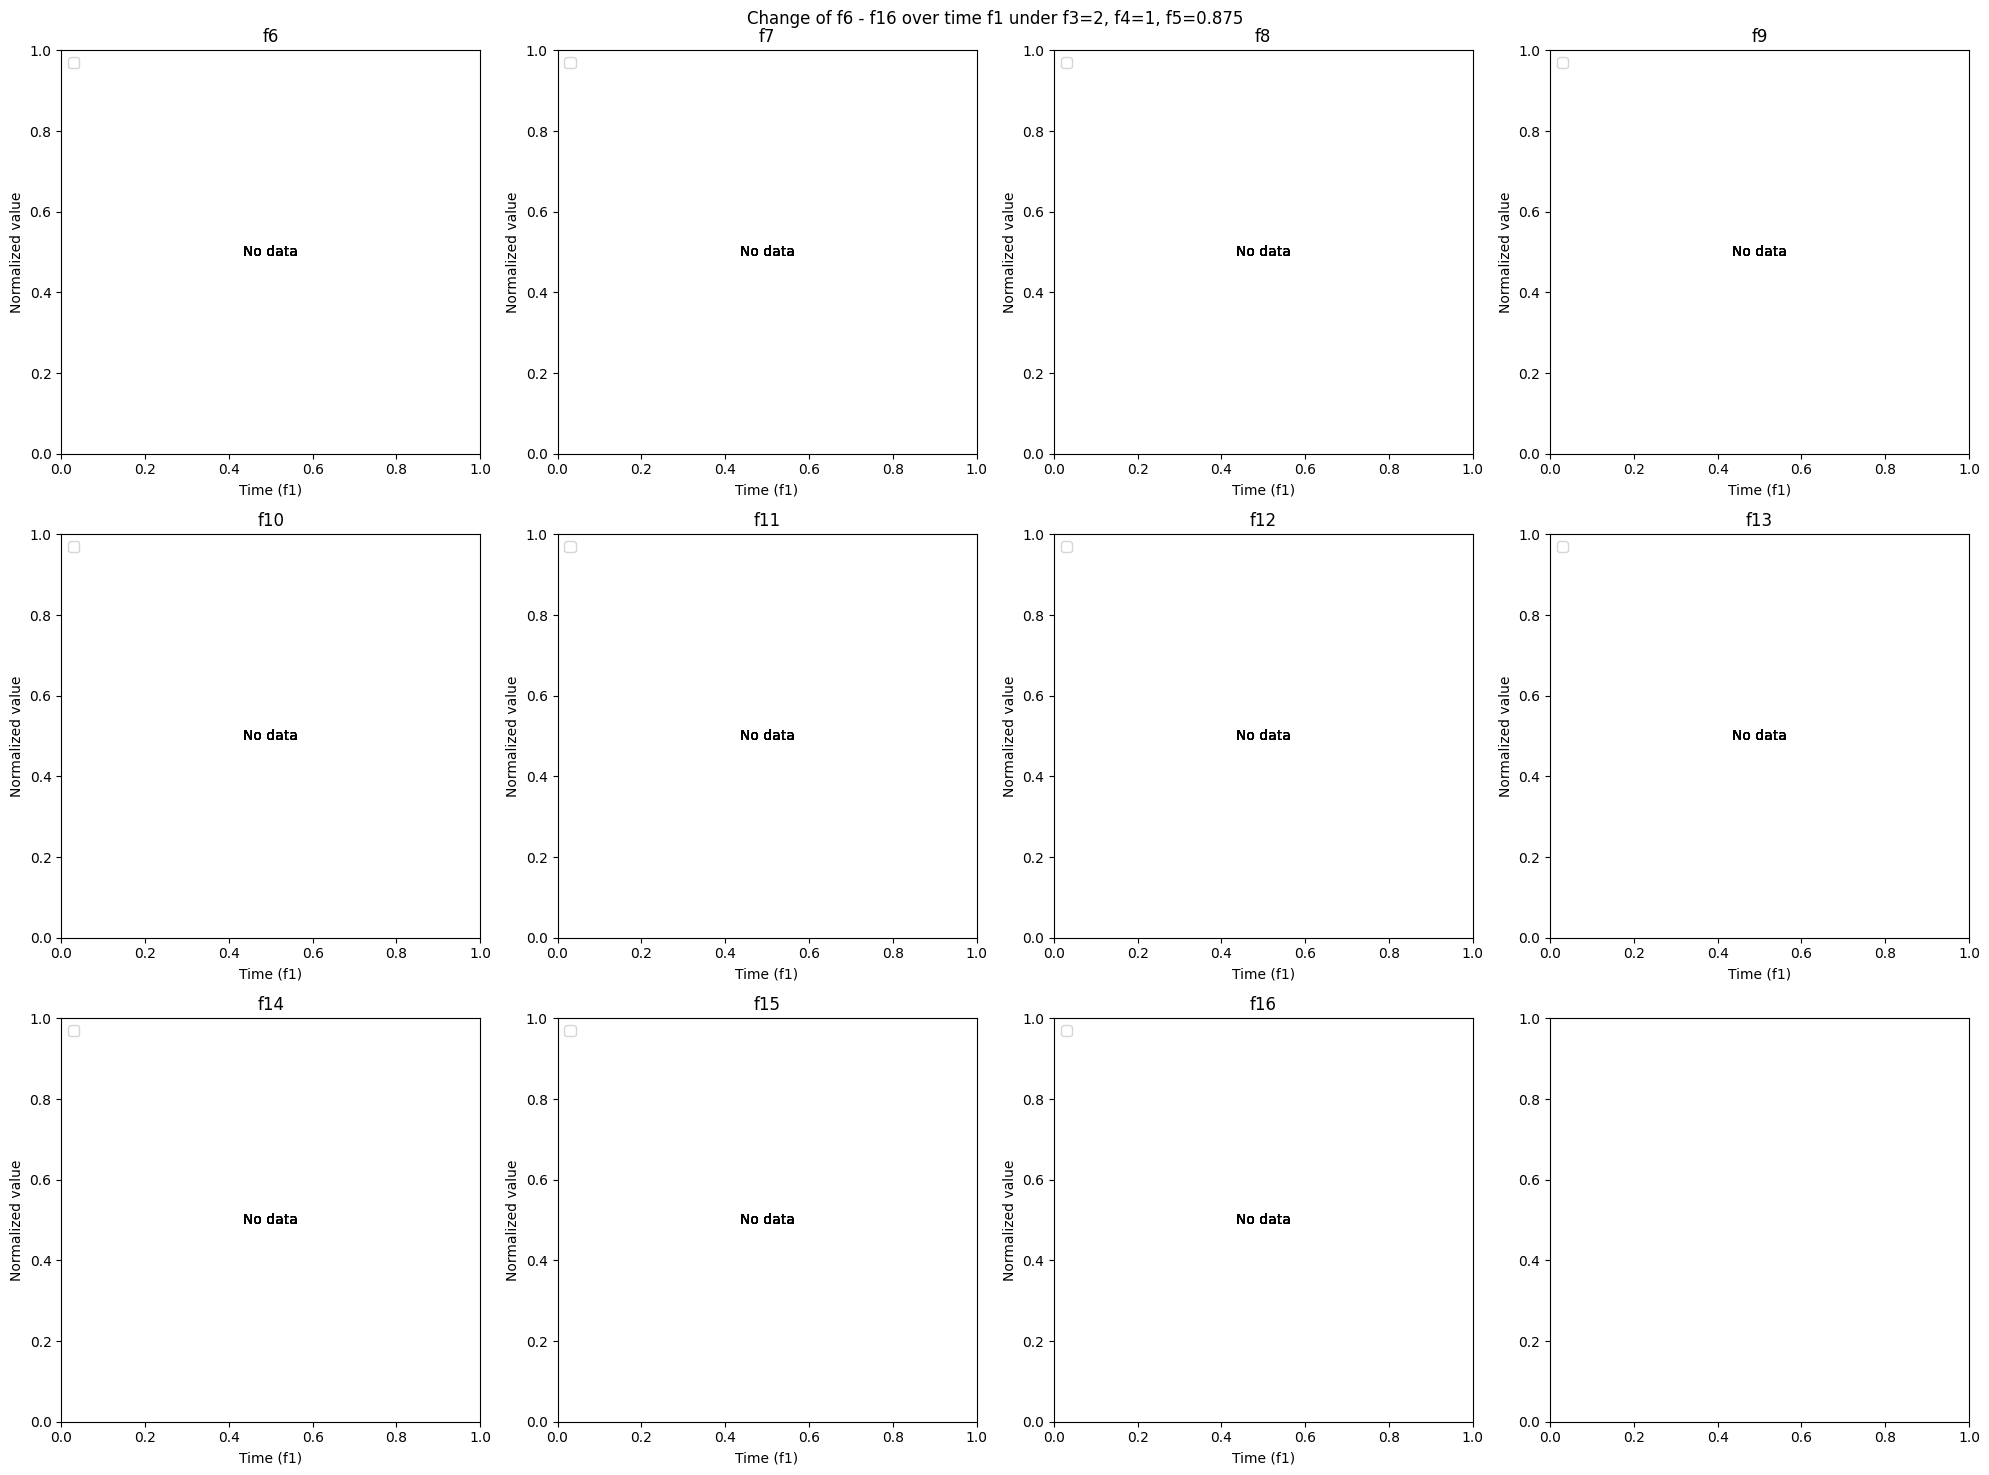

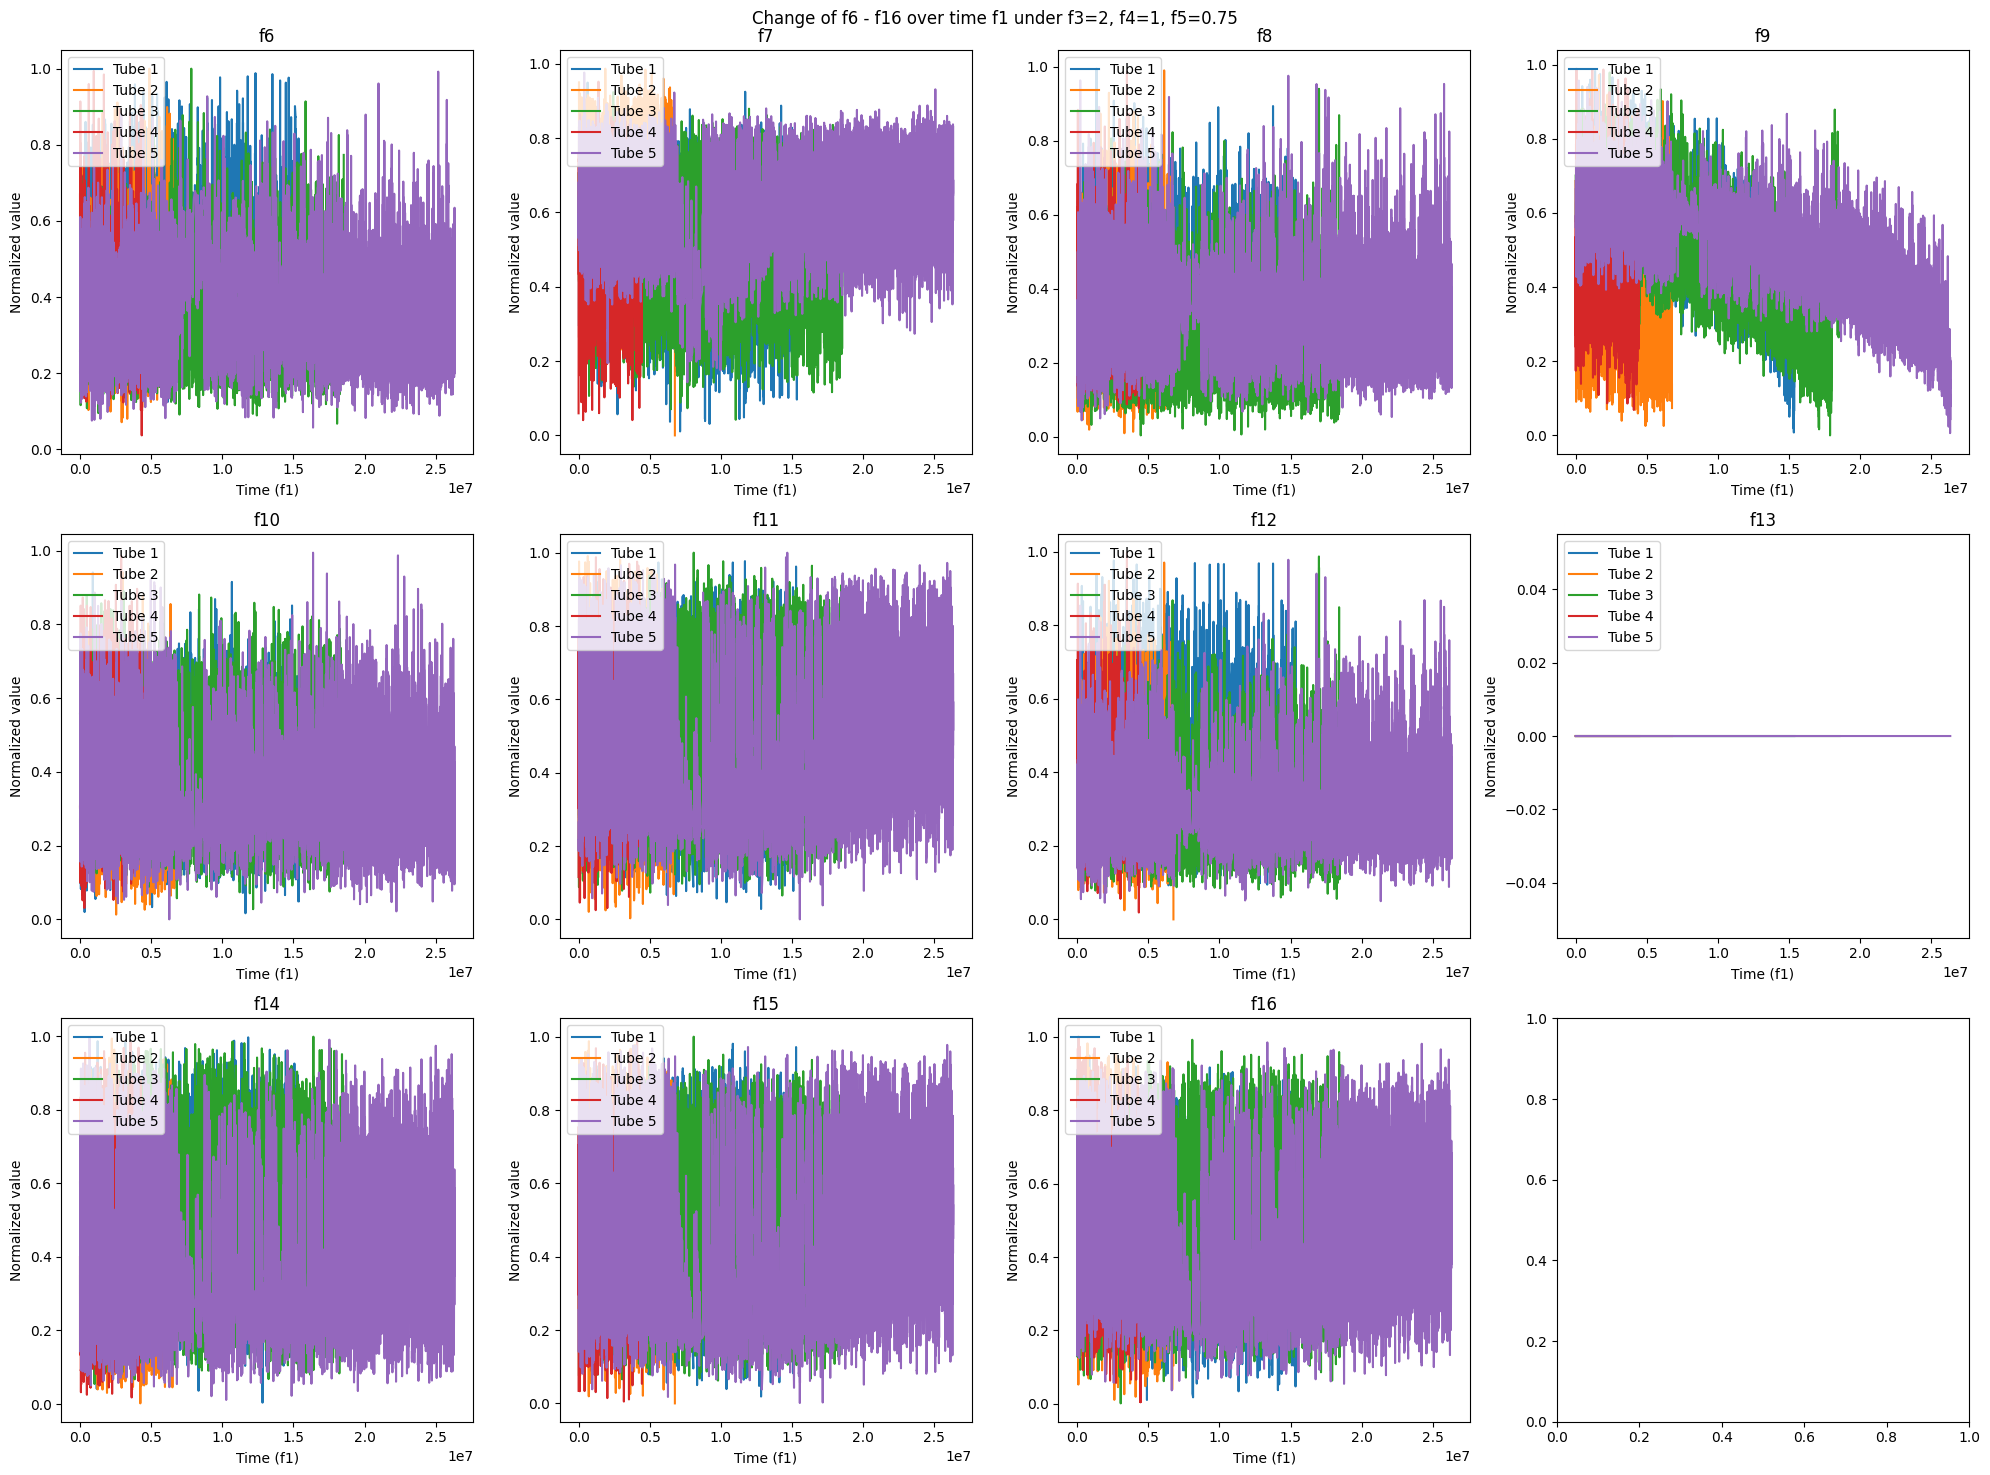

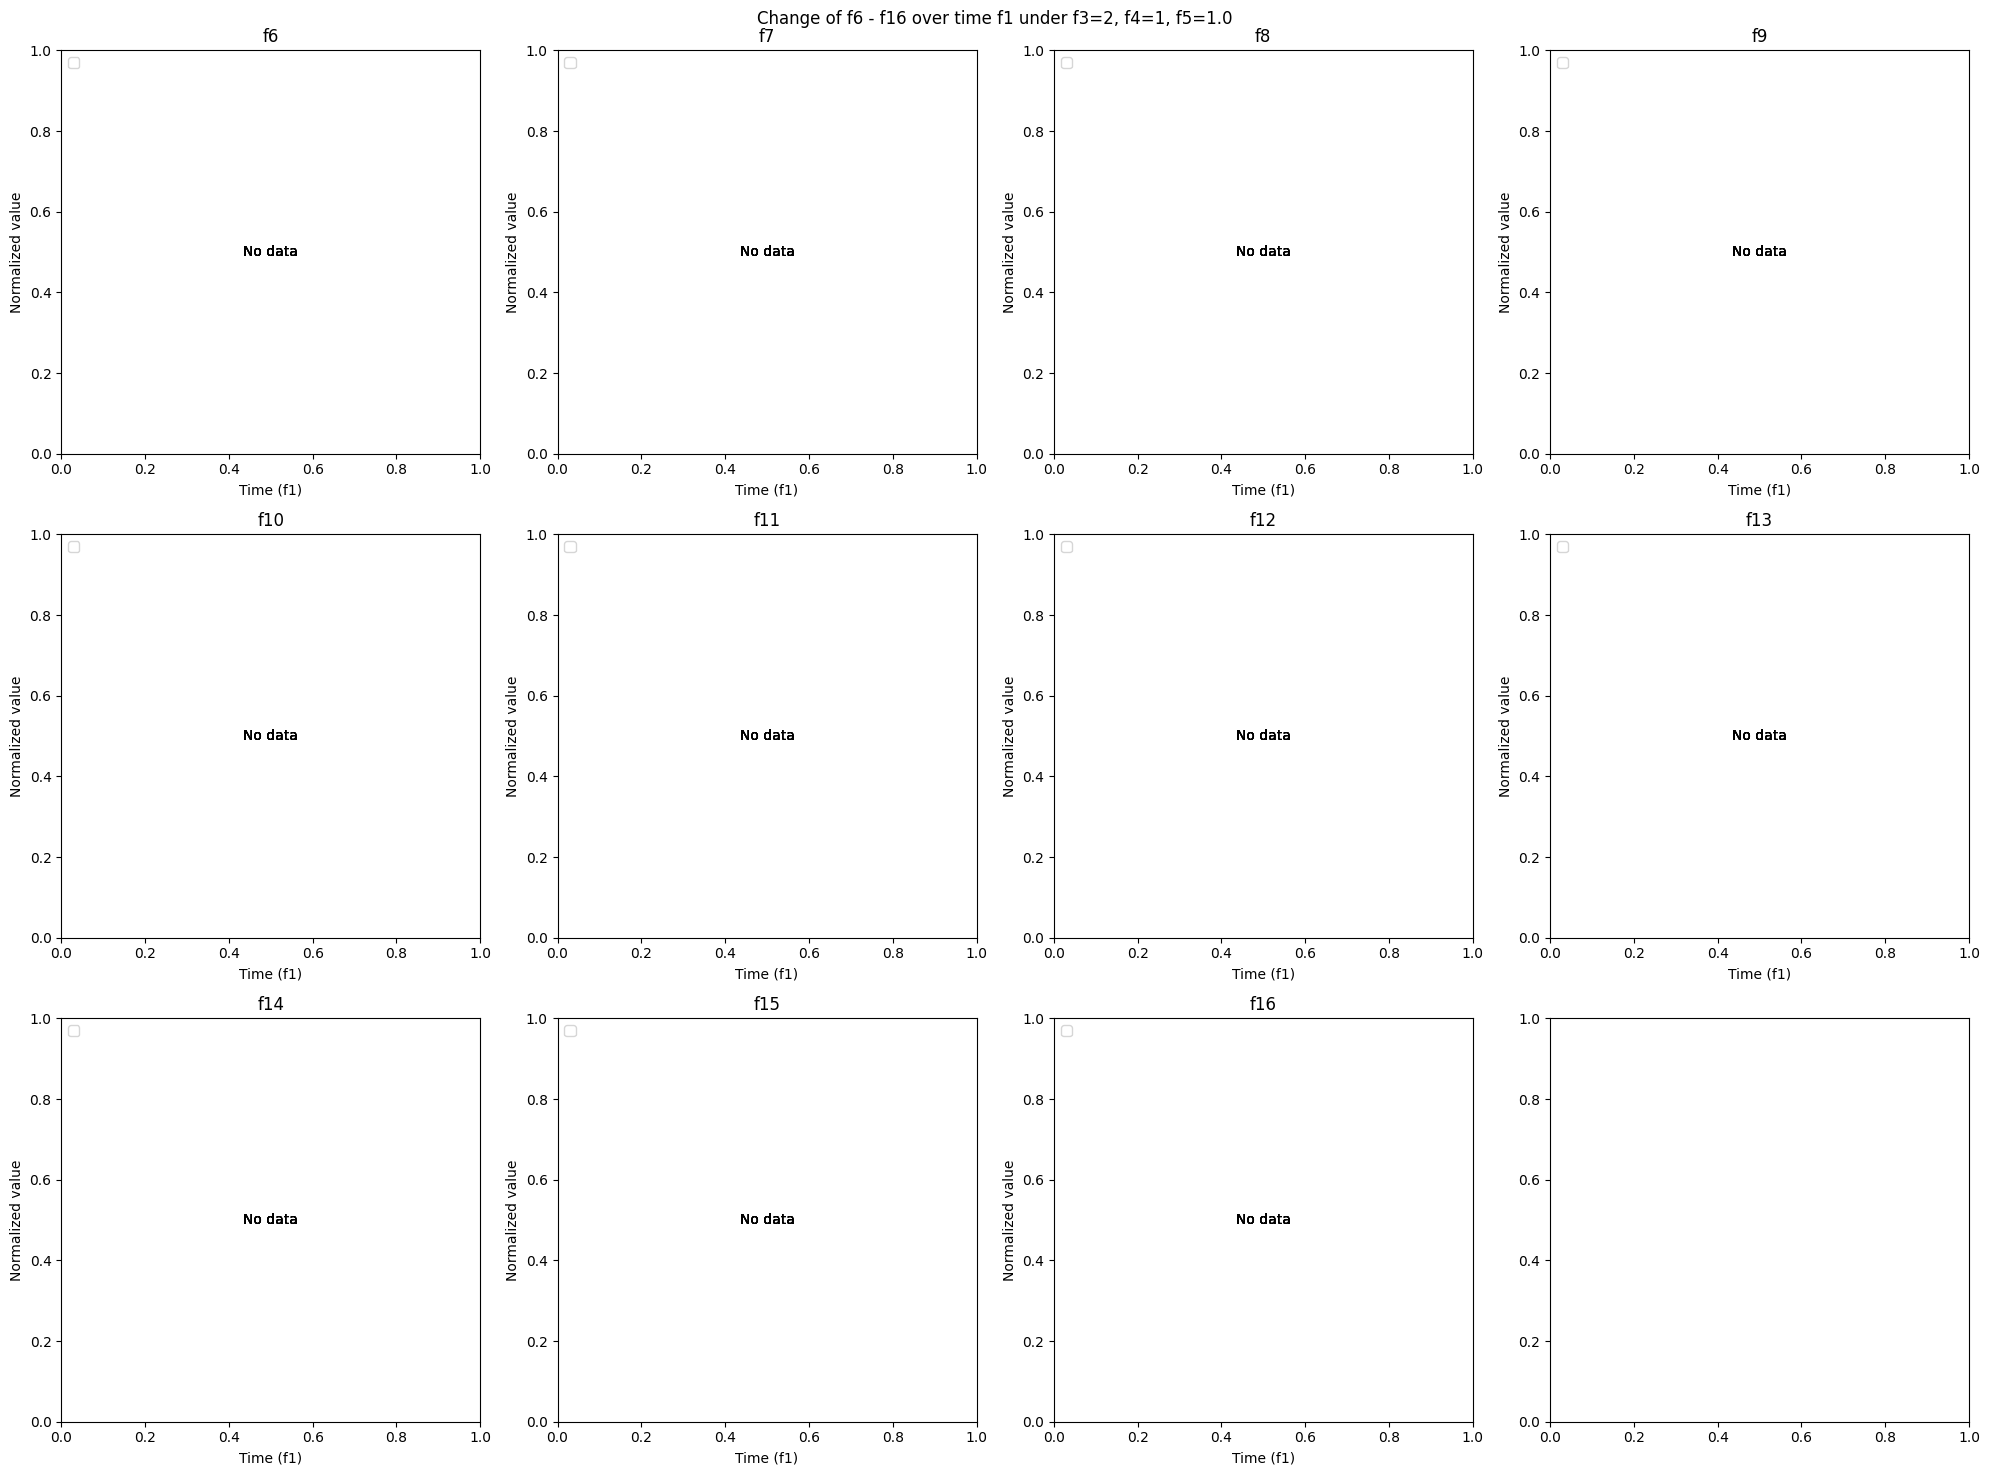

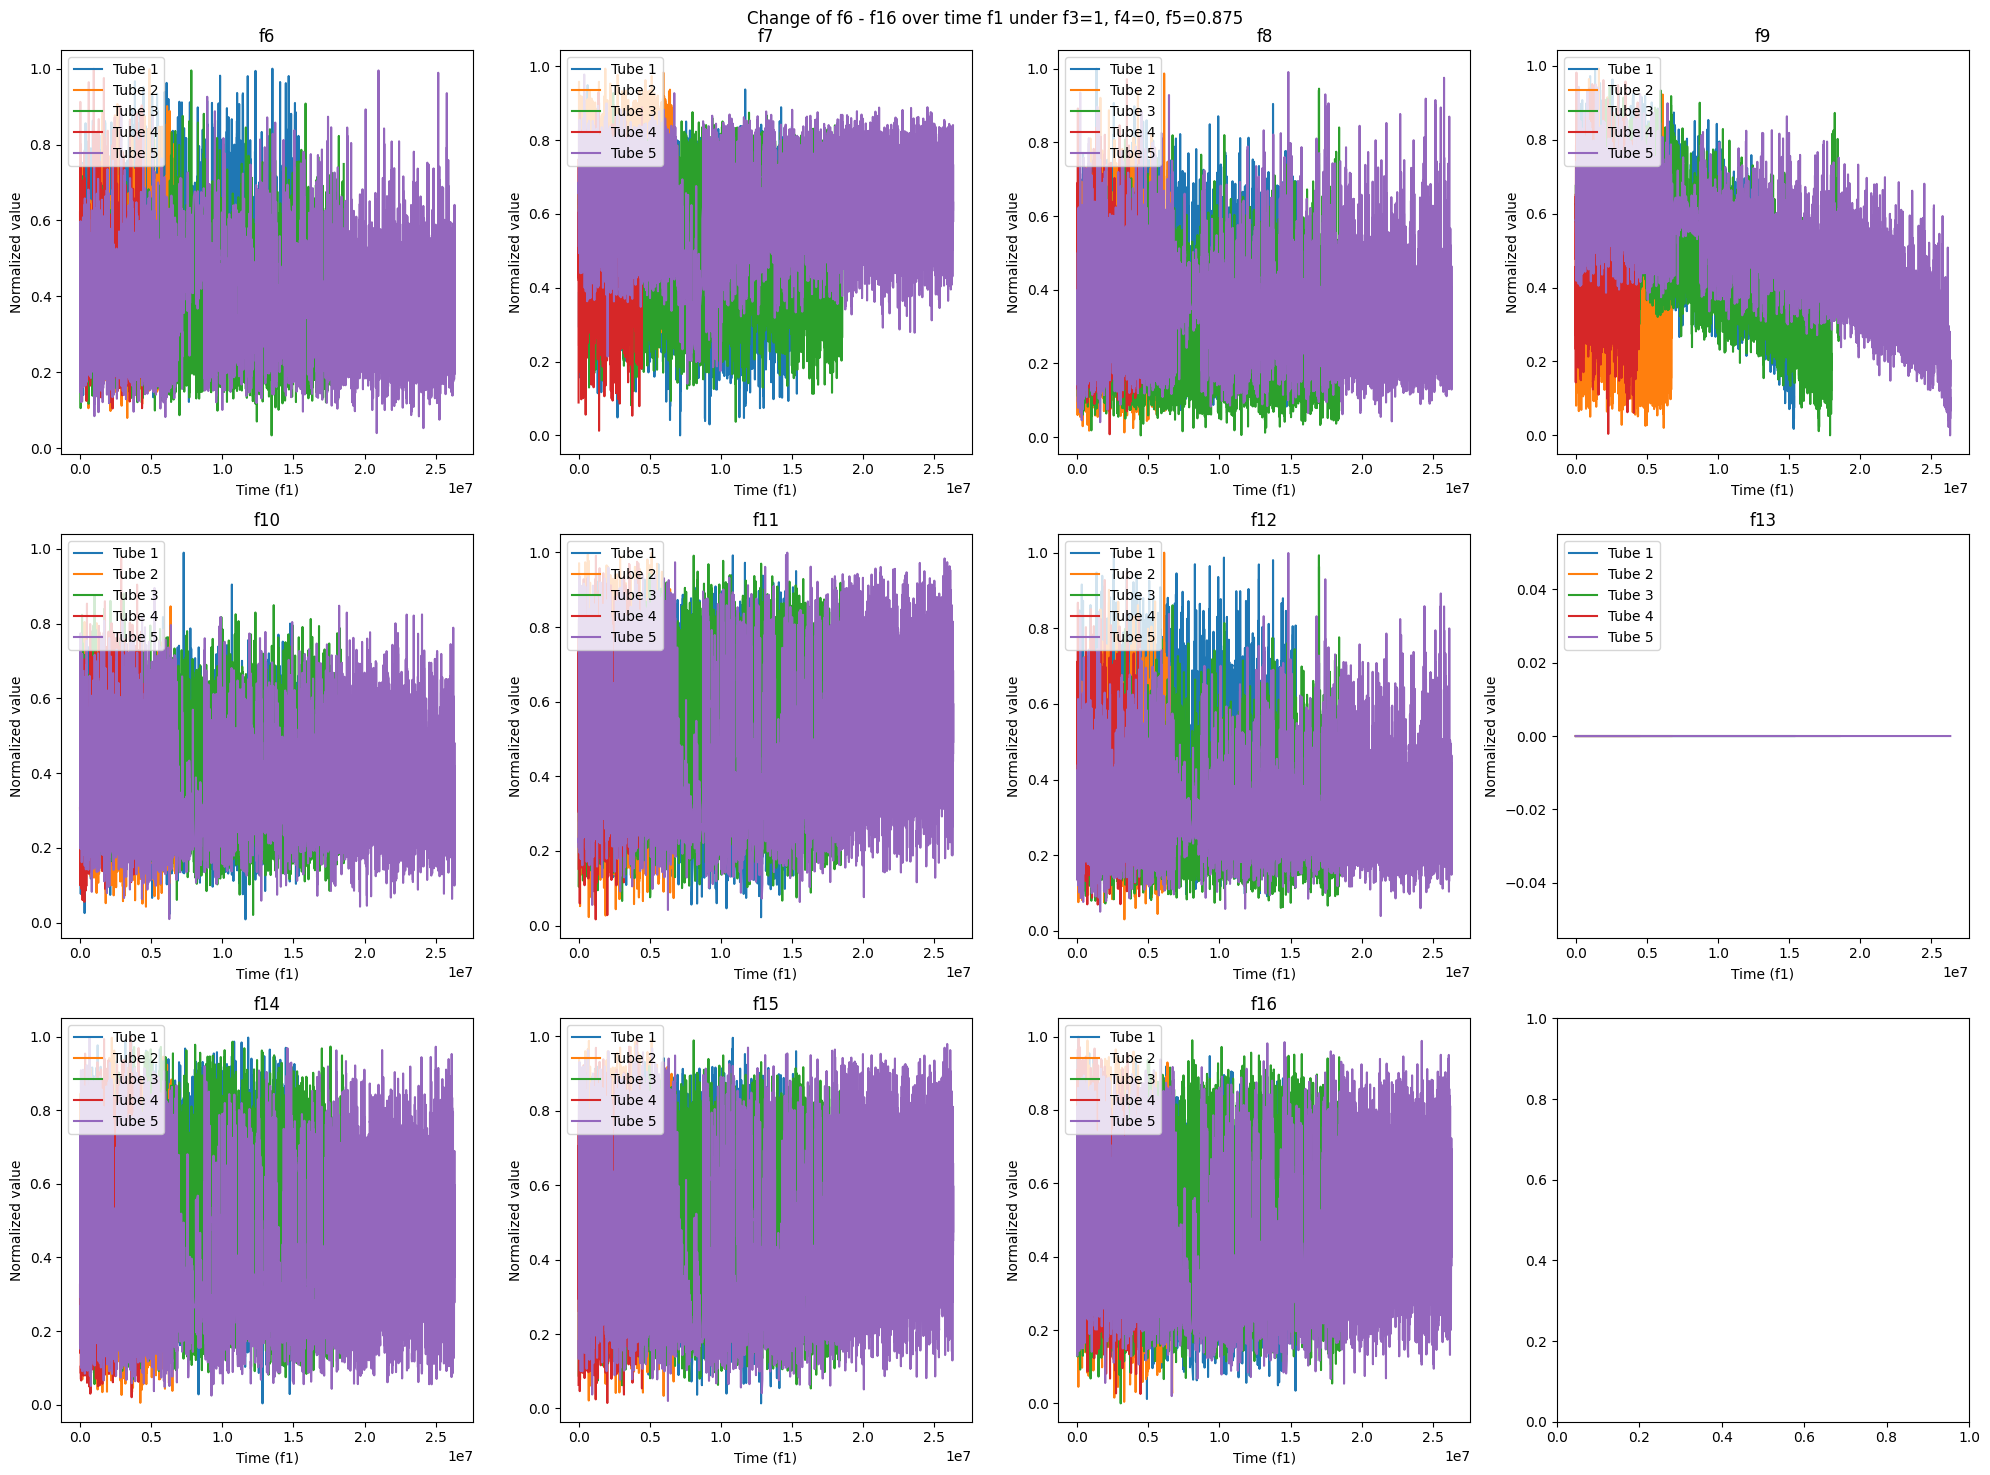

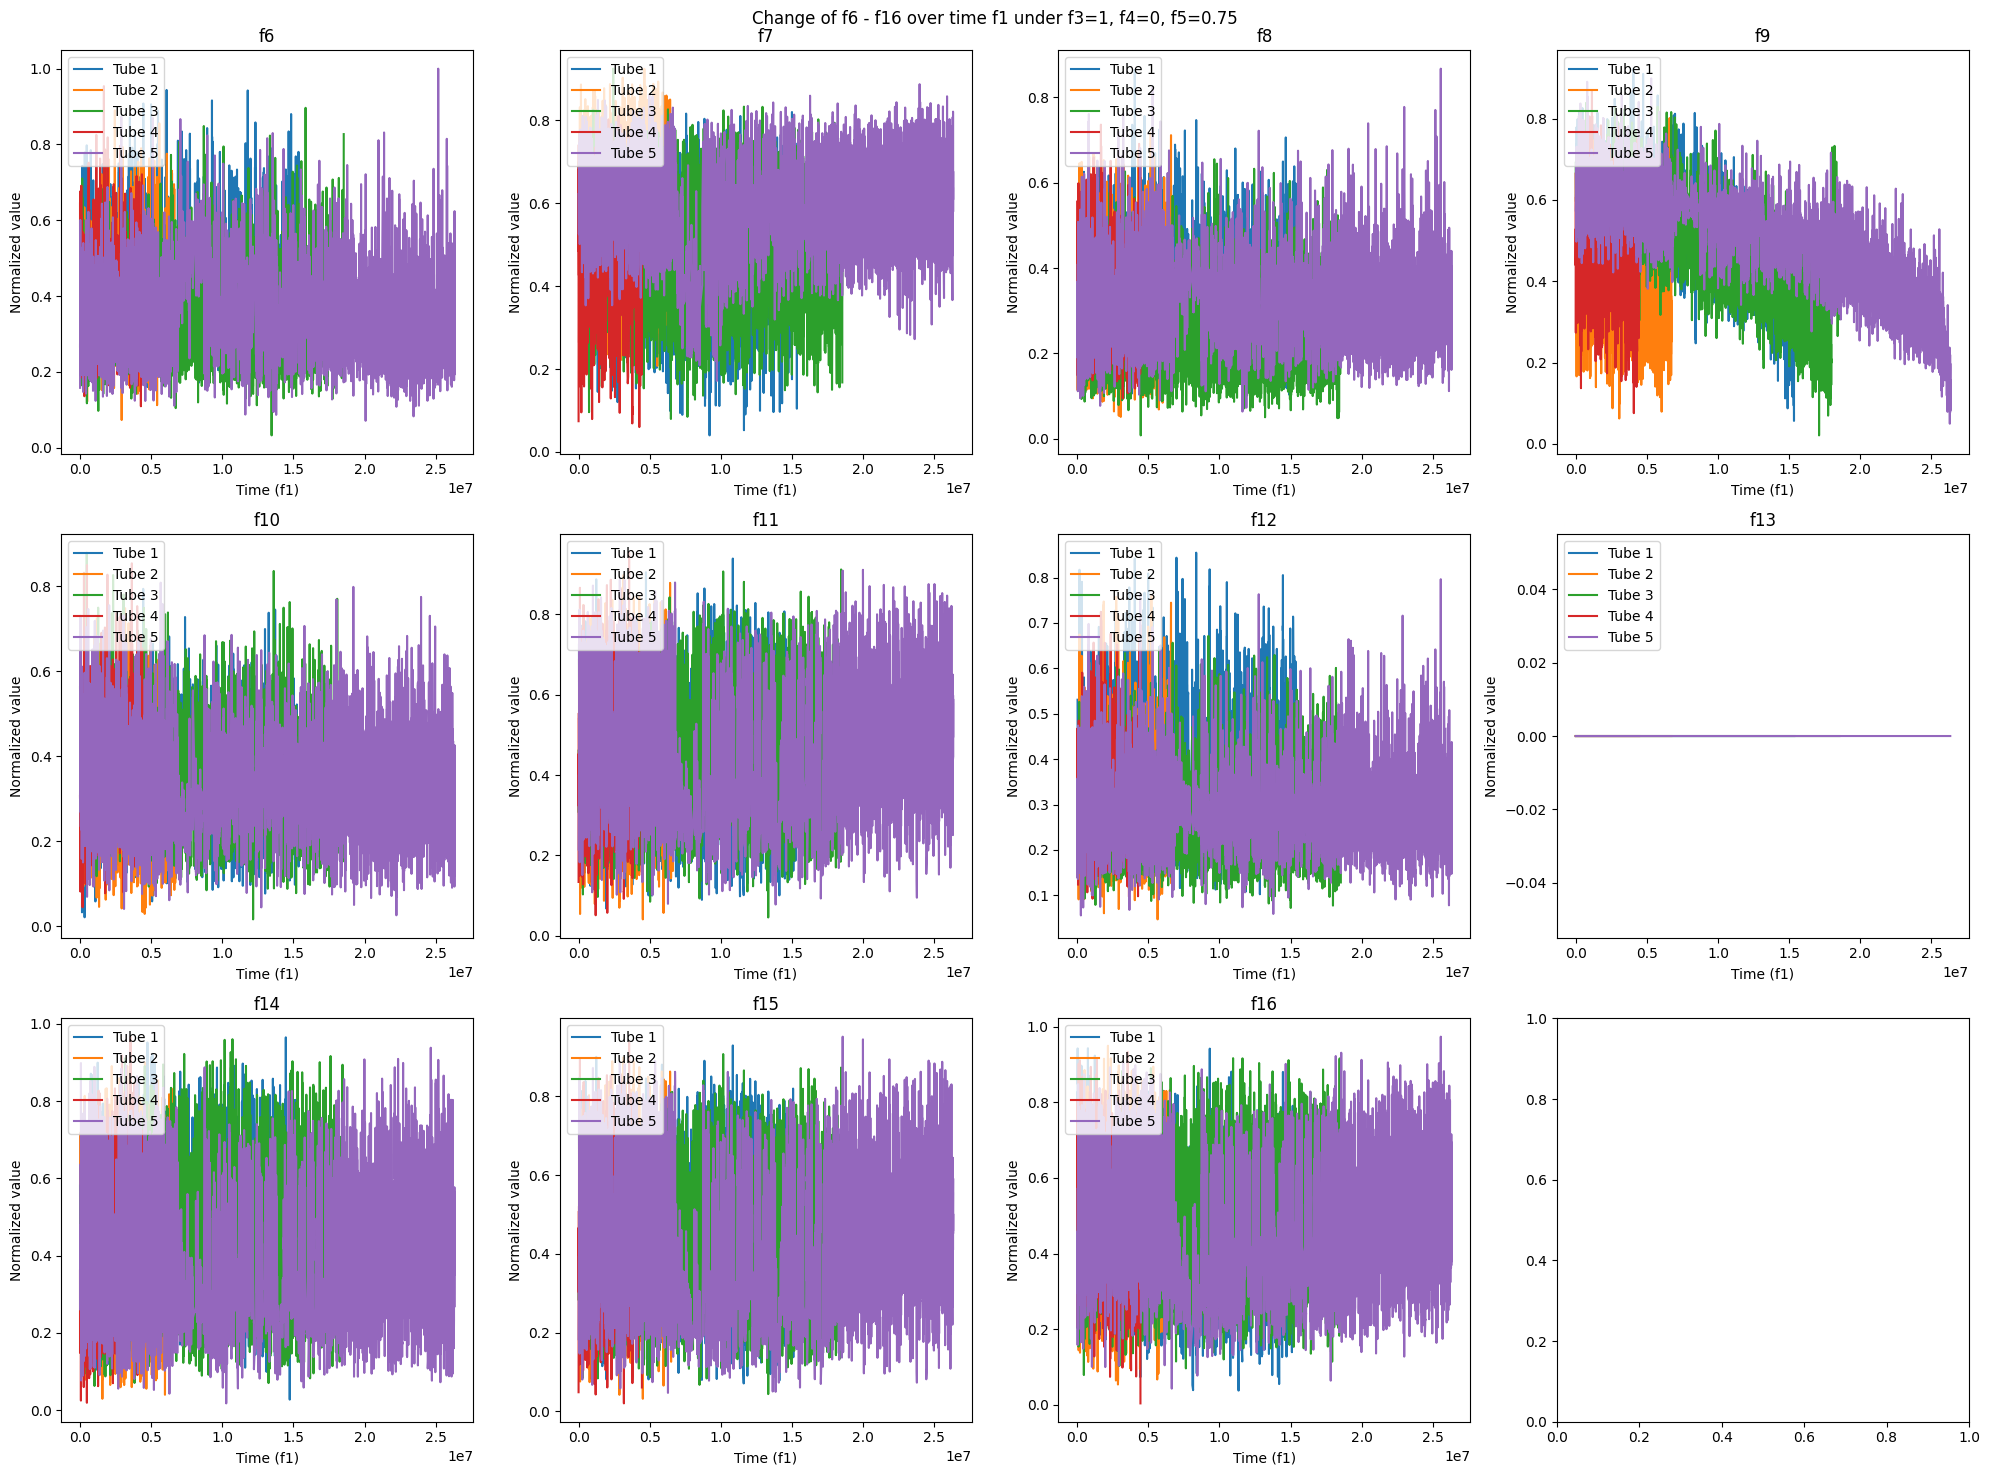

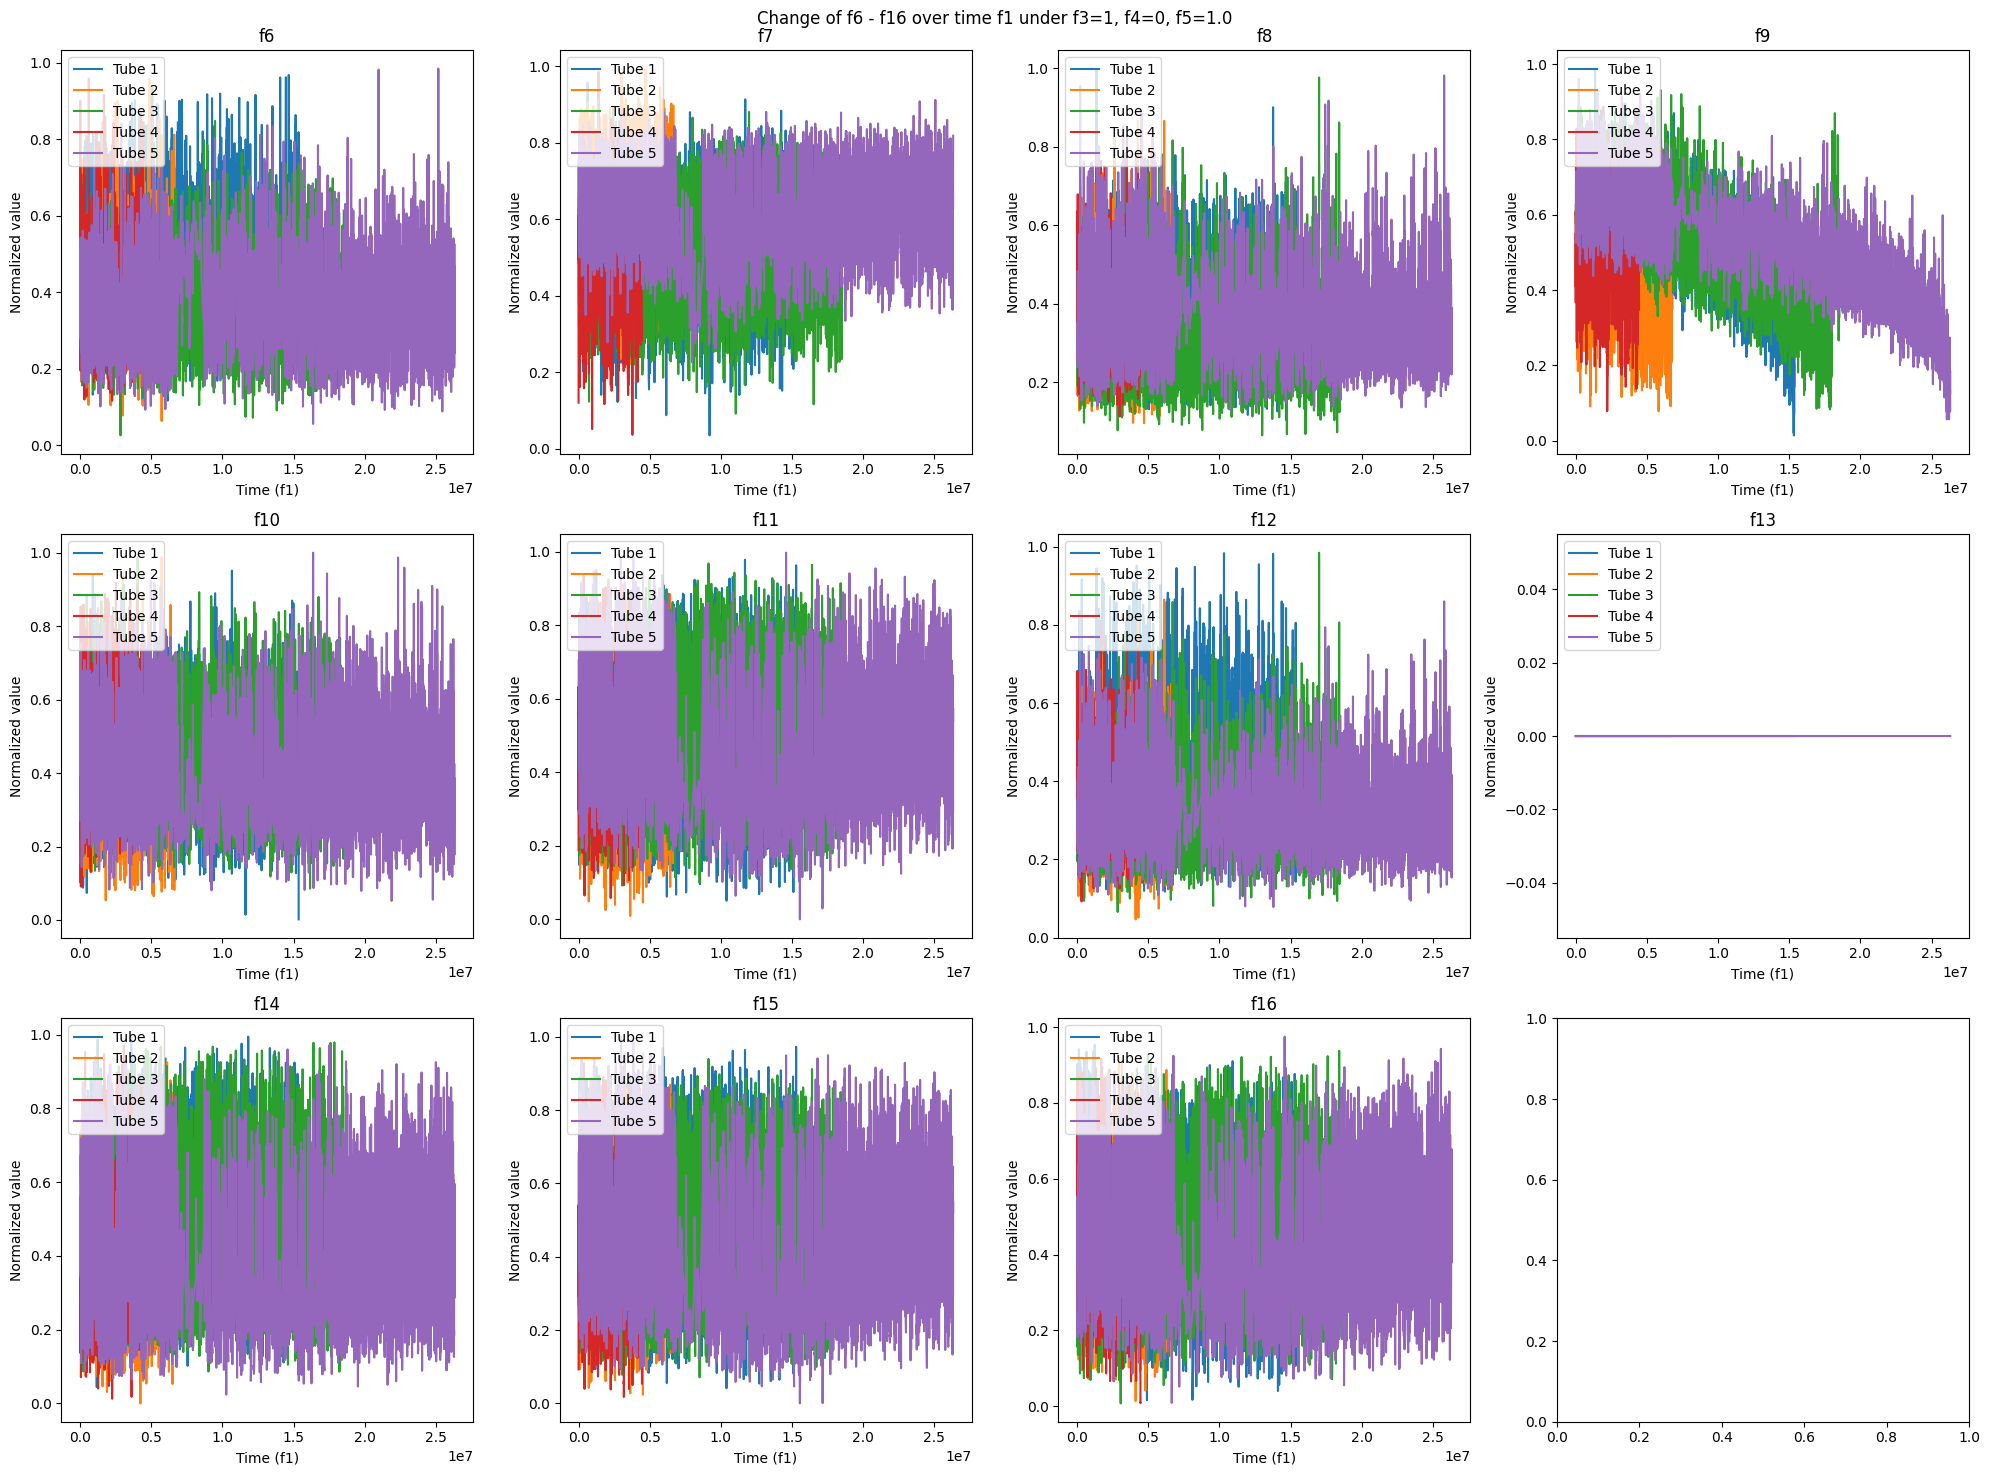

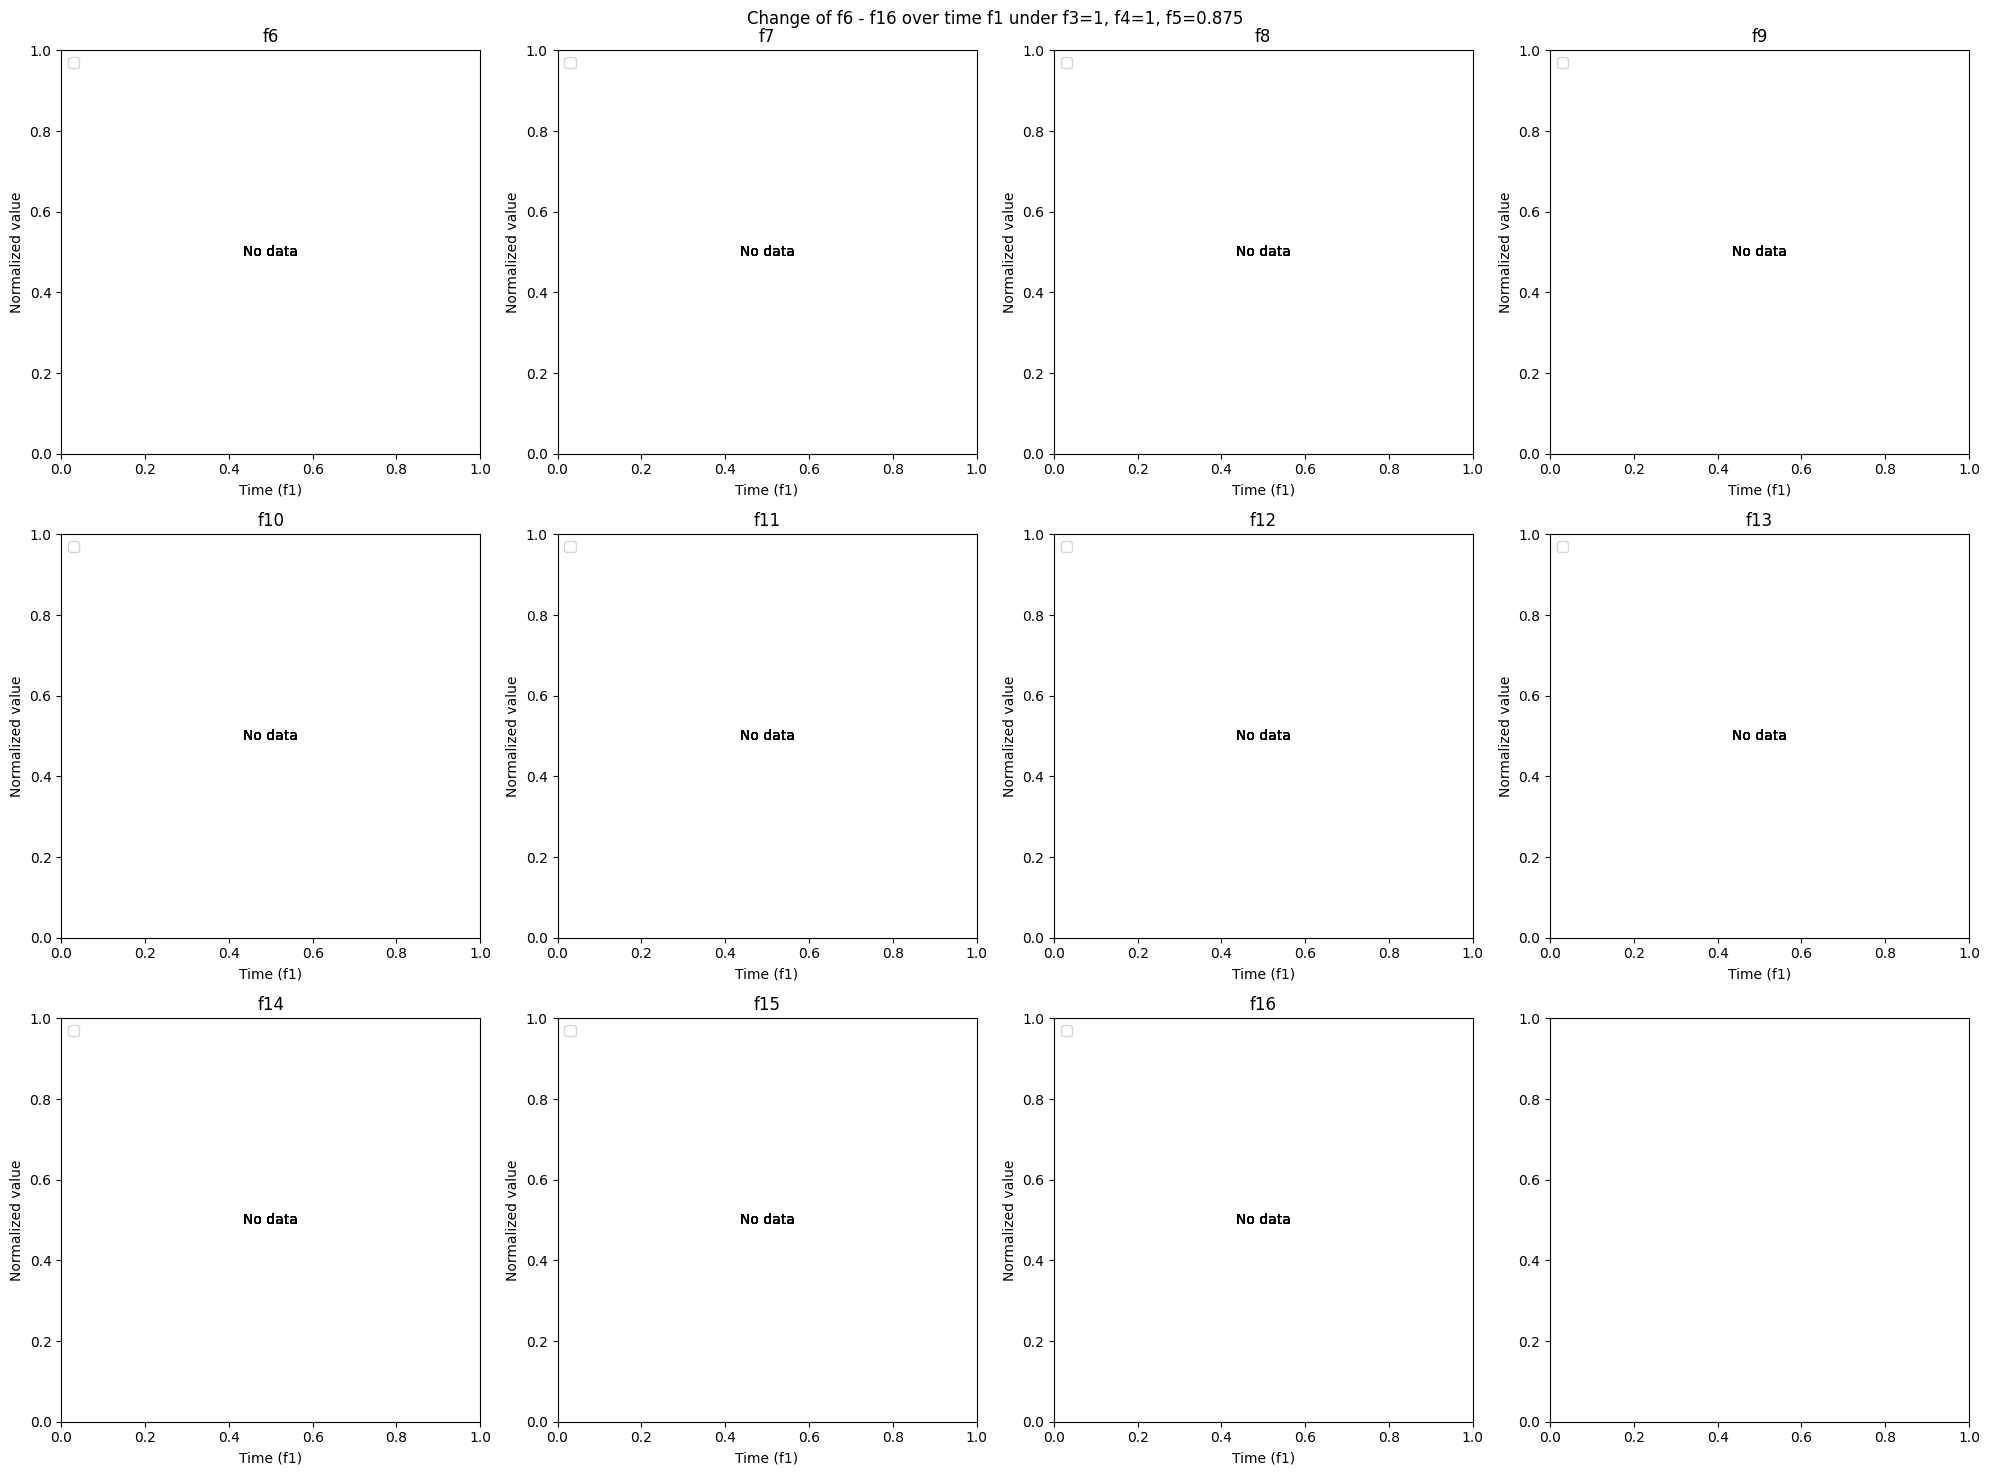

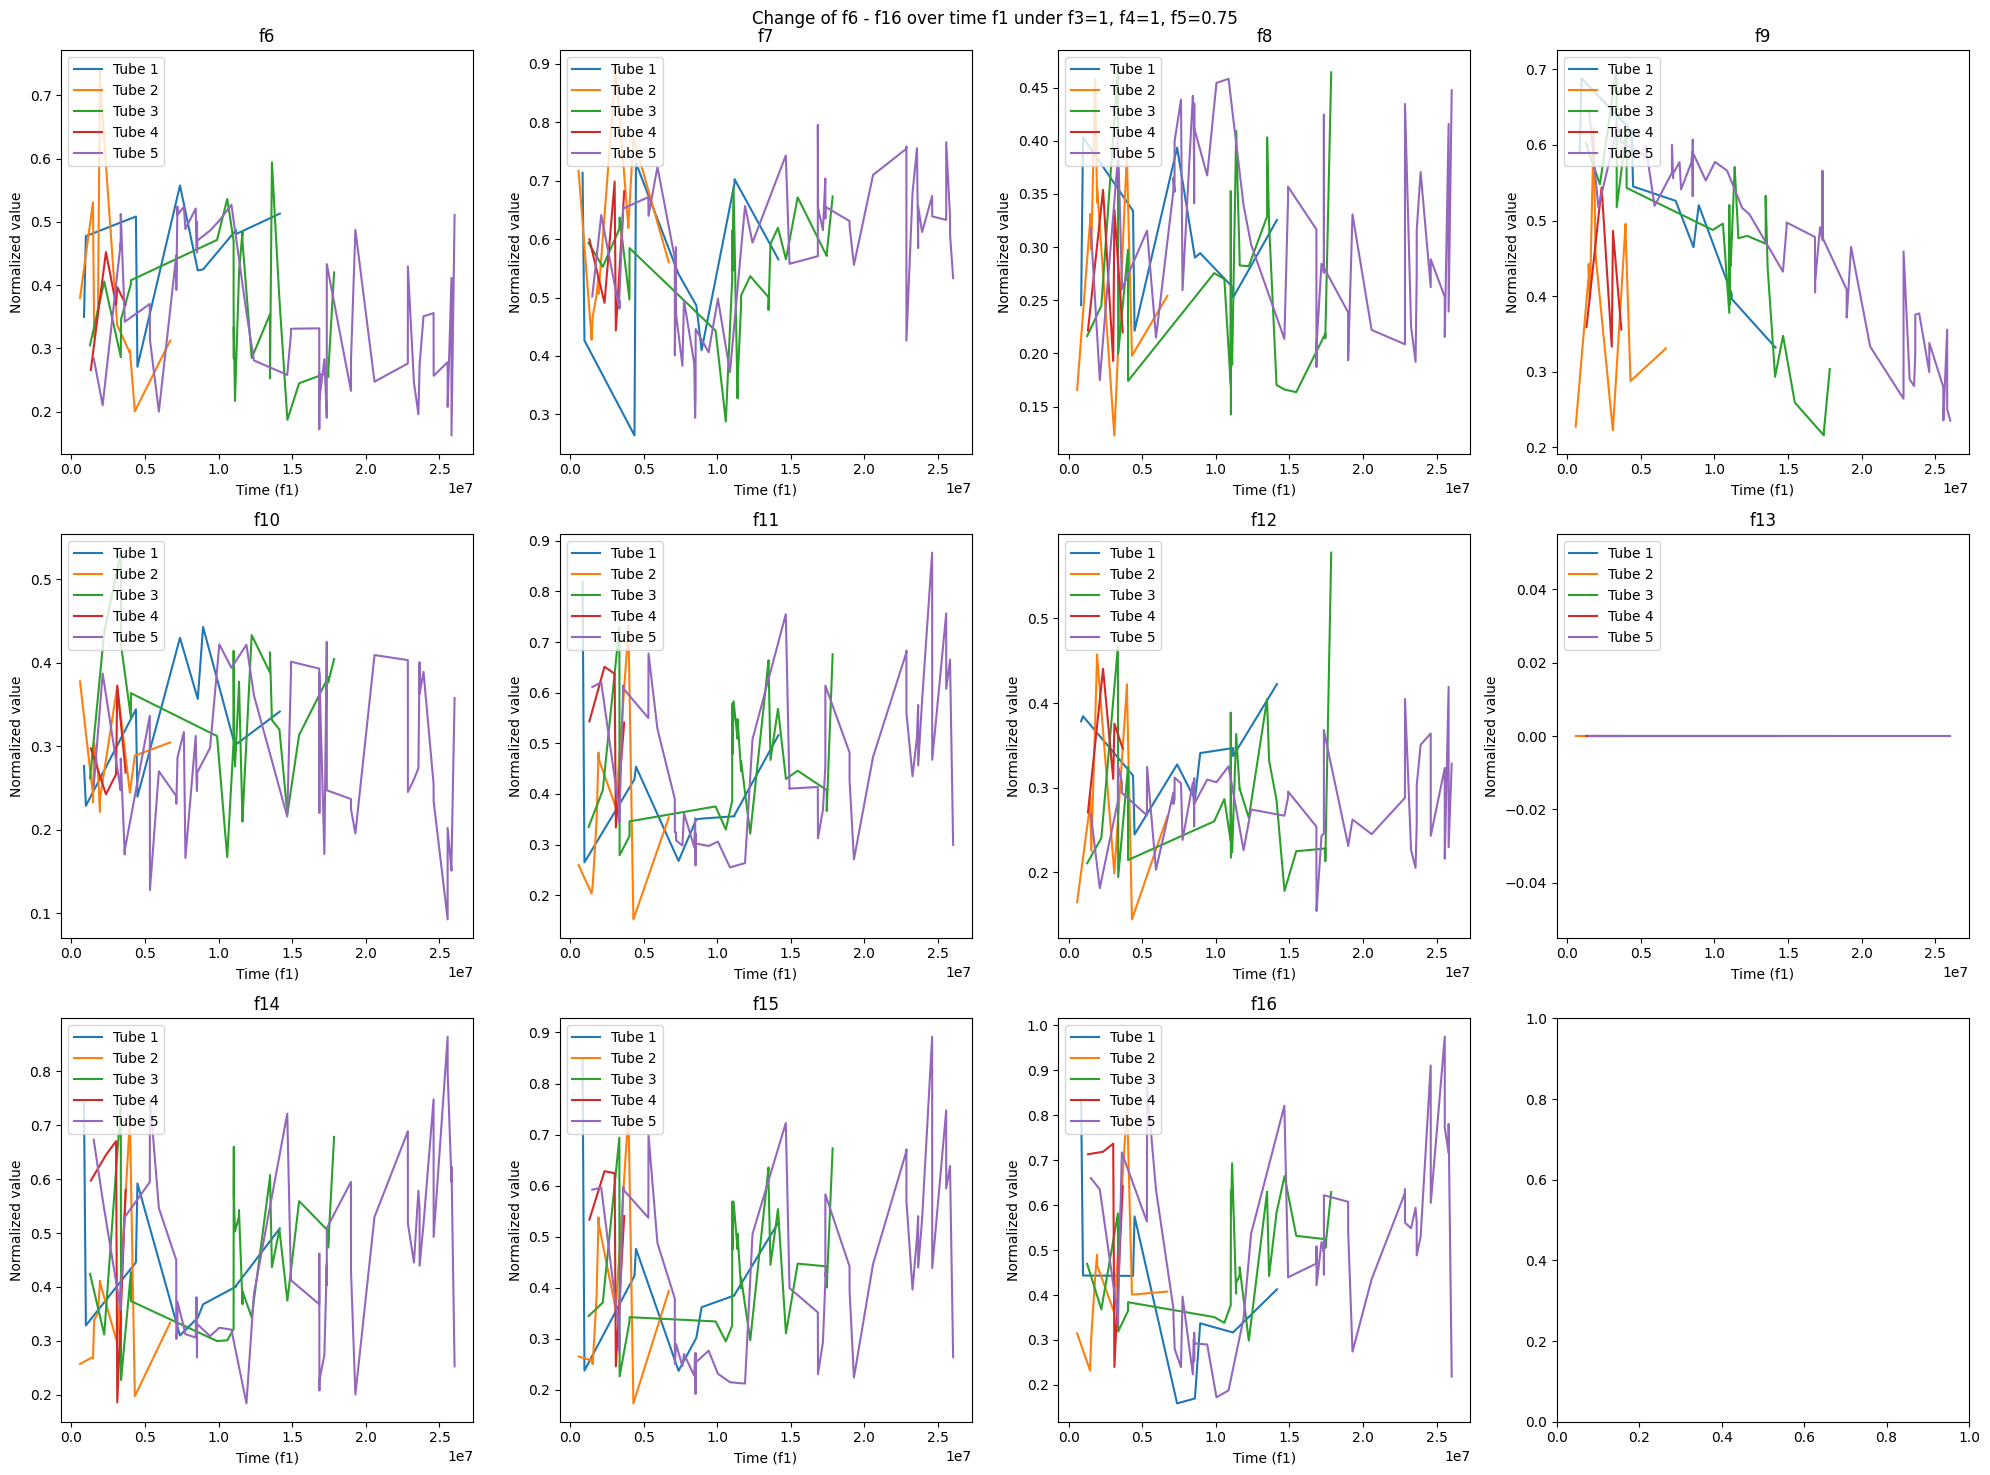

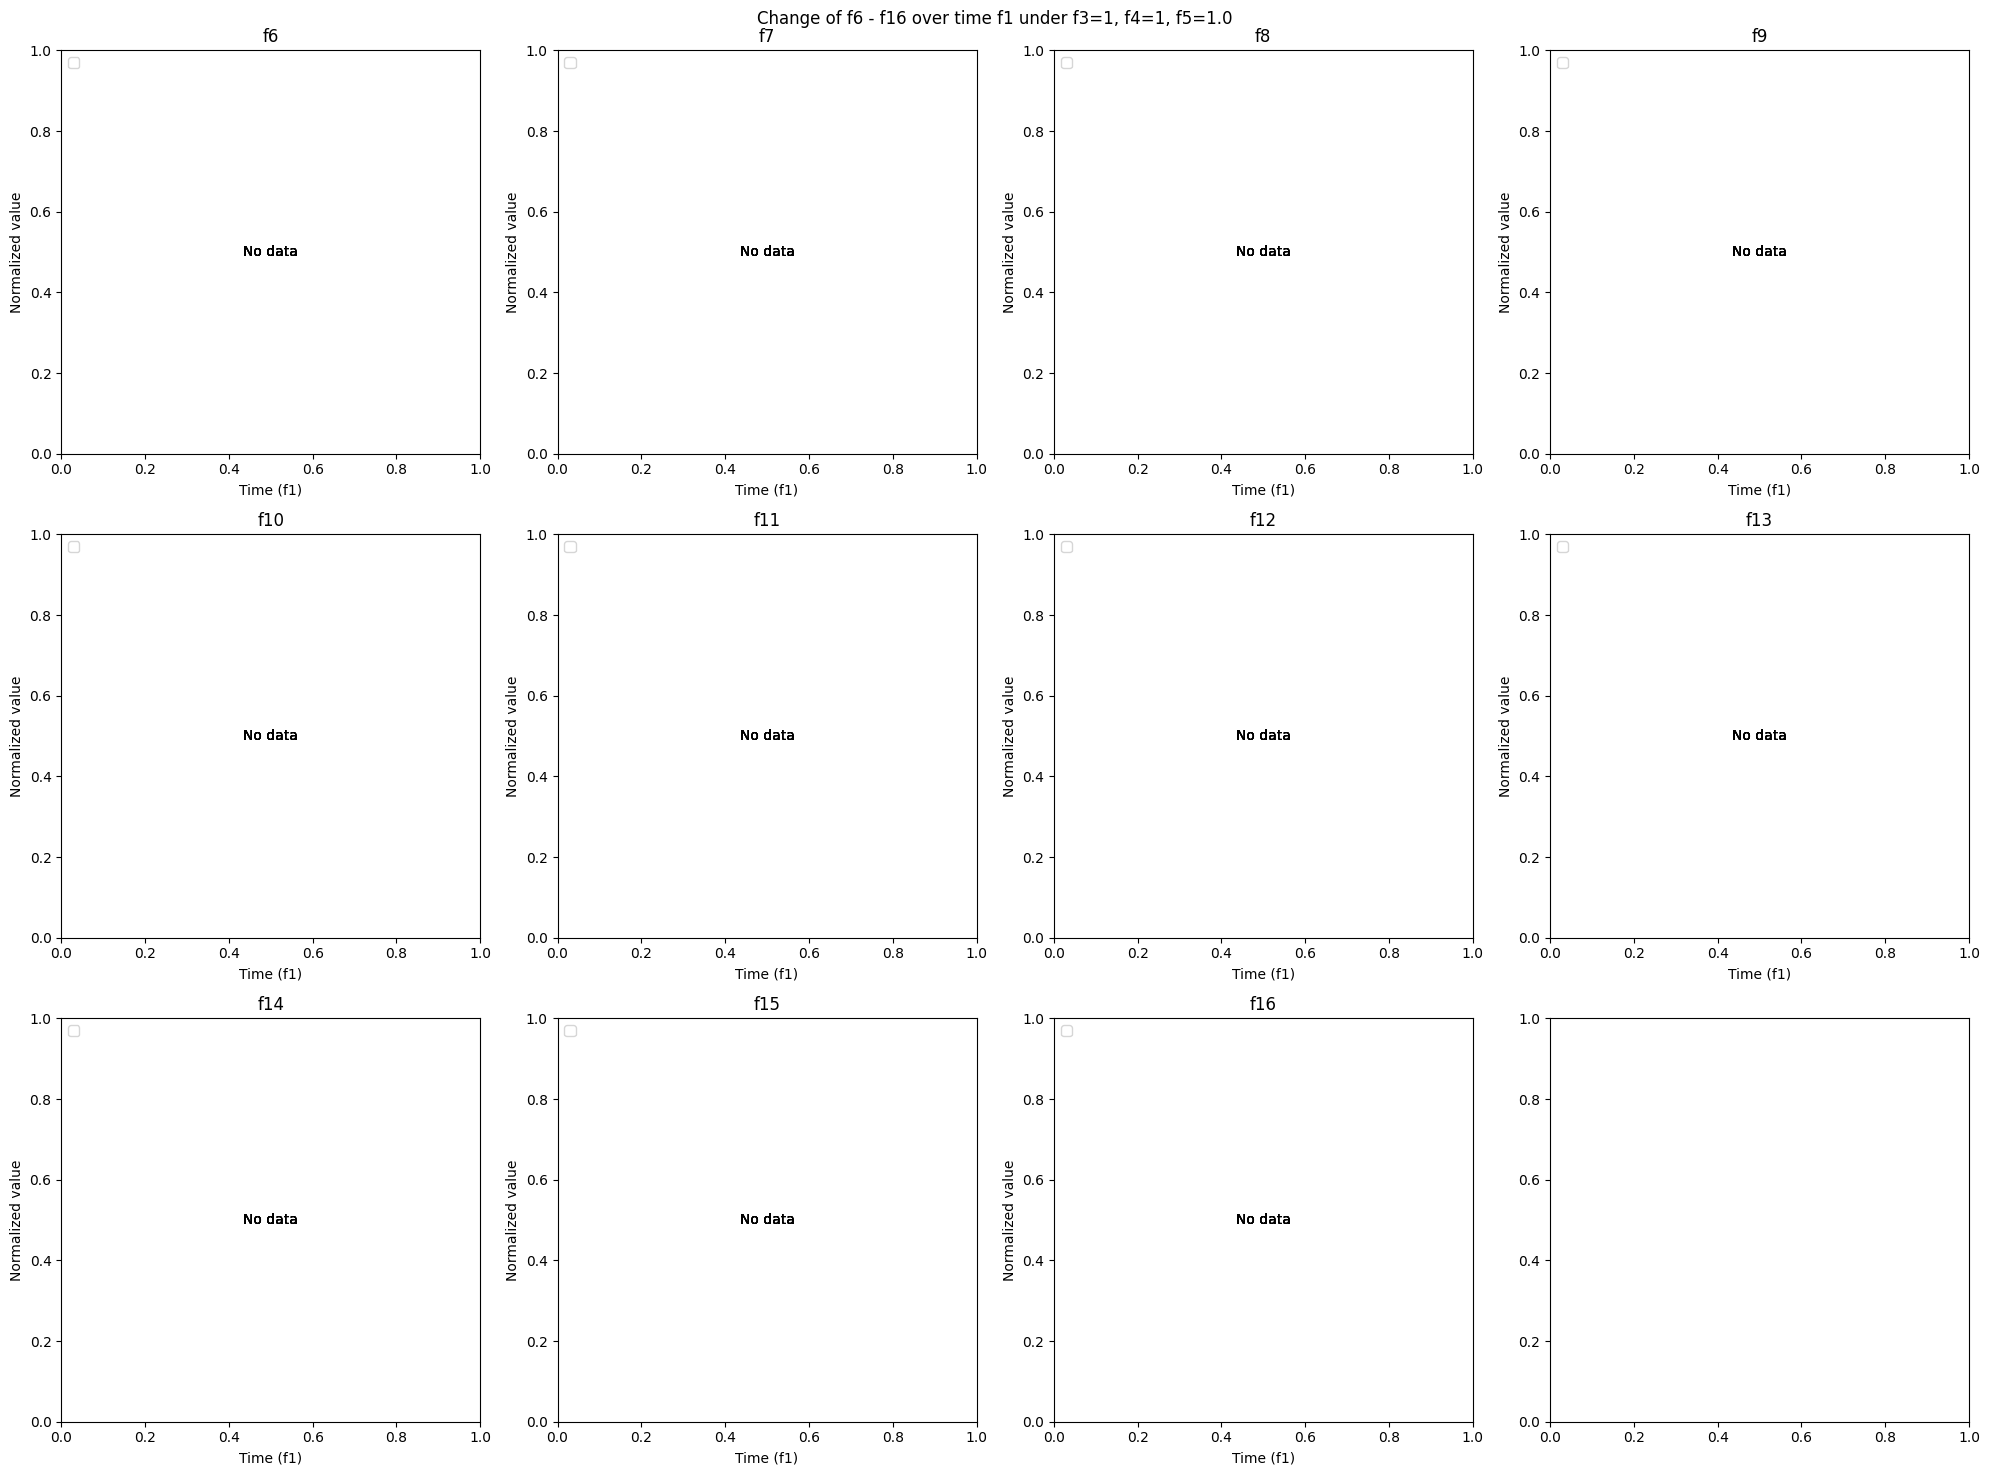

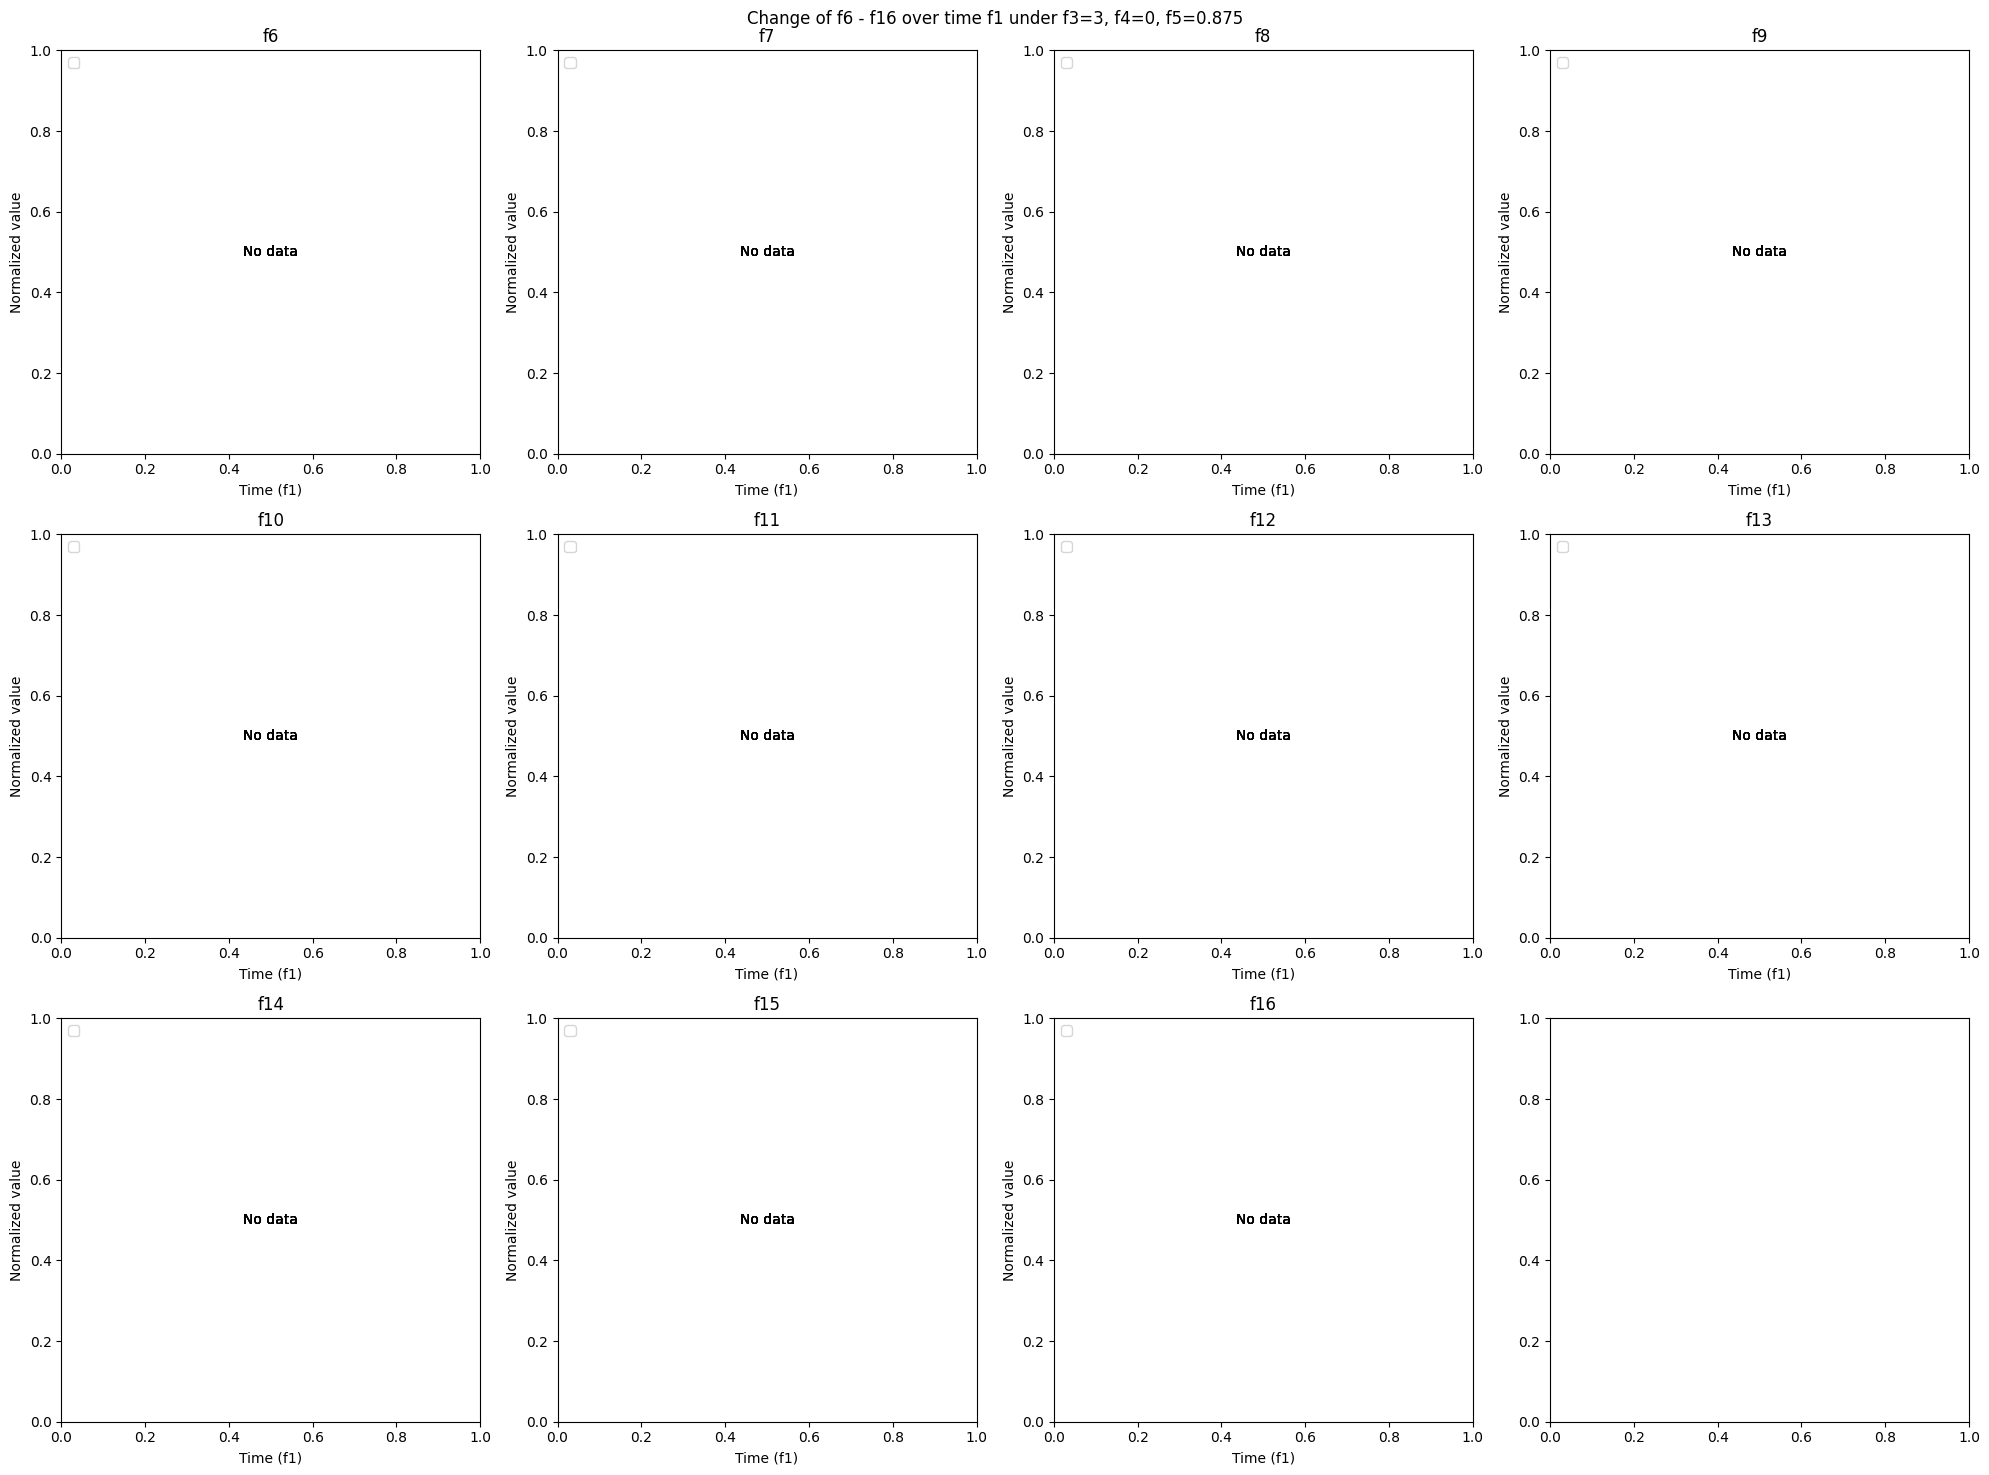

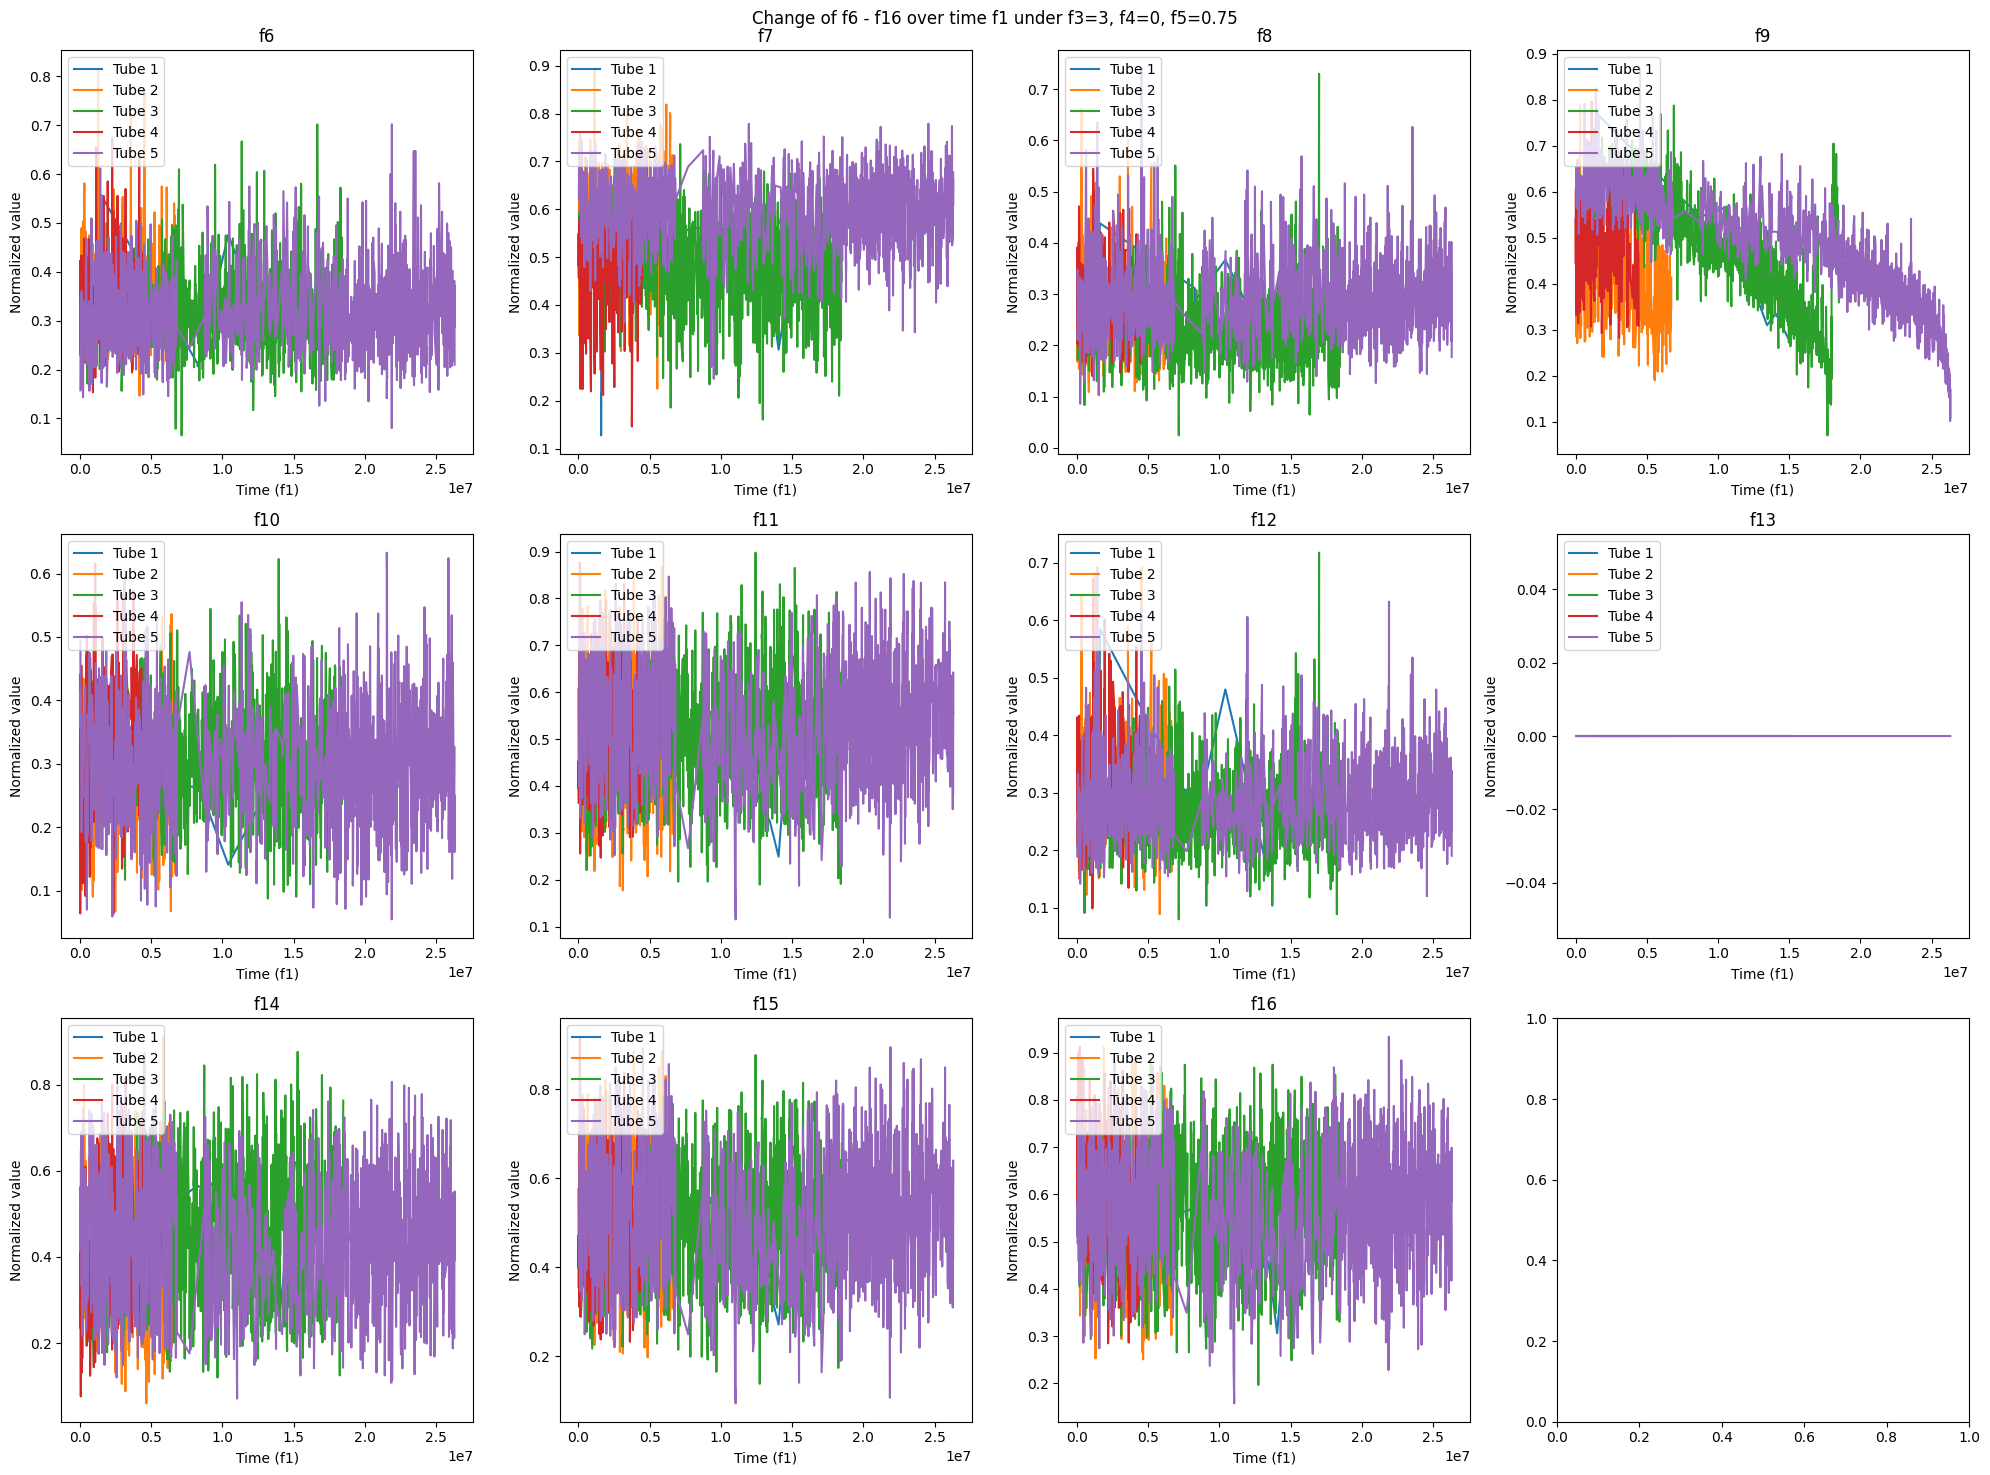

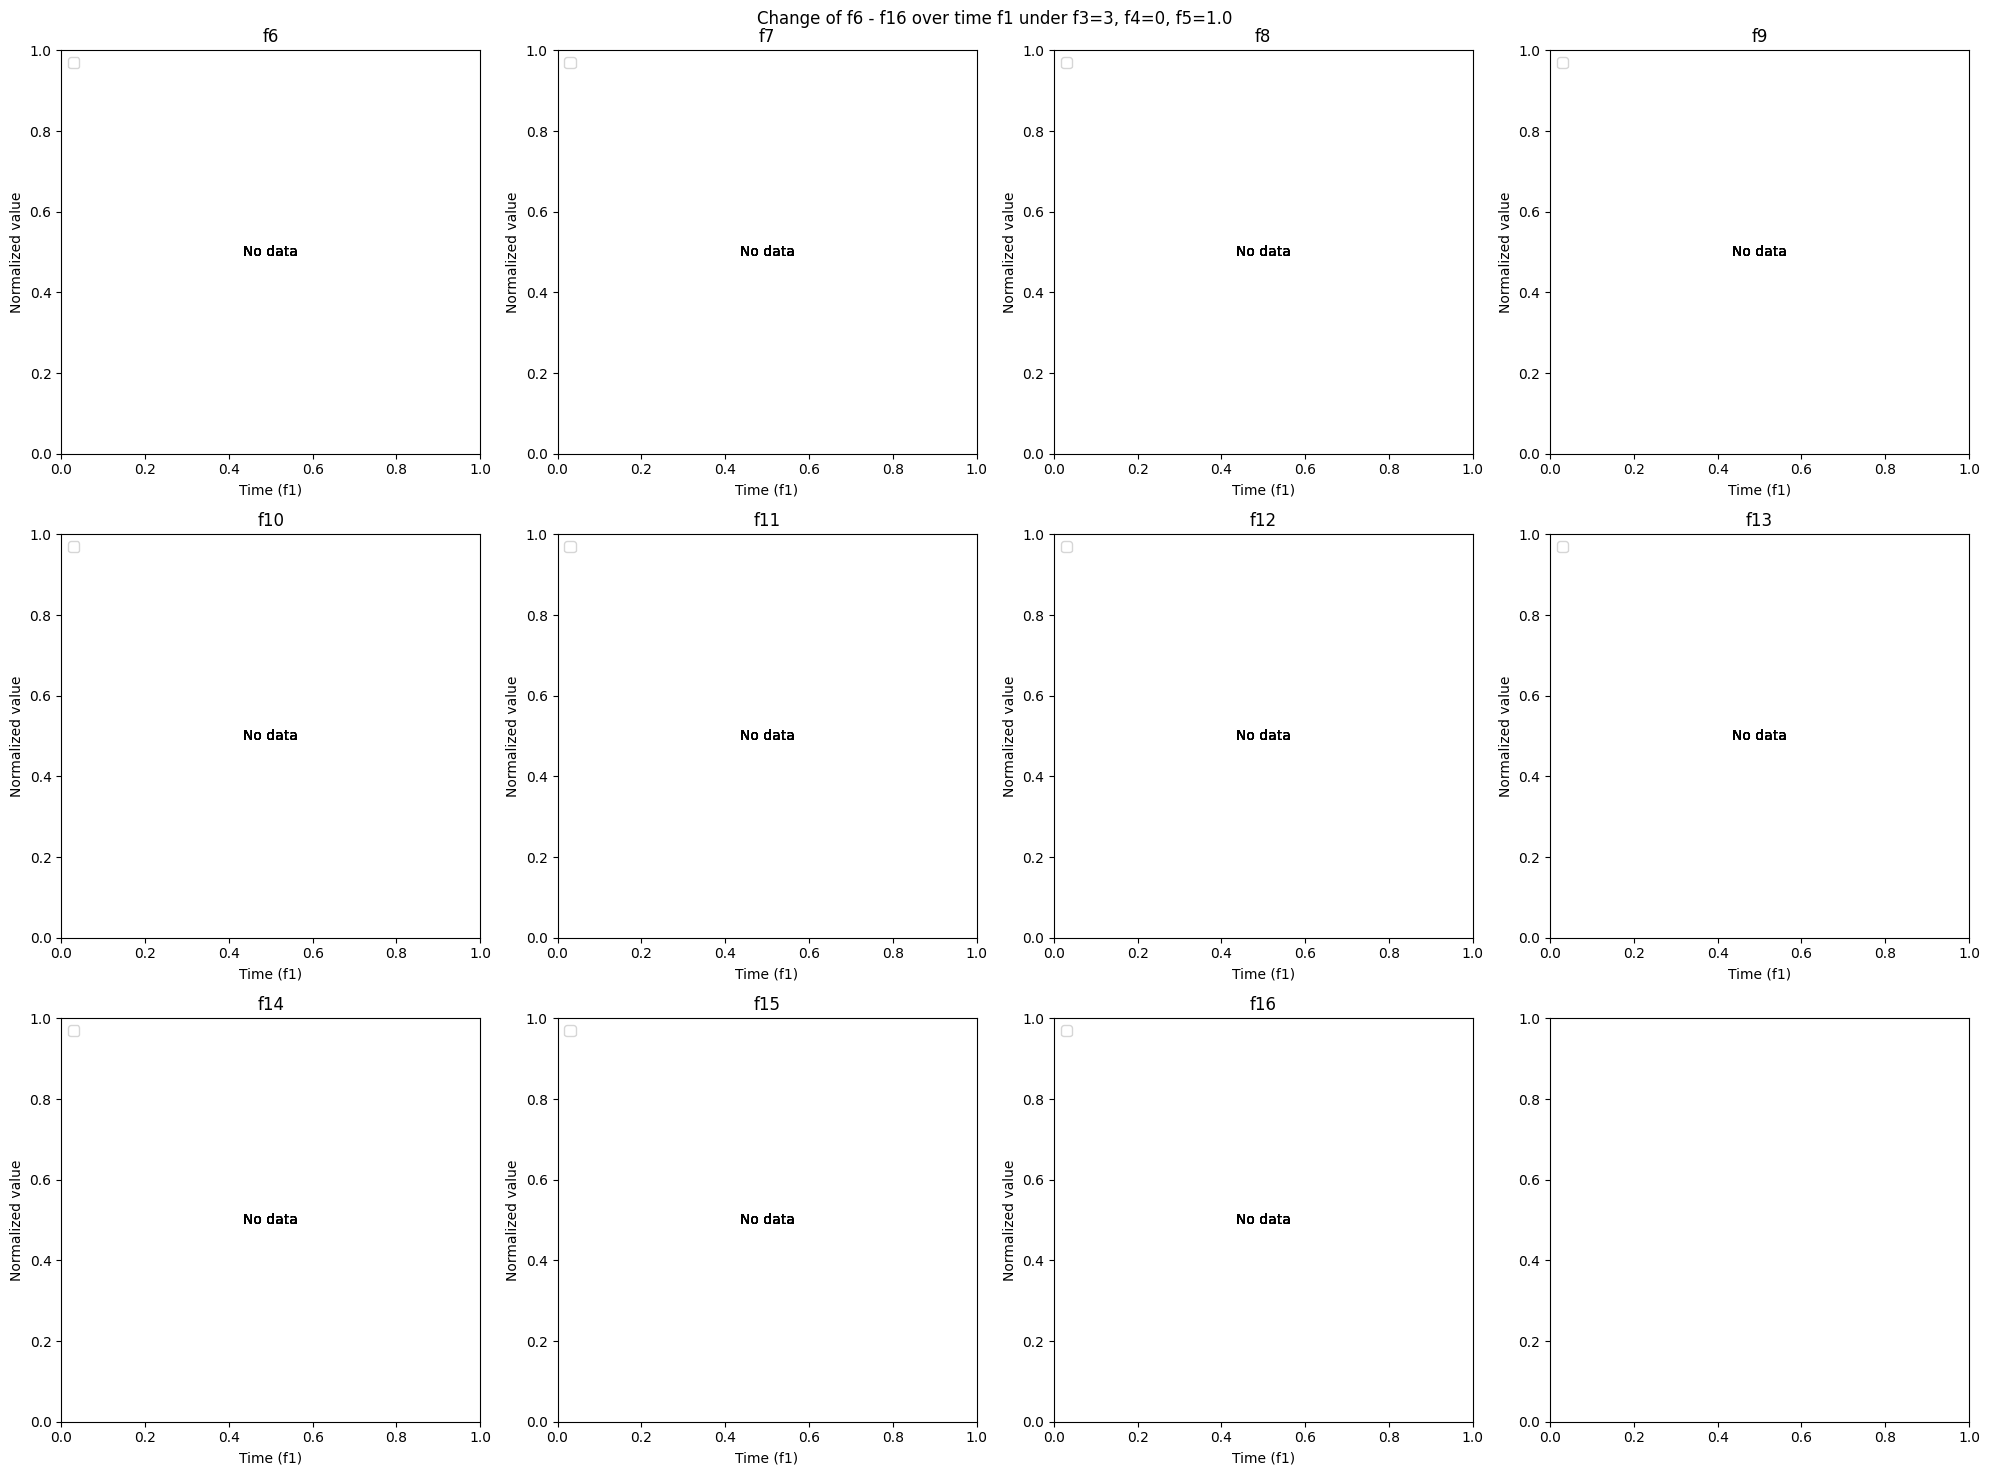

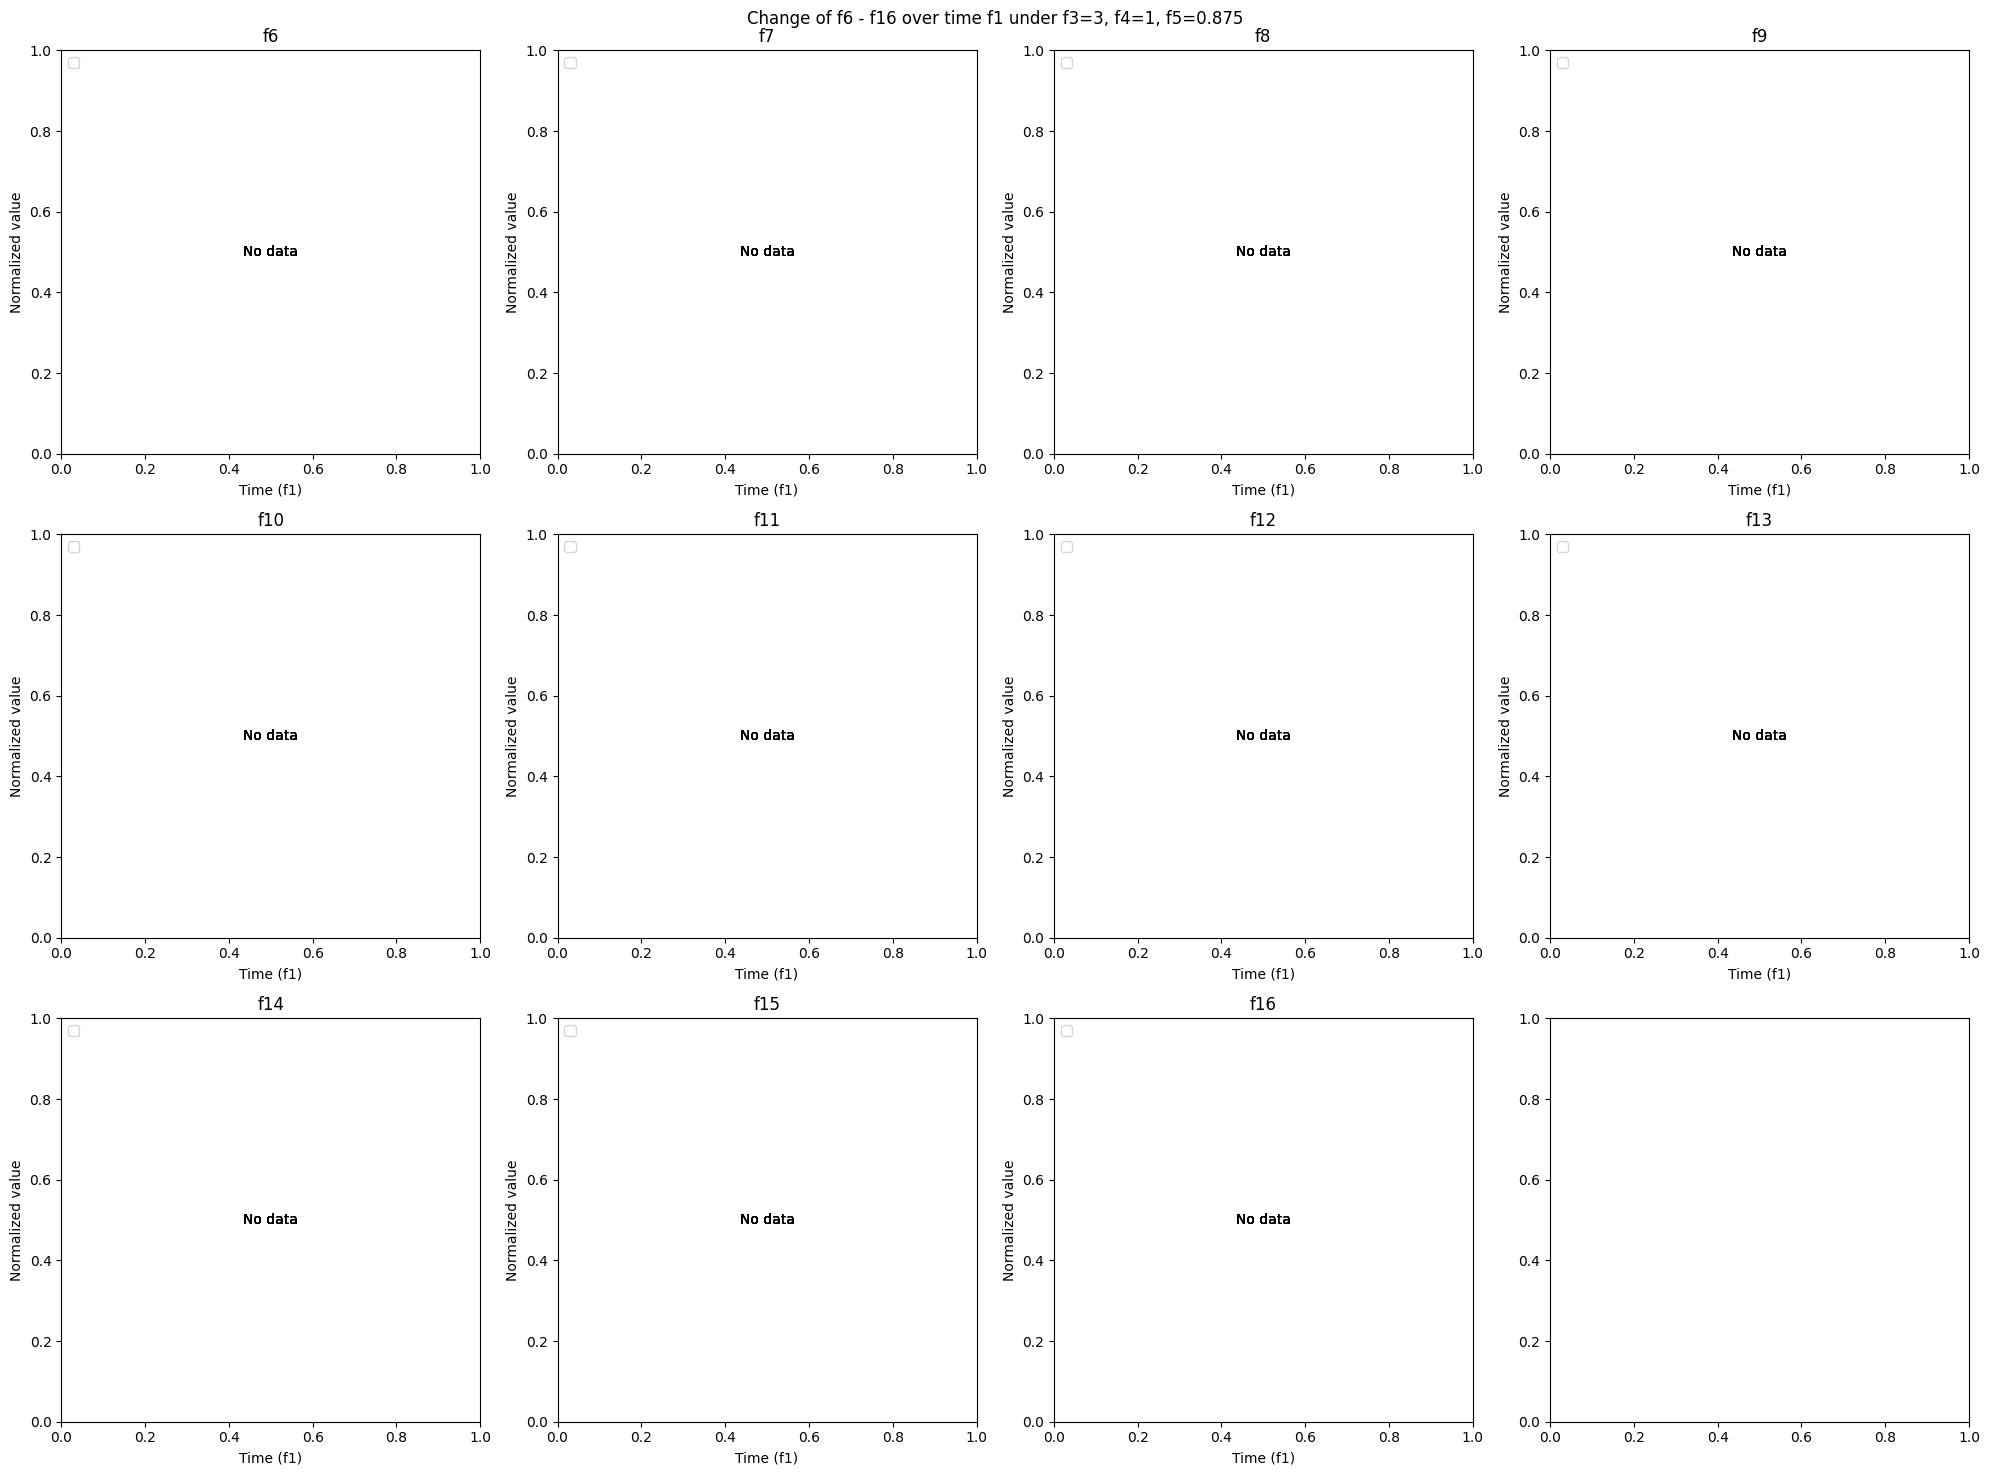

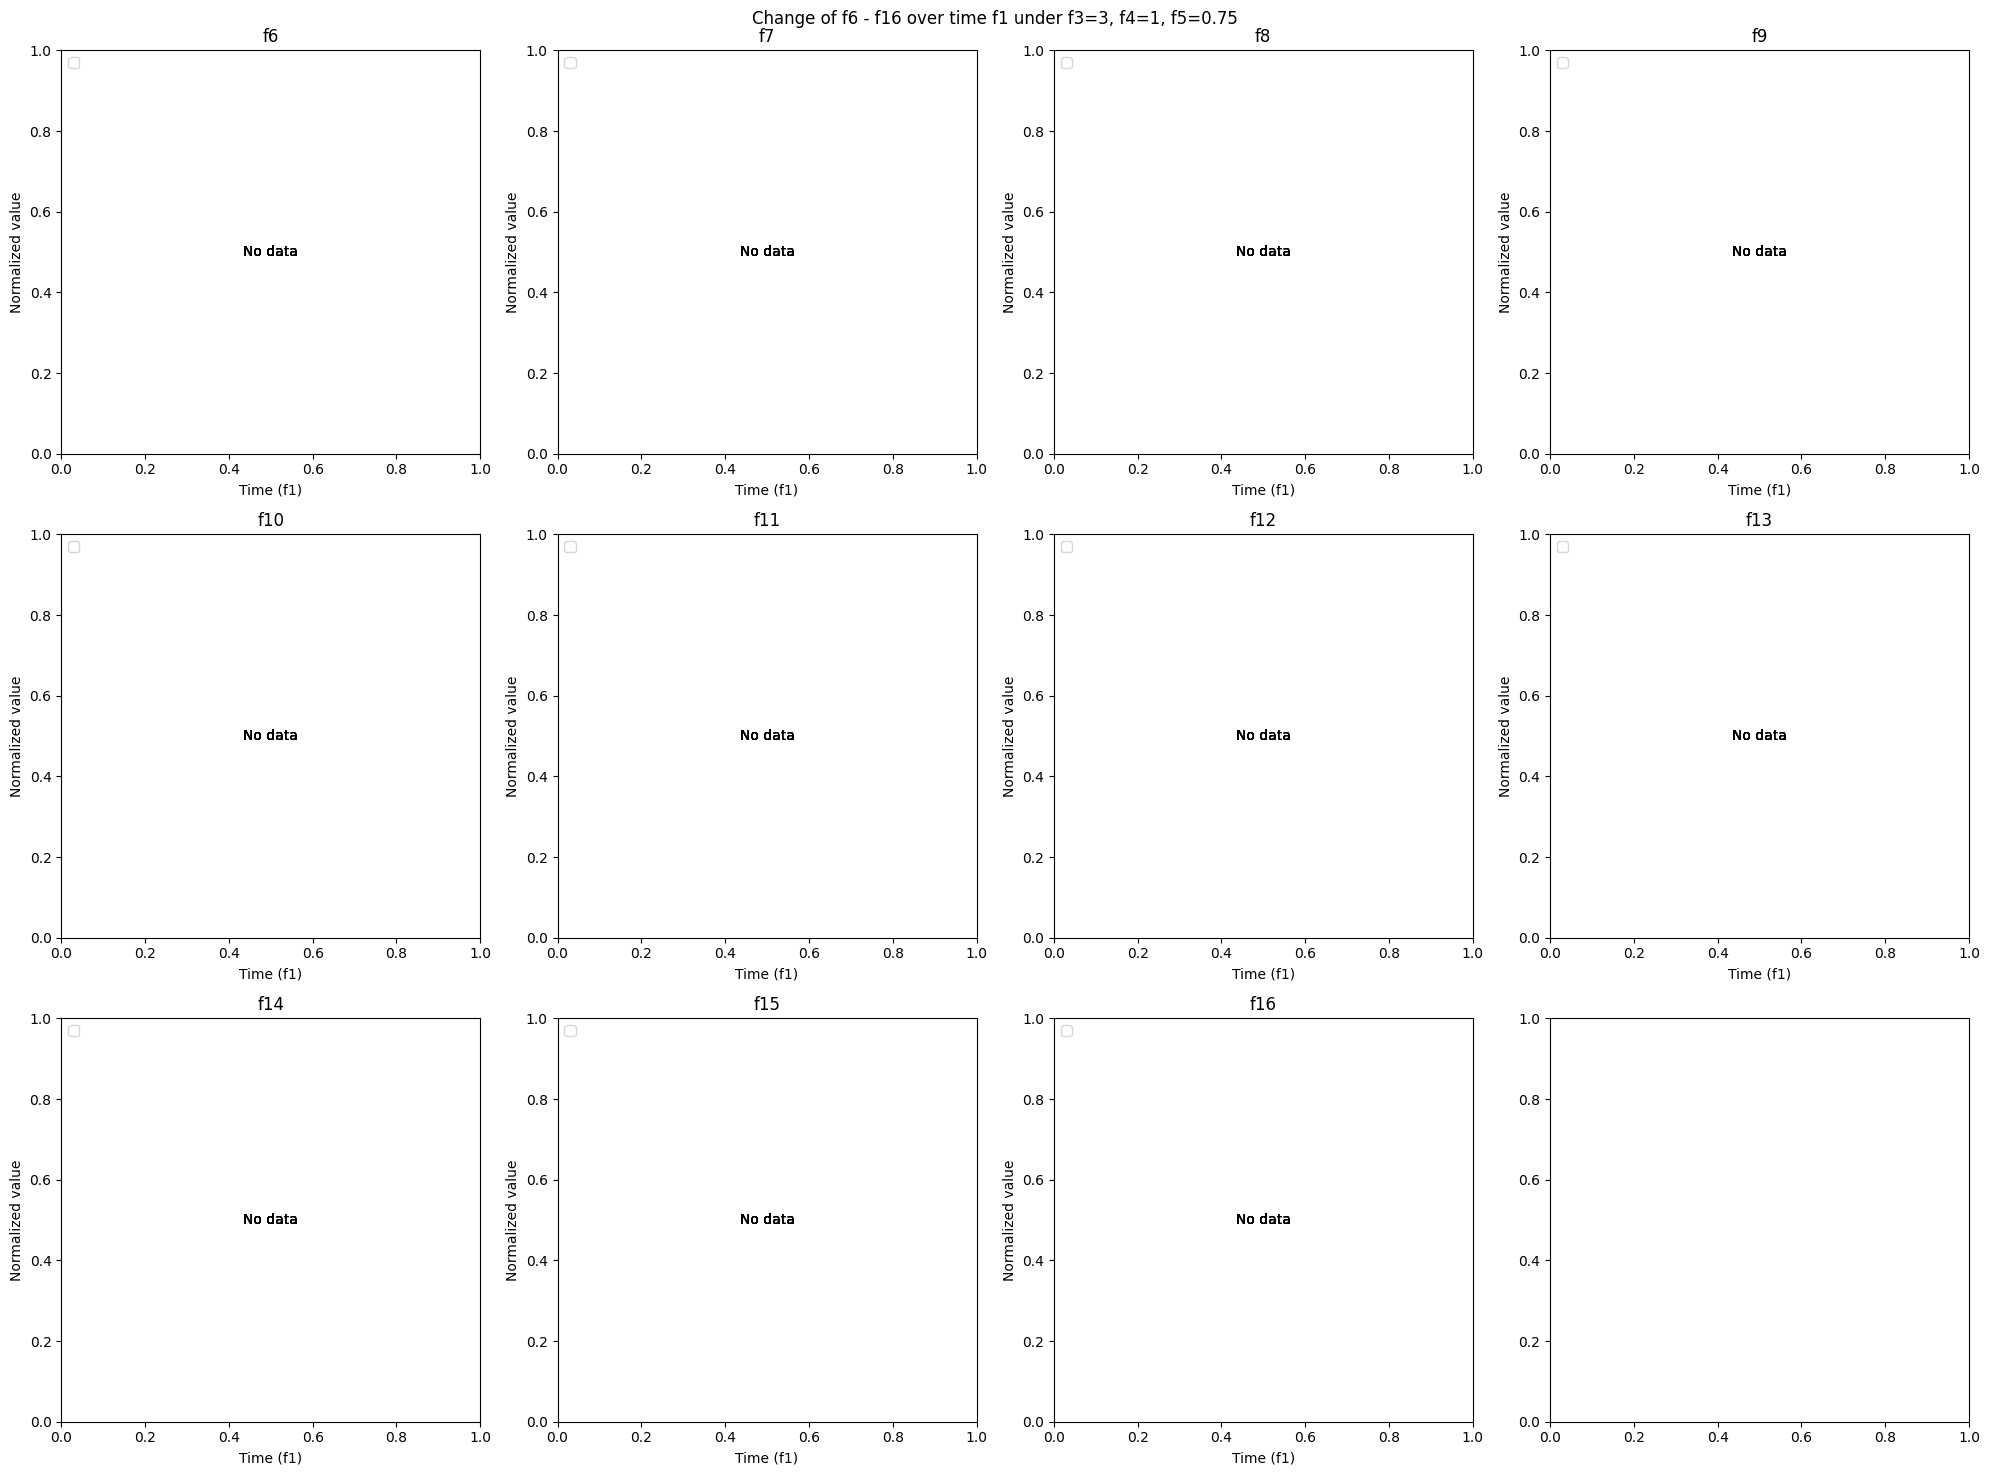

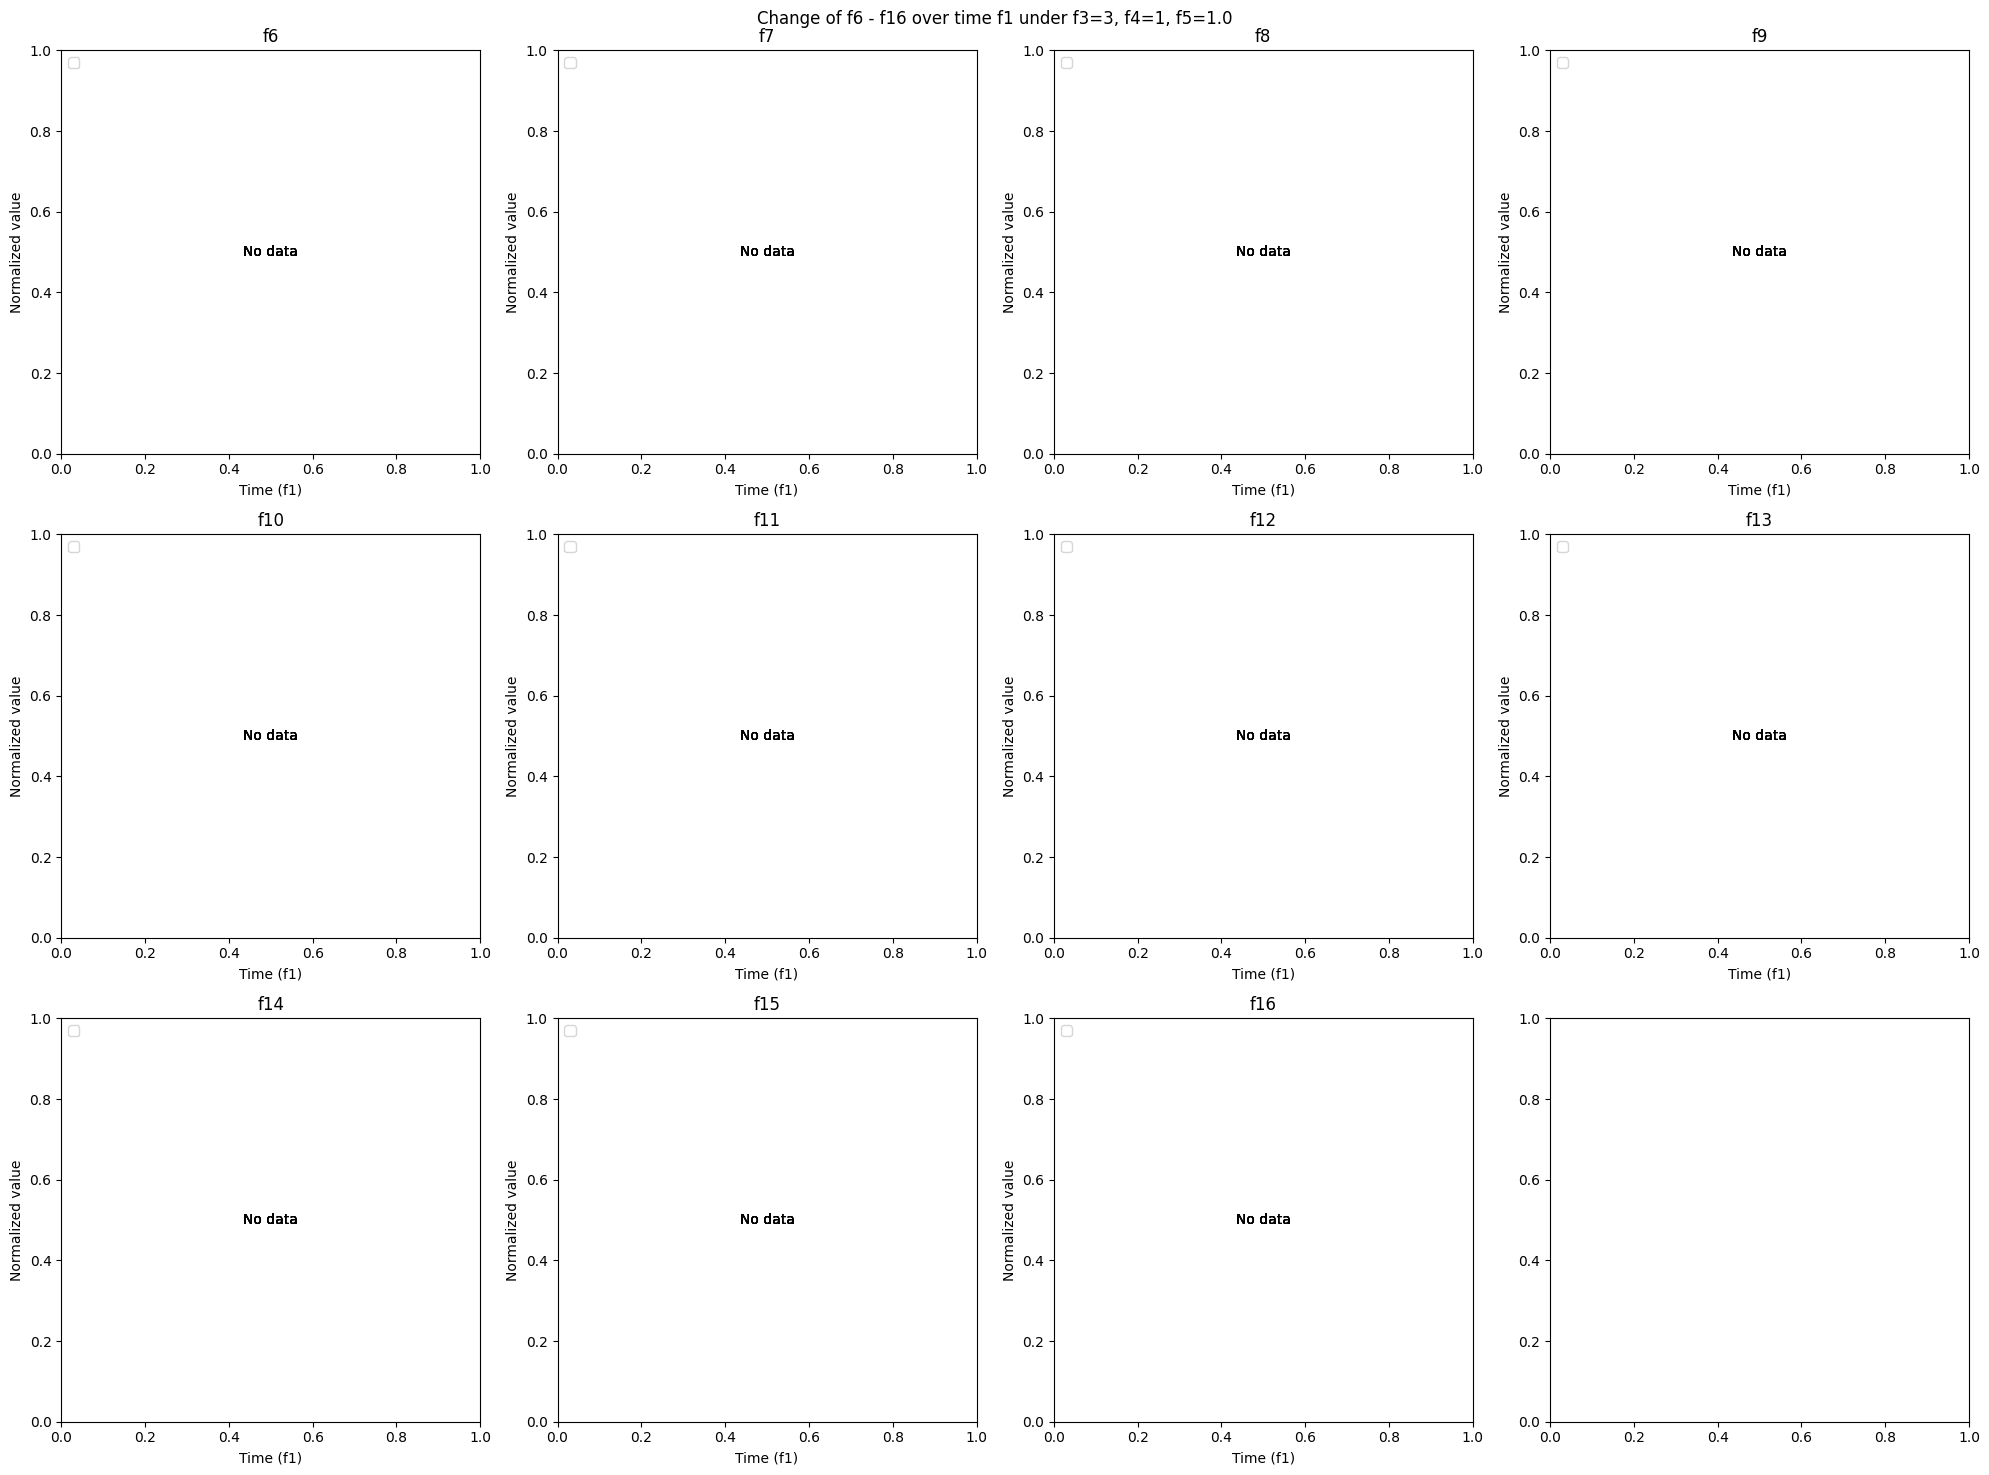

Best combination of operating mode features: (3, 0, 0.75)
Best average trend: -3.099033825075113e-10
Best average fluctuation: 0.09752065746589245


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from itertools import product
import os

if not os.path.exists('visualize(f3-f5)'):
    os.makedirs('visualize(f3-f5)')

# Outlier handling function (IQR method)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), df[column].median(), df[column])
    return df

# Smoothing function (Savitzky-Golay filter)
def smooth_data(df, column, window_length=100, polyorder=4):
    smoothed = savgol_filter(df[column], window_length=window_length, polyorder=polyorder)
    return smoothed

# Load data from data folder
data_folder = 'data'
tube_files = [os.path.join(data_folder, f'tube{i}.csv') for i in range(1, 6)]
data = [pd.read_csv(file) for file in tube_files]

# Process each tube DataFrame individually
for i in range(len(data)):
    tube_df = data[i]
    # Handle outliers for columns f6 to f16
    for column in tube_df.columns[5:16]:  # Select f6 to f16 (index 5 to 15)
        if tube_df[column].dtype != 'object':  # Only process numerical columns
            tube_df = handle_outliers(tube_df, column)

    # Initialize RobustScaler
    scaler = RobustScaler()
    # Initialize MinMaxScaler
    minmax_scaler = MinMaxScaler()

    # Apply robust standardization to columns f6 to f16
    columns_to_scale = []
    for column in tube_df.columns[5:16]:
        if tube_df[column].dtype != 'object':
            columns_to_scale.append(column)

    if columns_to_scale:
        tube_df[columns_to_scale] = scaler.fit_transform(tube_df[columns_to_scale])

    # Apply smoothing to columns f6 to f16
    for column in tube_df.columns[5:16]:  # Select f6 to f16 (index 5 to 15)
        if tube_df[column].dtype != 'object':  # Only smooth numerical columns
            # Smooth each column
            tube_df[column + '_smoothed'] = smooth_data(tube_df, column)

    # Apply MinMax normalization to the smoothed columns
    smoothed_columns = [col for col in tube_df.columns if col.endswith('_smoothed')]
    if smoothed_columns:
        tube_df[smoothed_columns] = minmax_scaler.fit_transform(tube_df[smoothed_columns])

    data[i] = tube_df

df = pd.concat(data, ignore_index=True)

# Features f3 - f5
operating_mode_cols = ['f3', 'f4', 'f5']
unique_values = [df[col].unique() for col in operating_mode_cols]
best_combination = None
best_trend = np.inf
best_fluctuation = np.inf

# Generate all possible combinations of f3 - f5
for comb in product(*unique_values):
    subset = df[(df['f3'] == comb[0]) & (df['f4'] == comb[1]) & (df['f5'] == comb[2])]

    total_trend = 0
    total_fluctuation = 0
    num_features = 0

    smoothed_columns = [col for col in df.columns if col.endswith('_smoothed')]
    for feature in smoothed_columns:
        x = subset['f1'].values
        y = subset[feature].values
        if len(x) < 2 or len(y) < 2:
            continue
        trend = np.polyfit(x, y, 1)[0]
        fluctuation = np.std(y)

        total_trend += trend
        total_fluctuation += fluctuation
        num_features += 1

    if num_features == 0:
        avg_trend = 0
        avg_fluctuation = 0
    else:
        avg_trend = total_trend / num_features
        avg_fluctuation = total_fluctuation / num_features

    if avg_trend < 0 and avg_fluctuation < best_fluctuation:
        best_fluctuation = avg_fluctuation
        best_trend = avg_trend
        best_combination = comb

    # Plot subplots for each combination
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(smoothed_columns):
        for j, tube_df in enumerate(data):
            tube_subset = tube_df[(tube_df['f3'] == comb[0]) & (tube_df['f4'] == comb[1]) & (tube_df['f5'] == comb[2])]
            if not tube_subset.empty:
                axes[i].plot(tube_subset['f1'], tube_subset[feature], label=f'Tube {j + 1}')
            else:
                axes[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{feature[:-9]}')
        axes[i].set_xlabel('Time (f1)')
        axes[i].set_ylabel('Normalized value')
        axes[i].legend(loc='upper left')

    fig.suptitle(f'Change of f6 - f16 over time f1 under f3={comb[0]}, f4={comb[1]}, f5={comb[2]}')
    plt.tight_layout()

    file_name = f"visualize(f3-f5)/f3_{comb[0]}_f4_{comb[1]}_f5_{comb[2]}.png"
    # save figure
    plt.savefig(file_name)
    plt.show()

print(f"Best combination of operating mode features: {best_combination}")
print(f"Best average trend: {best_trend}")
print(f"Best average fluctuation: {best_fluctuation}")